In [8]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import imageio

from PIL import Image

from typing import Callable, Tuple

# Conway's Game of Life 

1. The universe of the Game of Life is a $N \times N$ square, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, alive or dead. Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent (assume coordinates of neighbours modulo $N$). At each step in time, the following transitions occur:

  * Any live cell with two or three neighbours survives.
  * Any dead cell with three live neighbours becomes a live cell.
  * All other live cells die in the next generation. Similarly, all other dead cells stay dead.

2. Provide a parallel implementation for this Game of Life automaton, where each process should take some square (or rectangular, up to you) part of the grid.

3. Show the evolution of the grid and number of the living cells in time for different initial conditions (random and the well known ones, like "Gosper's gun").

In [37]:
def plot_image(img: np.ndarray):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img, aspect='auto', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig

class grid_class:
    def __init__(self, size_x=100, size_y=100, coeff=0.5, use_glider=False):
        self.data = np.random.choice(
            [0, 1], (size_x, size_y), replace=True, p=[coeff, 1.0-coeff])
        self.size_x = size_x
        self.size_y = size_y
        self.coeff = coeff
            
        if use_glider:
            self.size_x = 10
            self.size_y = 10

            self.data = np.zeros((self.size_x, self.size_y))            
            self.compute_glider()
        
        self.change_candidates = np.zeros_like(self.data)
    
    def compute_glider(self):
        self.data = np.zeros((self.size_x, self.size_y))

        glider = [[1, 0, 0],
                  [0, 1, 1],
                  [1, 1, 0]]
        
        self.data[2:5, 2:5] = glider
        
            
            
    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(self.data, aspect='auto', interpolation='none')
        ax.set_xticks([])
        ax.set_yticks([])
        return fig

    def count_neighbours(self, i=0, j=0):
#         n_neighbours = 0
#         for x in [-1, 0, 1]:
#             for y in [-1, 0, 1]:
#                 if i == 0 and j == 0:
#                     continue
#                 n_neighbours += self.data[(x + i) % self.data.shape[0],
#                                      (y + j) % self.data.shape[1]]
                
        n_neighbours = 0
        for incx in [-1, 0, 1]:
            for incy in [-1, 0, 1]:
                if ((incx != 0) or (incy != 0)):
                    ix = i+incx
                    iy = j+incy

                    if ix == -1:
                        ix += self.size_x
                    elif ix == self.size_x:
                        ix = 0

                    if iy == -1:
                        iy += self.size_y
                    elif iy == self.size_y:
                        iy = 0

                    if self.data[ix, iy] == 1:
                        n_neighbours += 1

        return n_neighbours

    def update(self, i=0, j=0):
        count = self.count_neighbours(i, j)
        change = 0

        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise

        if (self.data[i][j] == 0) and (count == 3) or (self.data[i][j] == 1) and ((count < 2) or (count > 3)):
            self.change_candidates[i, j] = -1 if self.data[i][j] else 1
            change = 1

        return change

    def one_time_step(self):
        # go through the map, update each cell
        change_count = 0
        
        change_candidates = []
        
        for i in np.arange(self.size_x):
            for j in np.arange(self.size_y):
                change_count += self.update(i, j)
        
        self.data = self.data + self.change_candidates
        
        self.change_candidates = np.zeros_like(self.data)
        
        return change_count

Test map generation

/home/sanityseeker/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


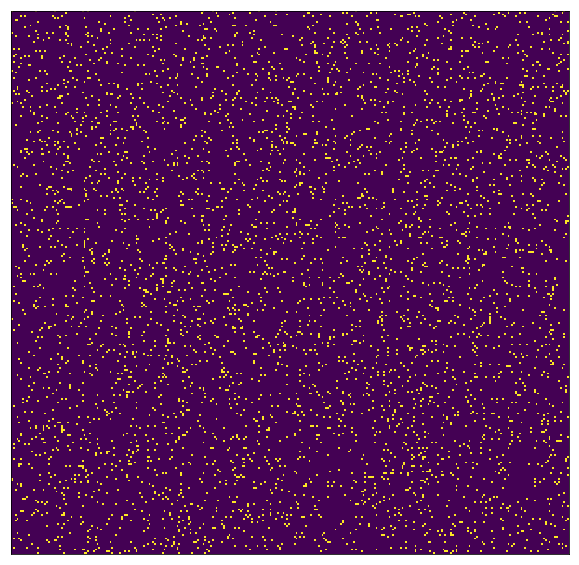

In [3]:
grid = grid_class(300, 300, 0.95)

grid.plot().show()

## Single process run

In [29]:
num_iters = 100
gif_images_path = 'gif_images'

if os.path.exists(gif_images_path):
    os.system(f'rm -rf {gif_images_path}/*')
else:
    os.makedirs(gif_images_path)

100%|██████████| 100/100 [02:06<00:00,  1.29s/it]


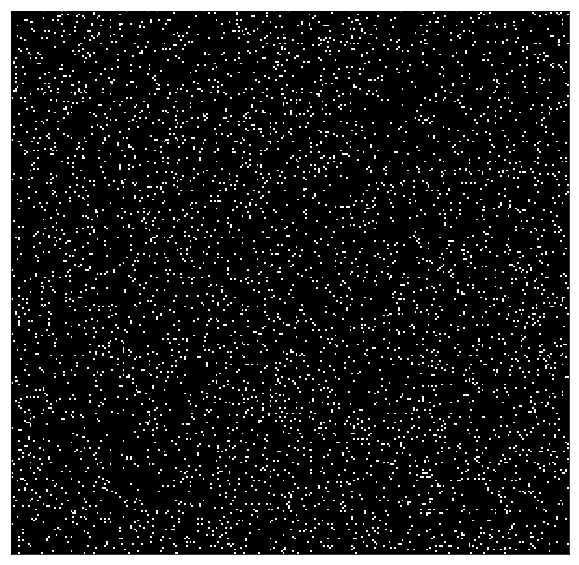

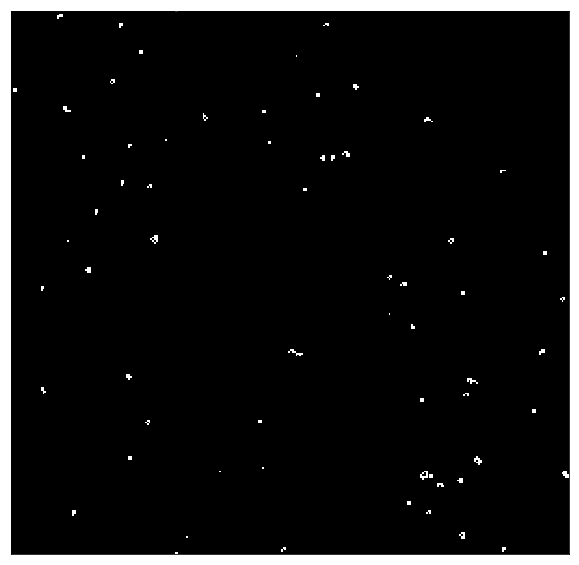

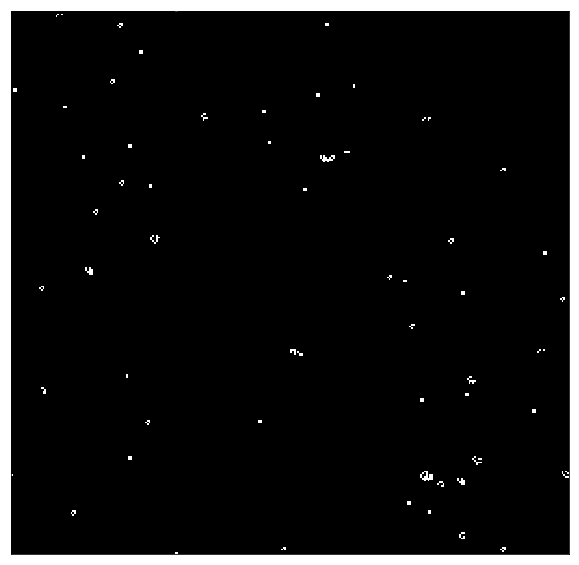

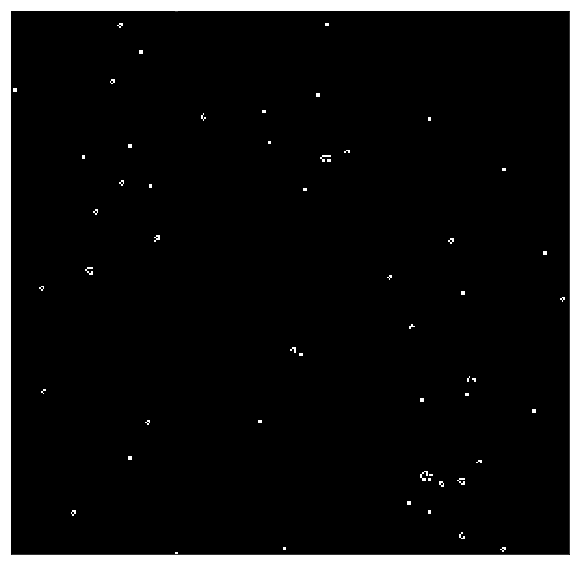

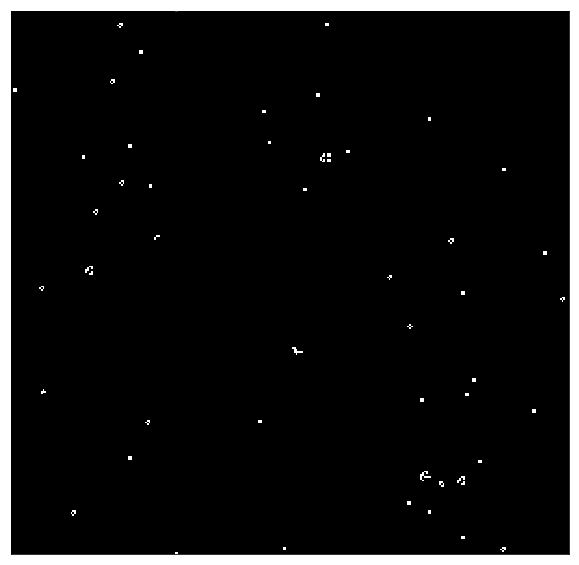

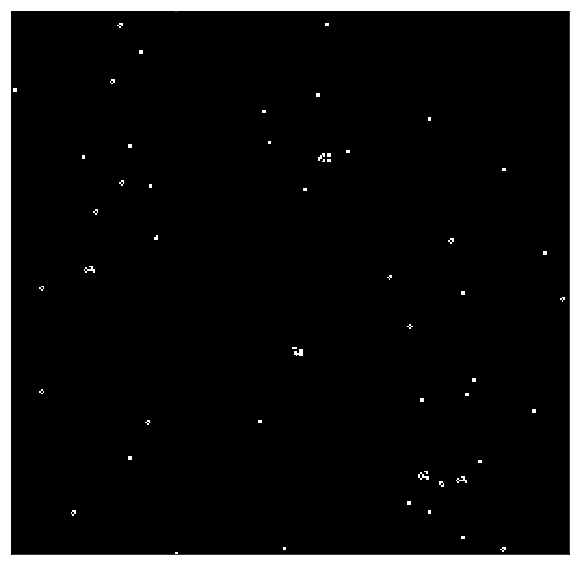

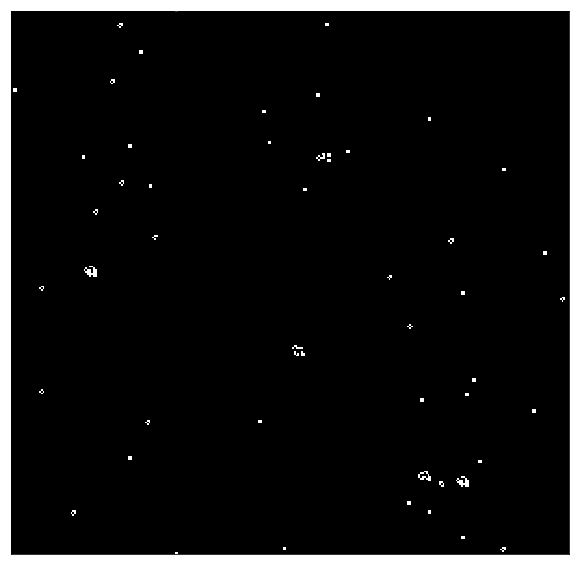

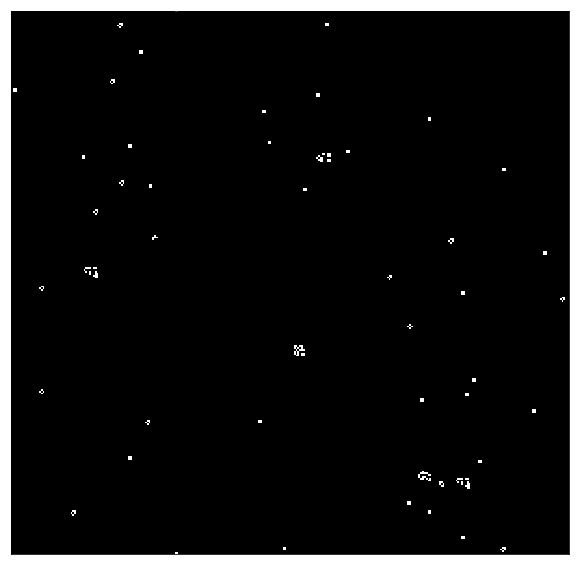

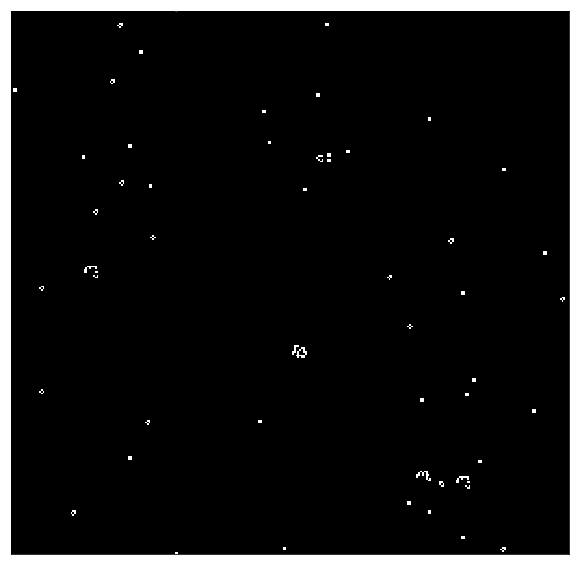

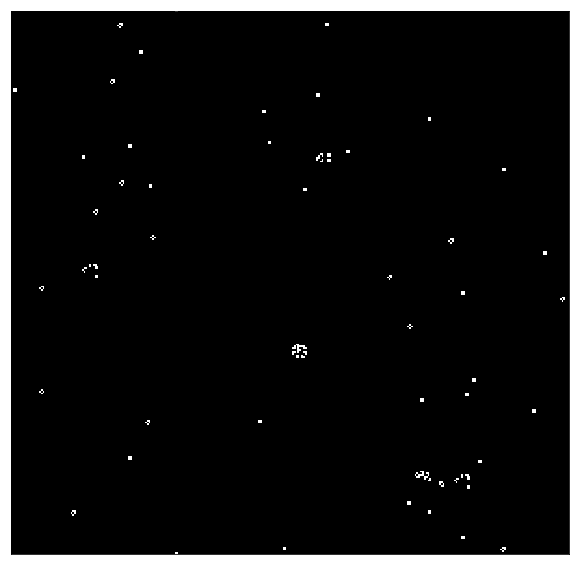

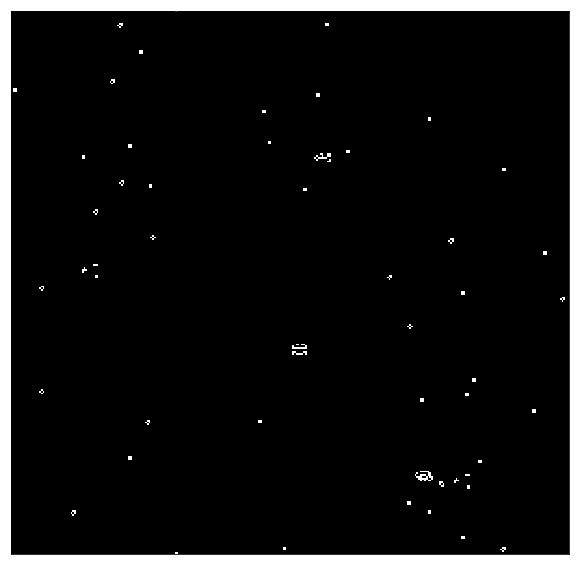

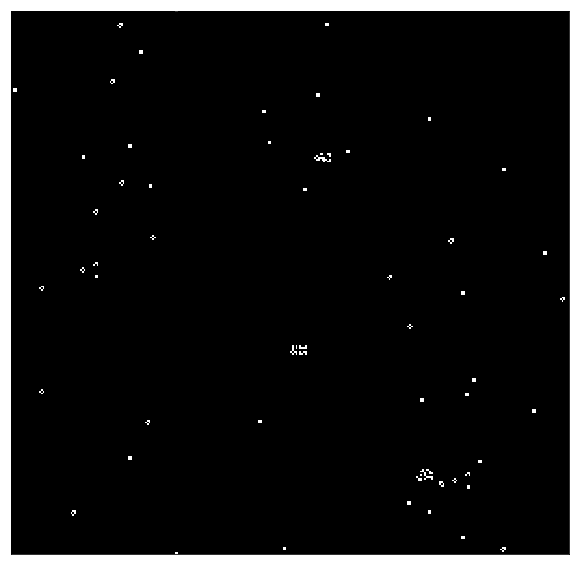

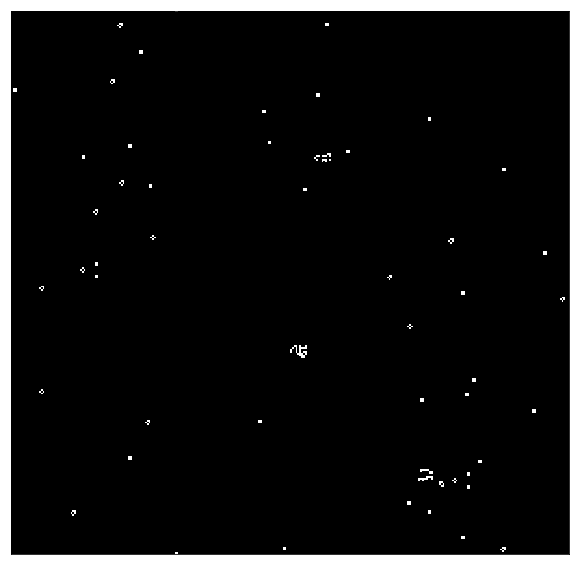

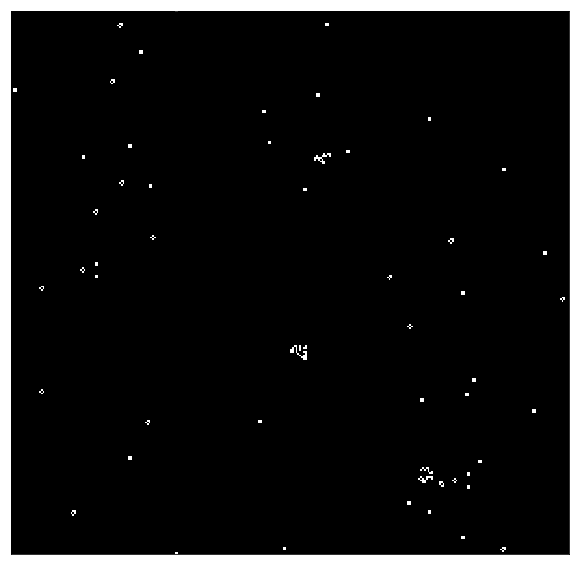

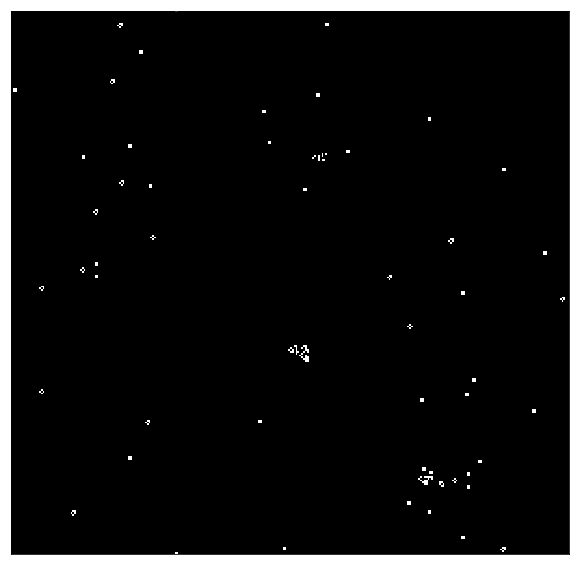

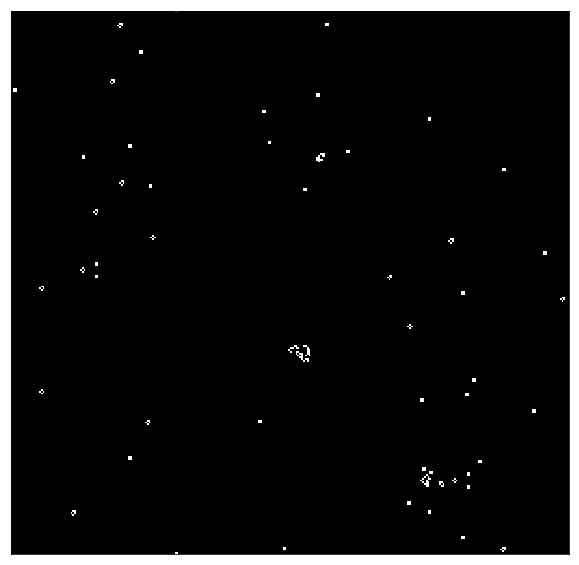

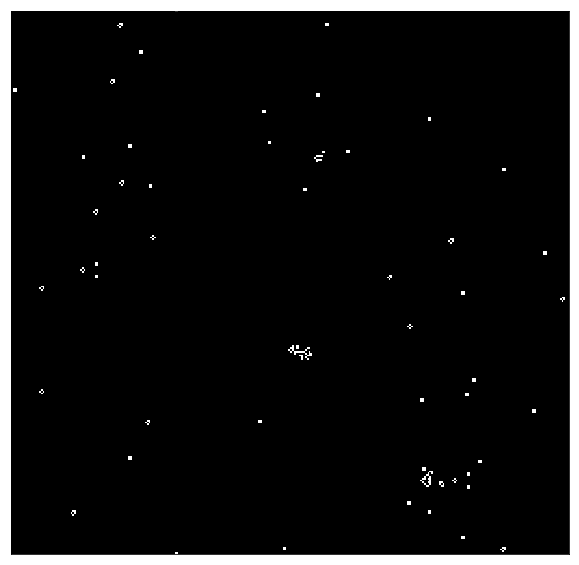

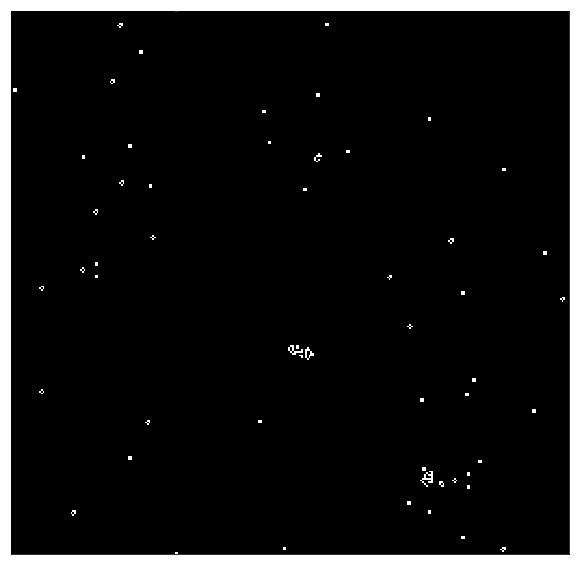

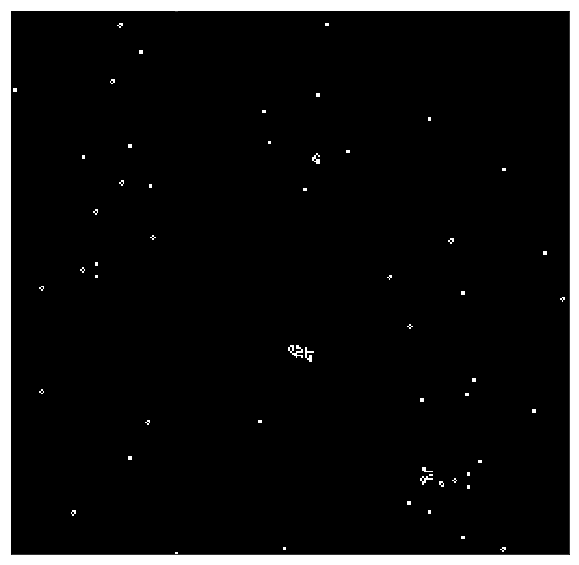

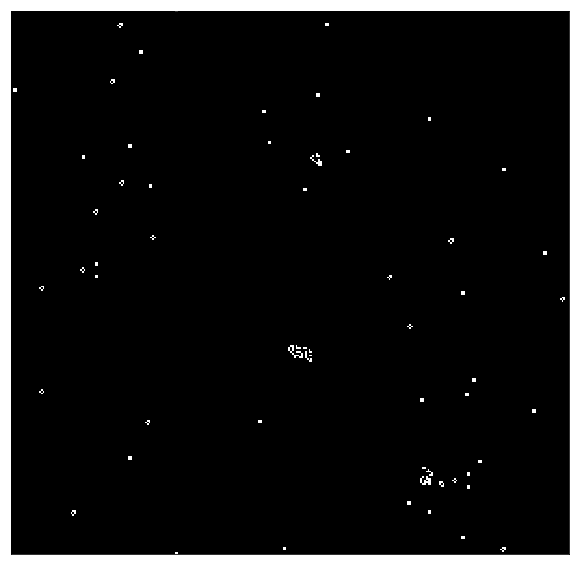

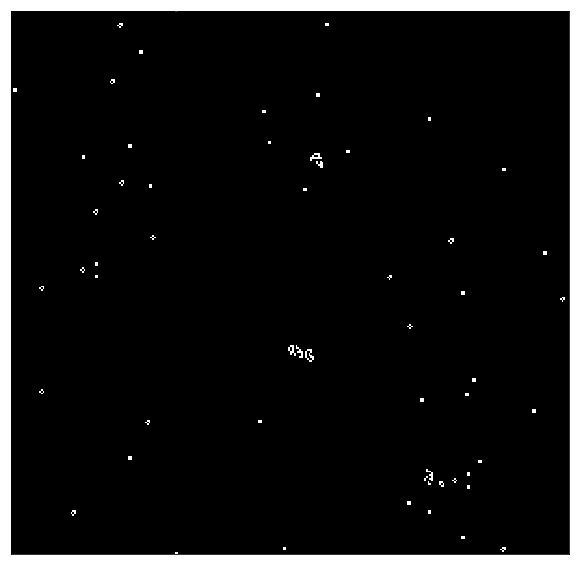

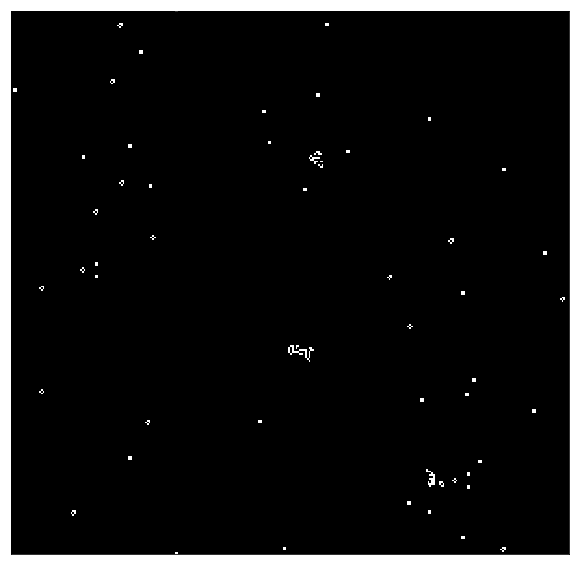

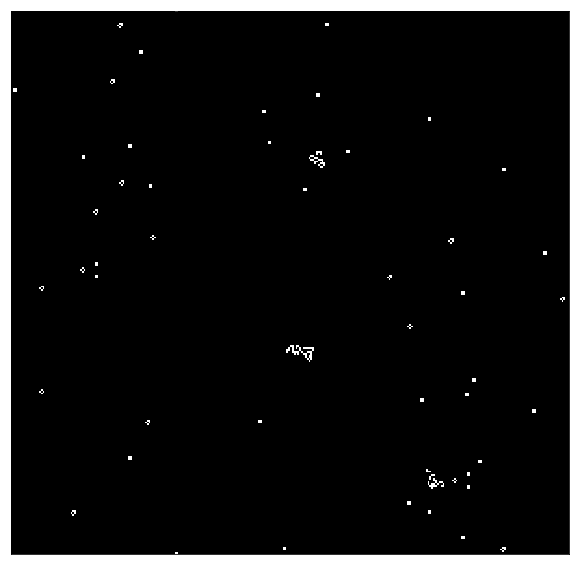

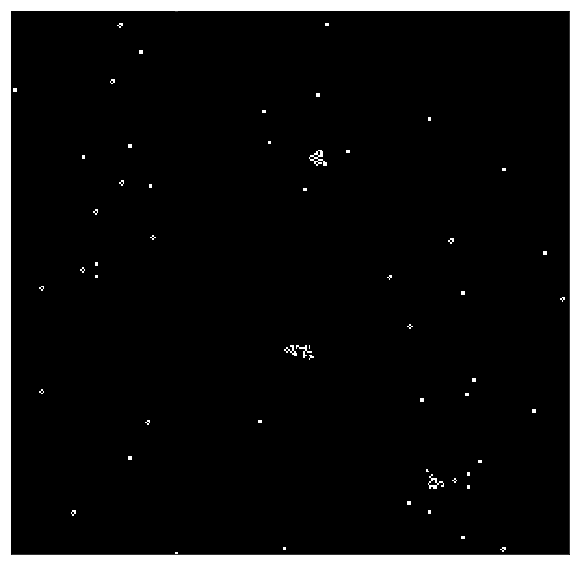

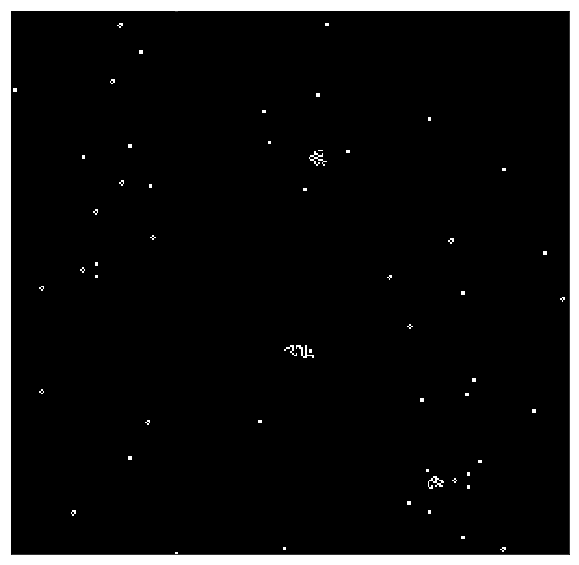

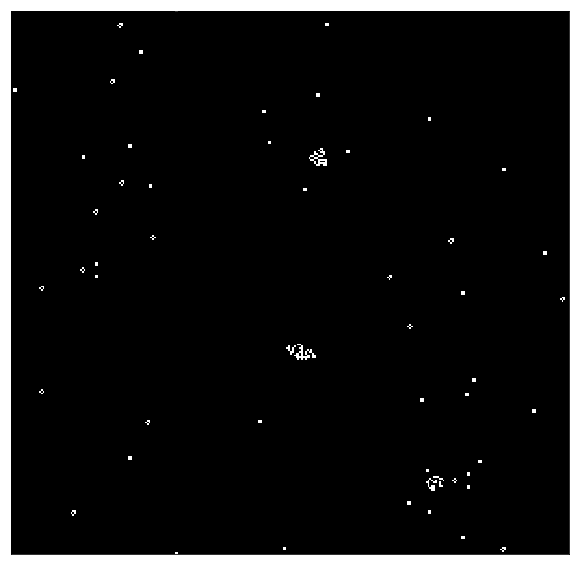

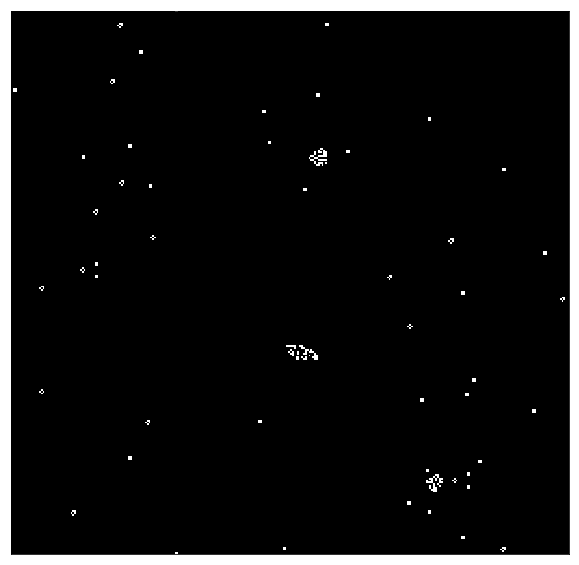

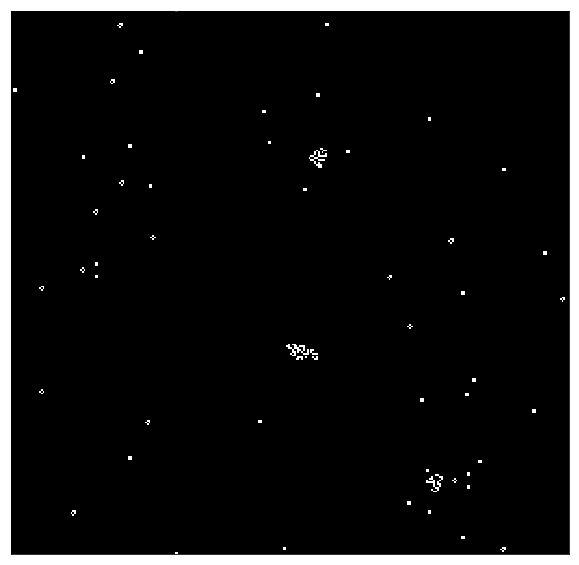

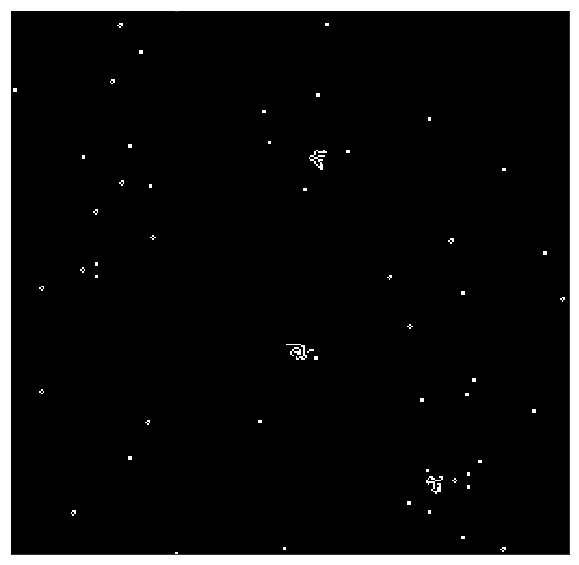

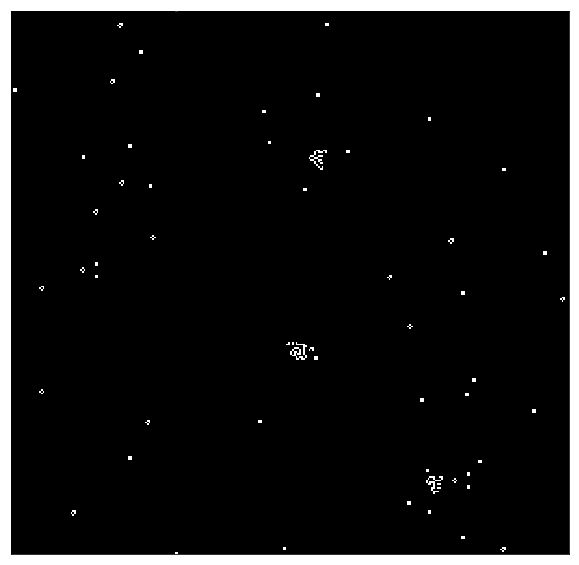

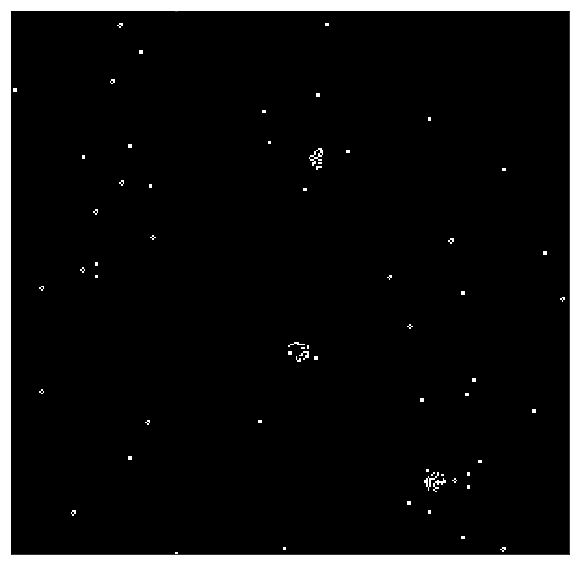

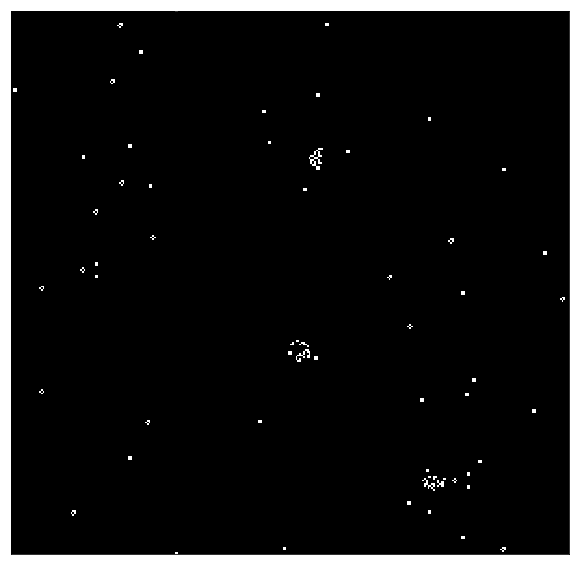

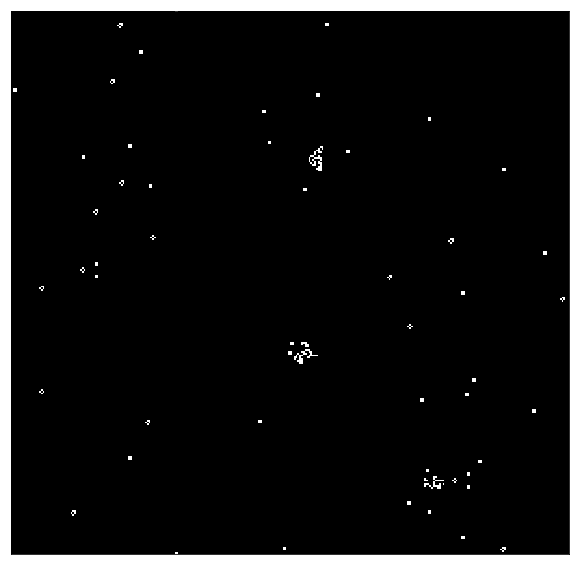

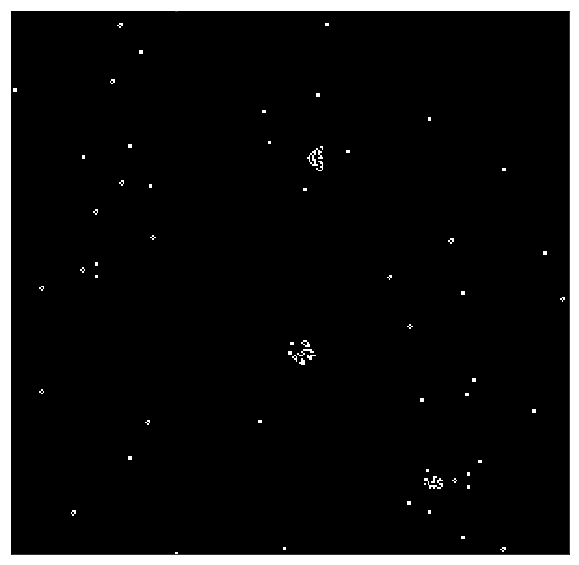

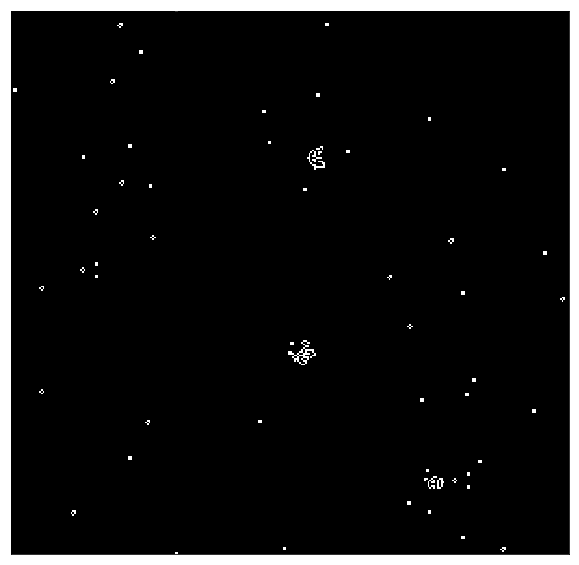

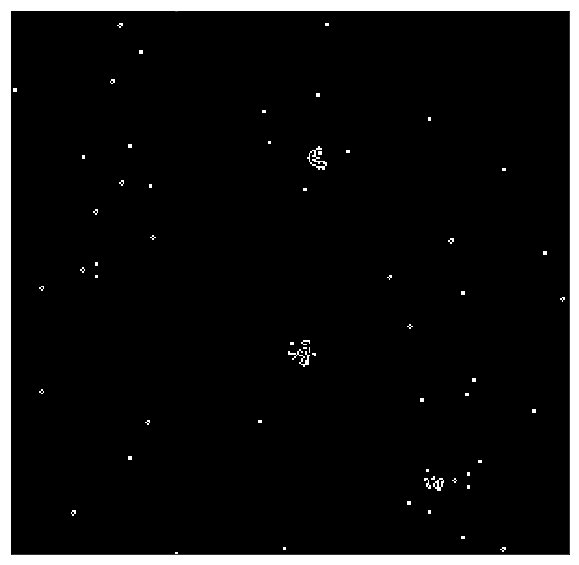

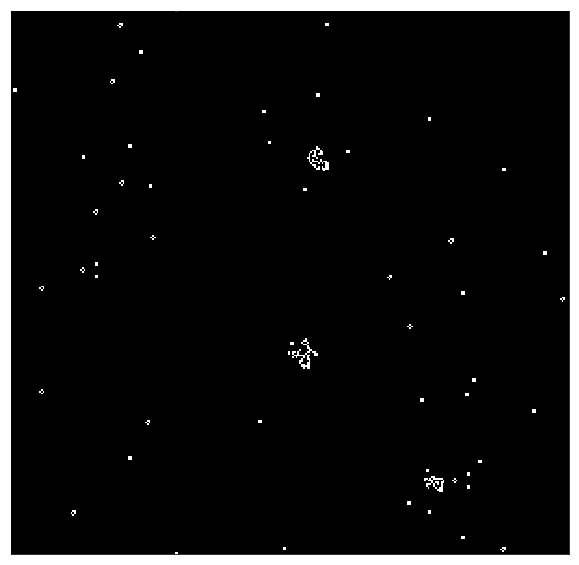

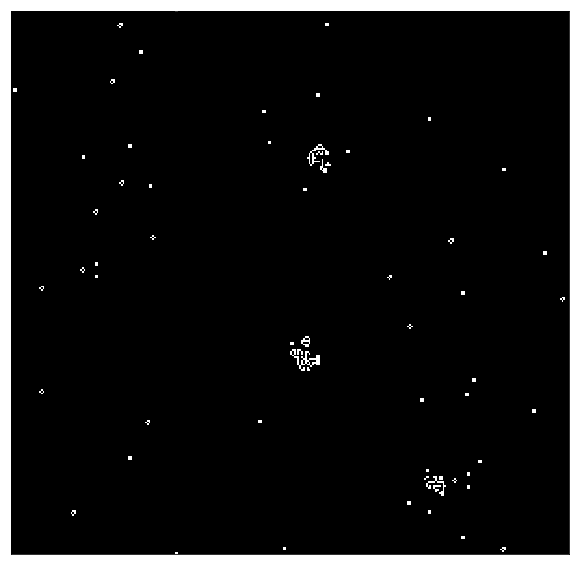

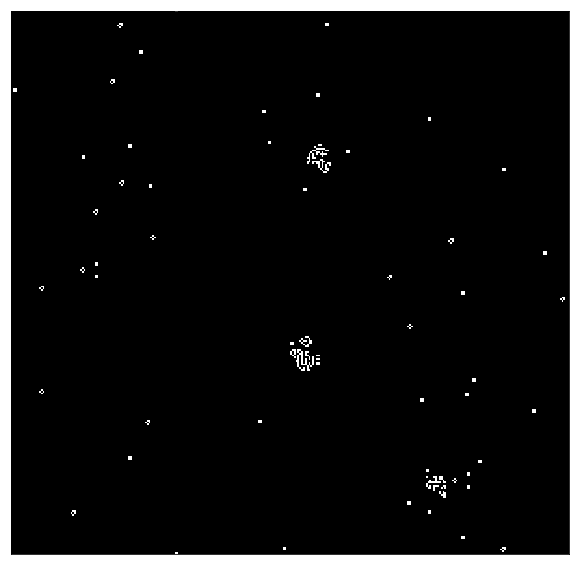

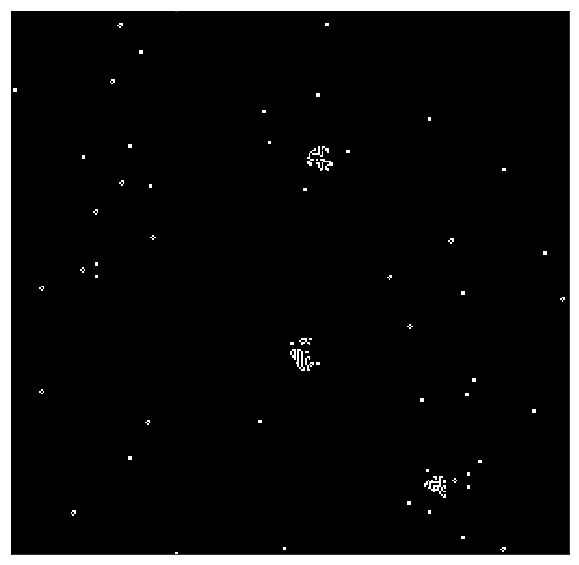

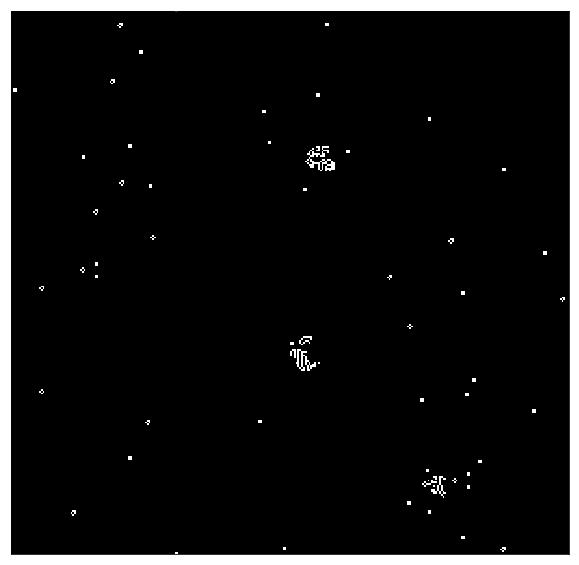

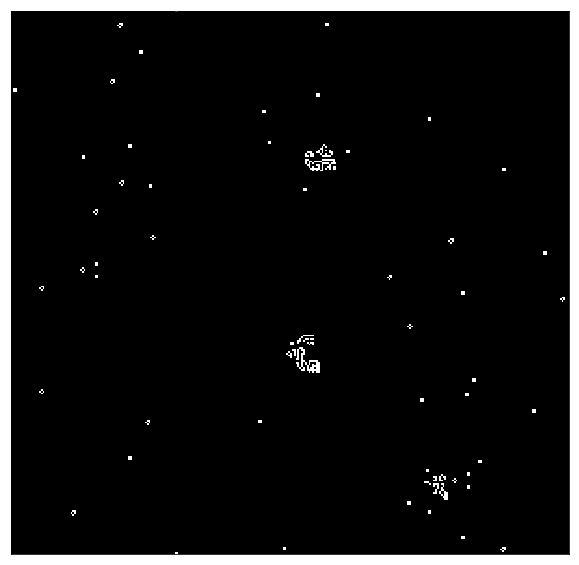

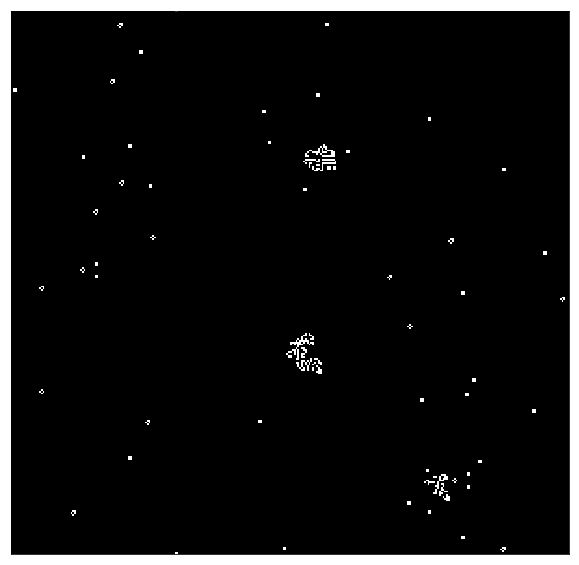

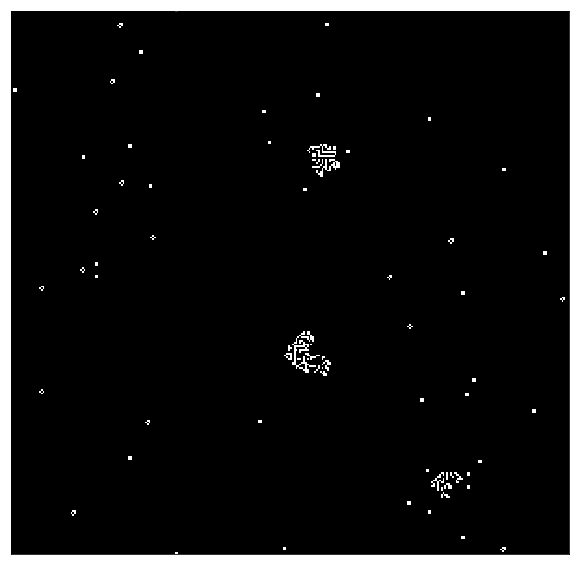

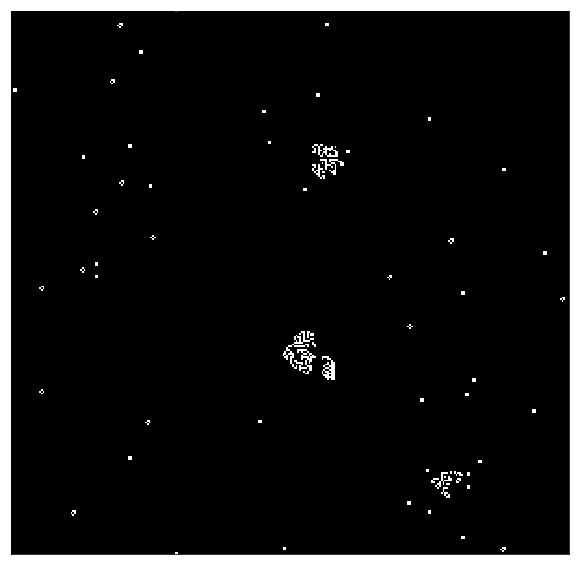

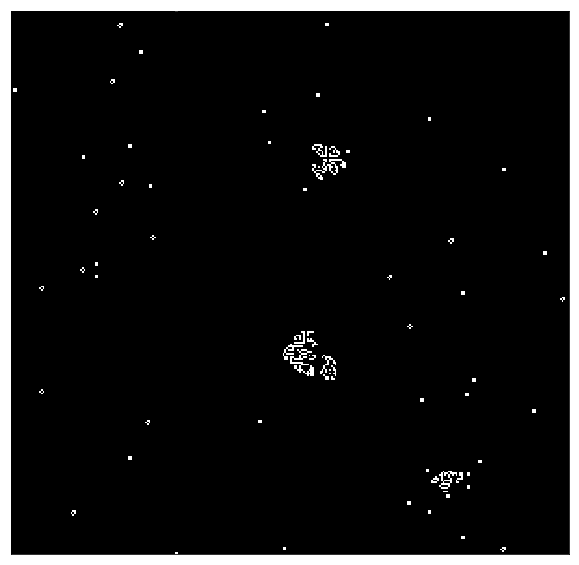

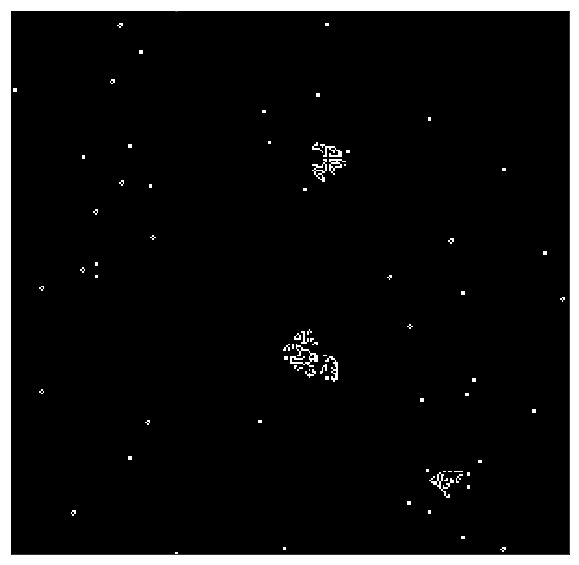

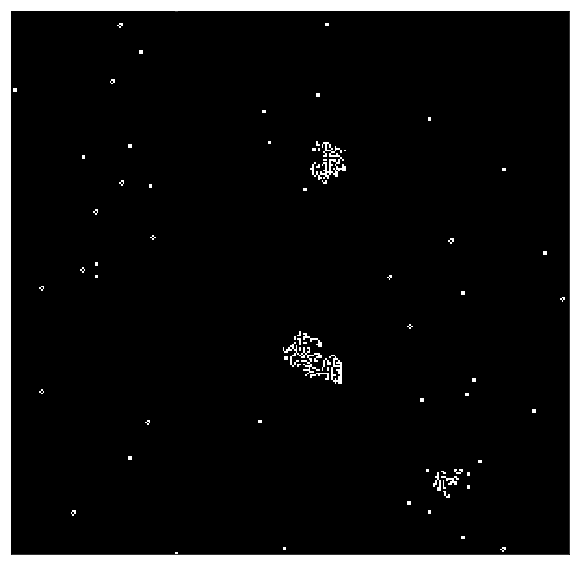

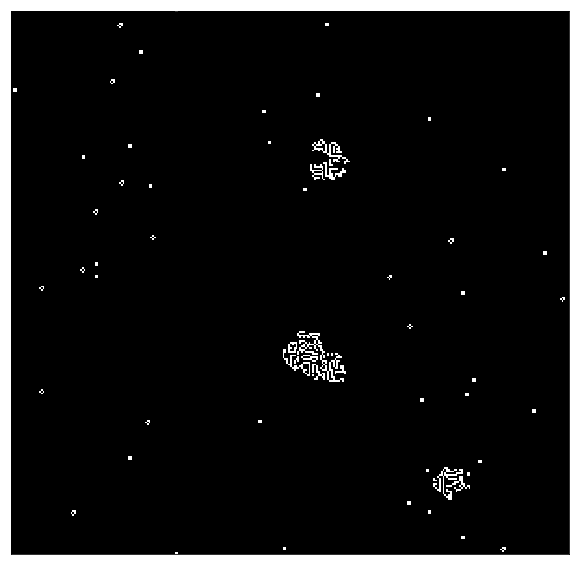

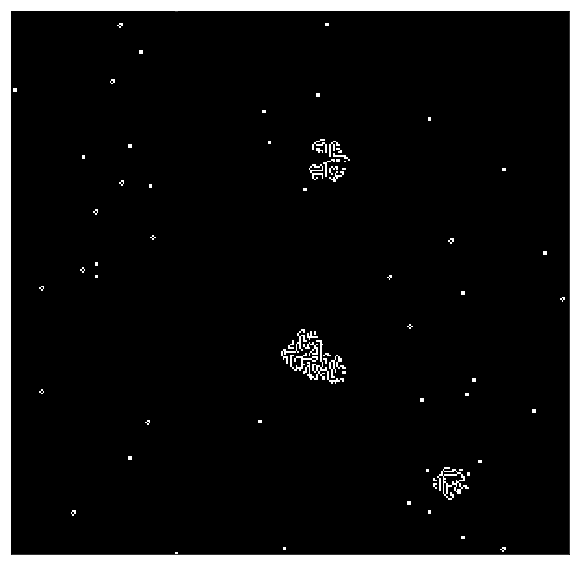

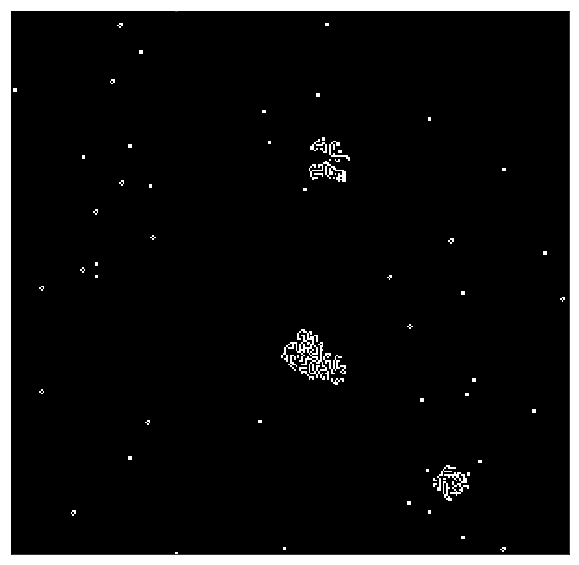

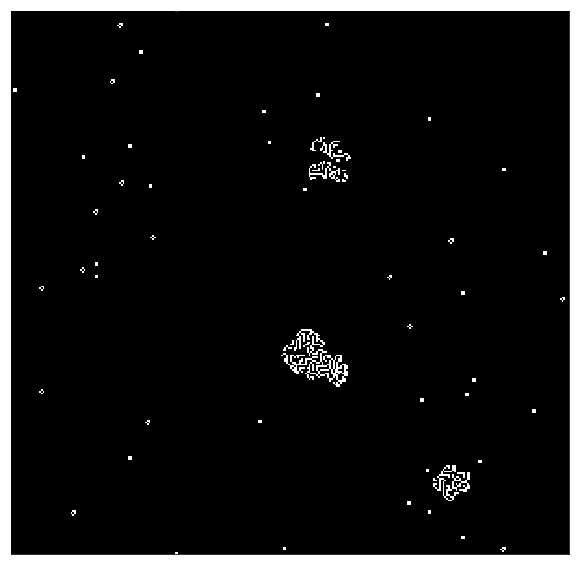

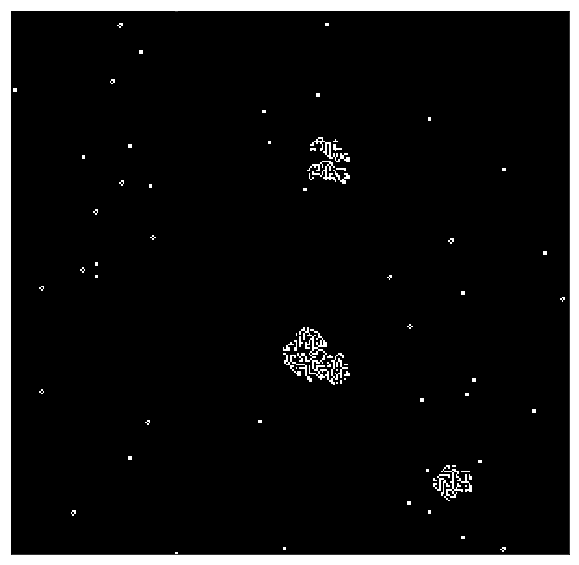

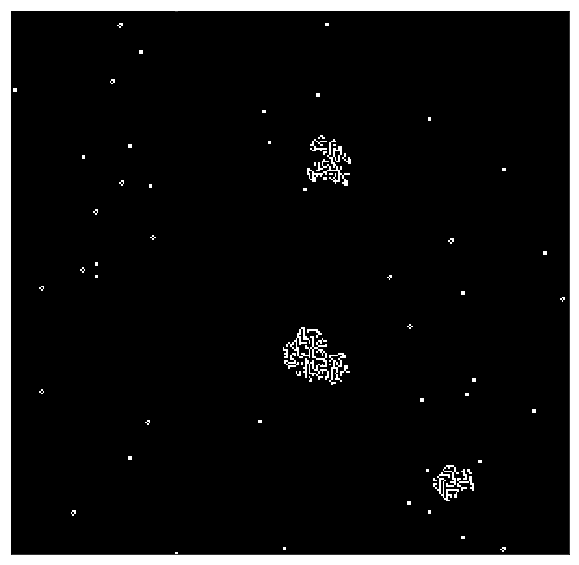

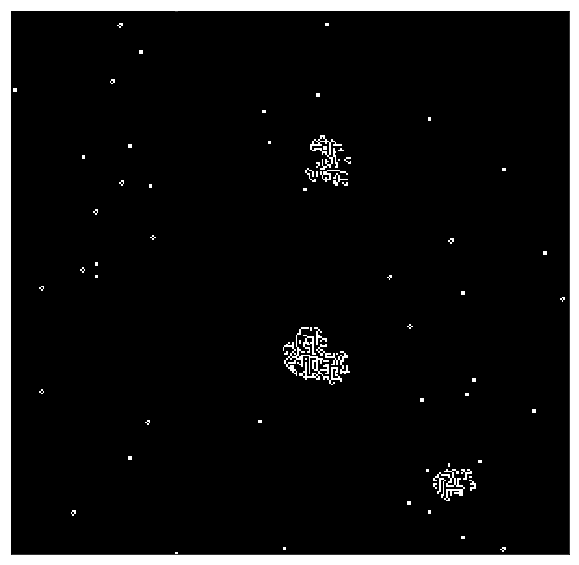

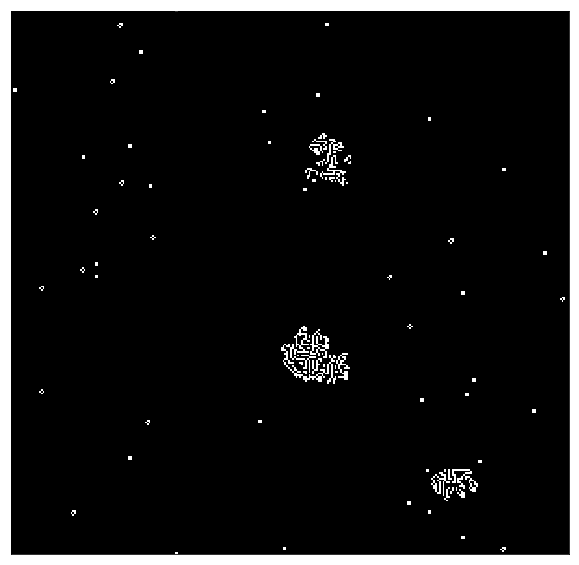

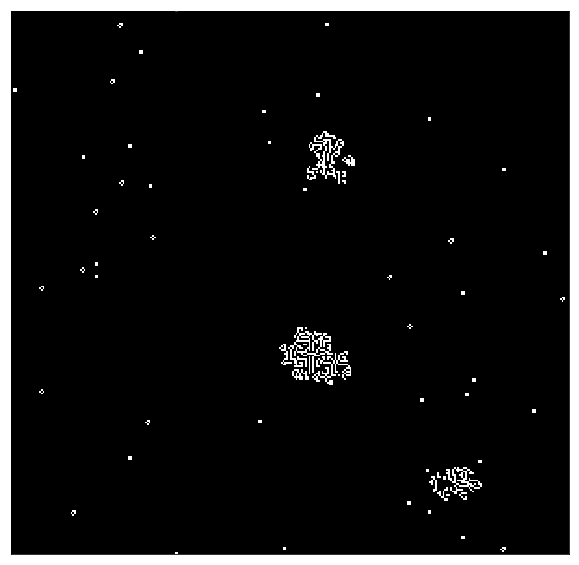

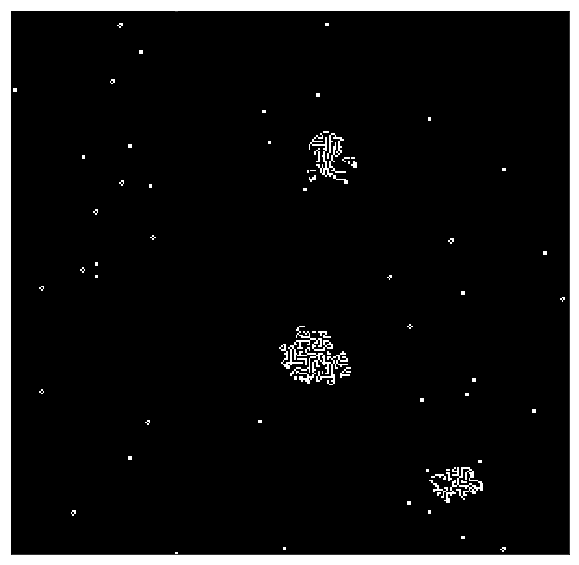

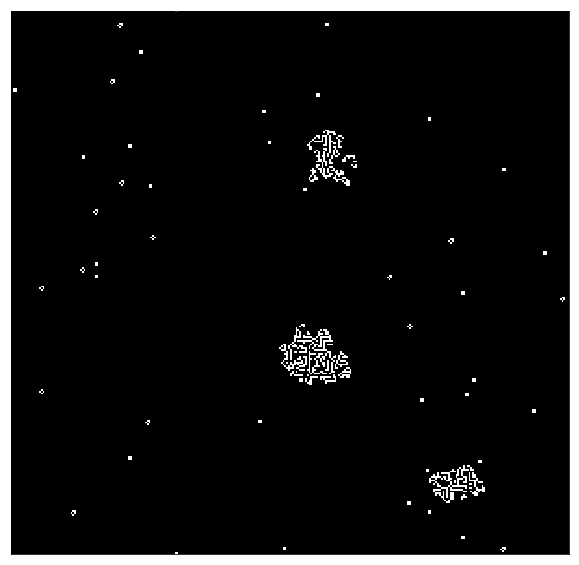

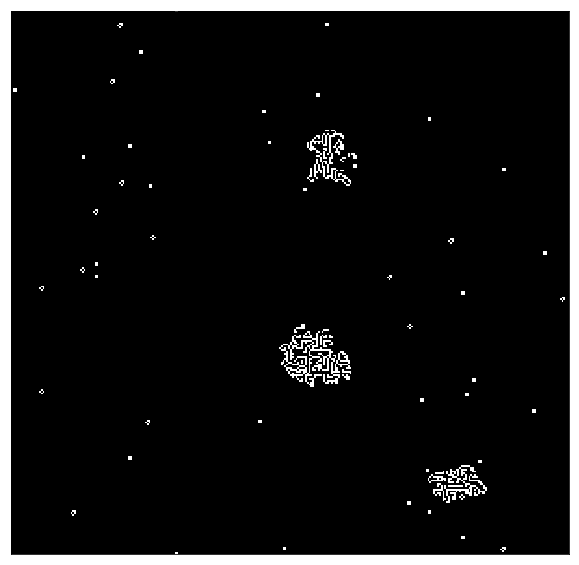

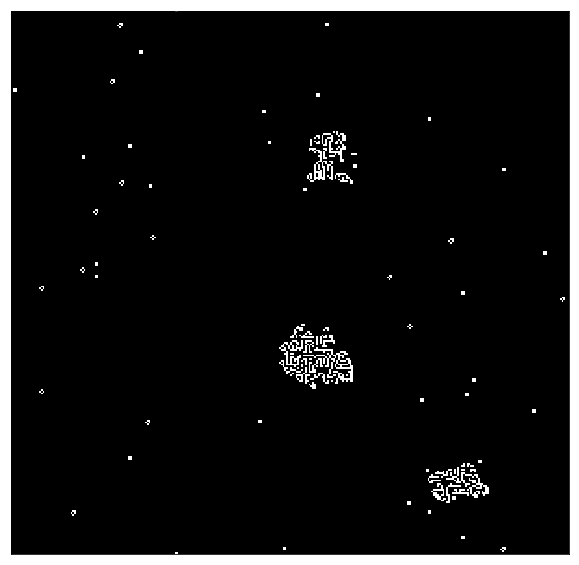

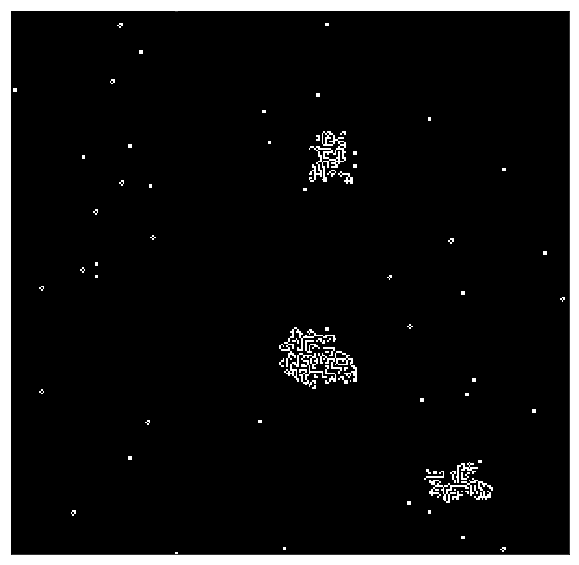

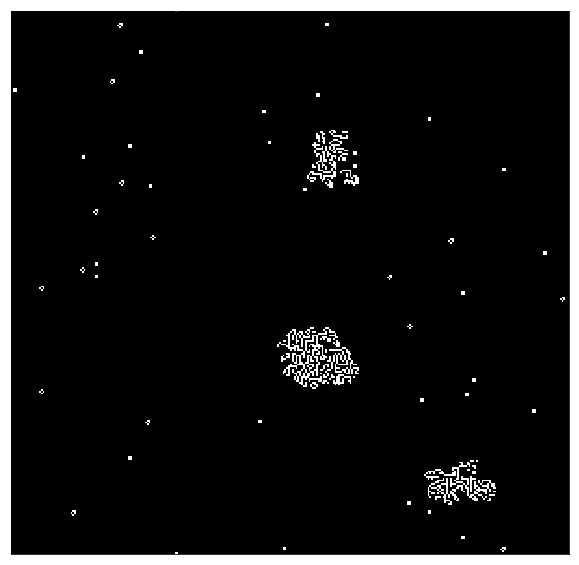

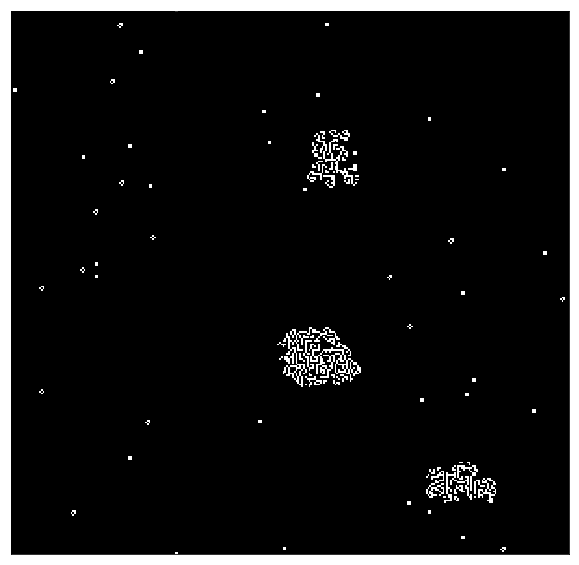

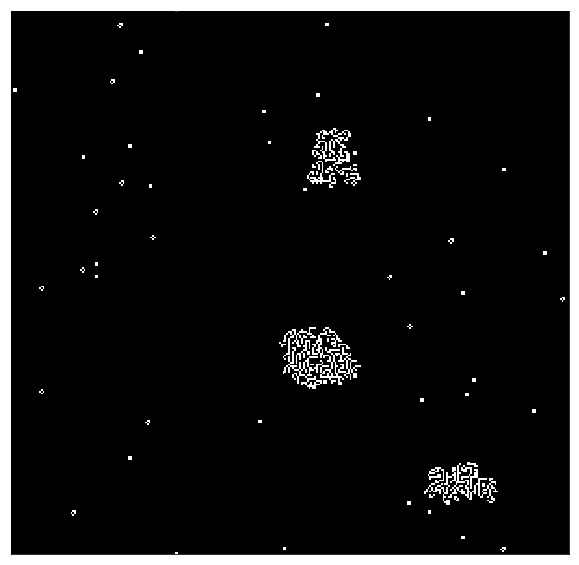

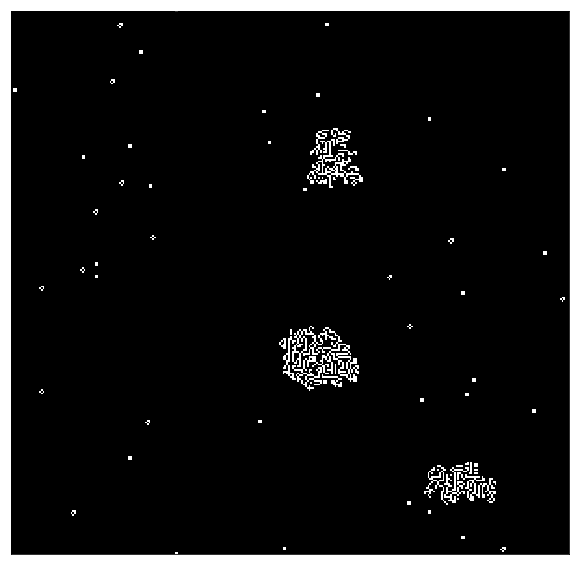

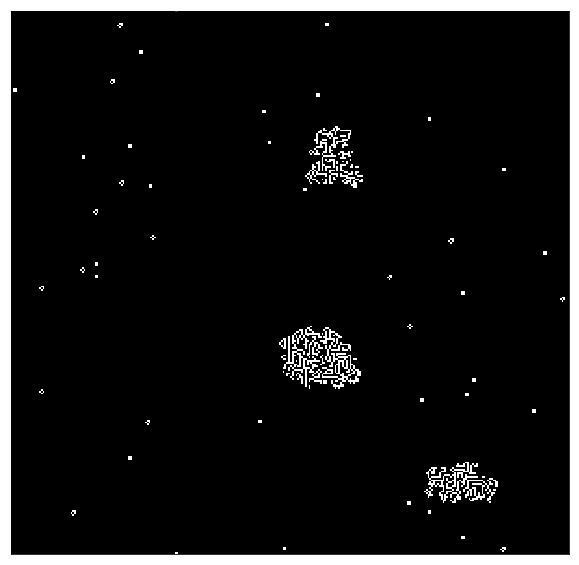

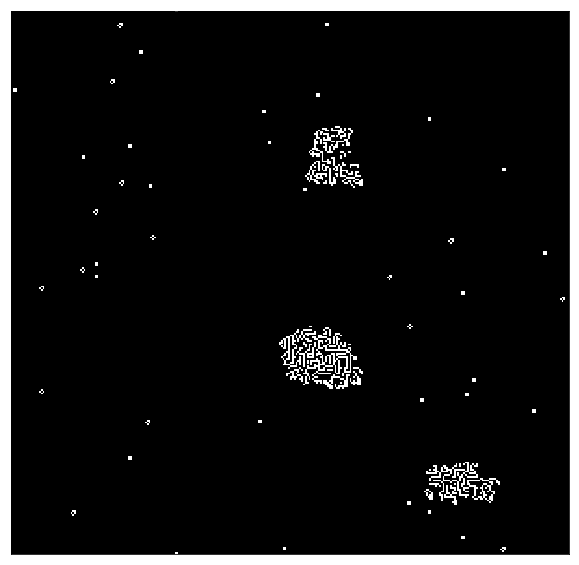

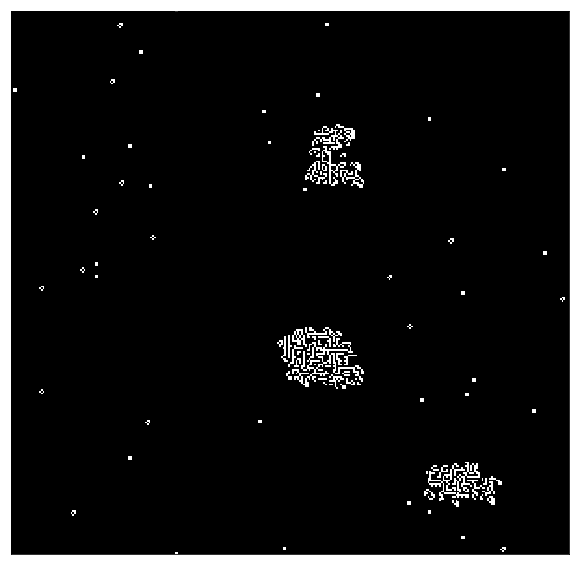

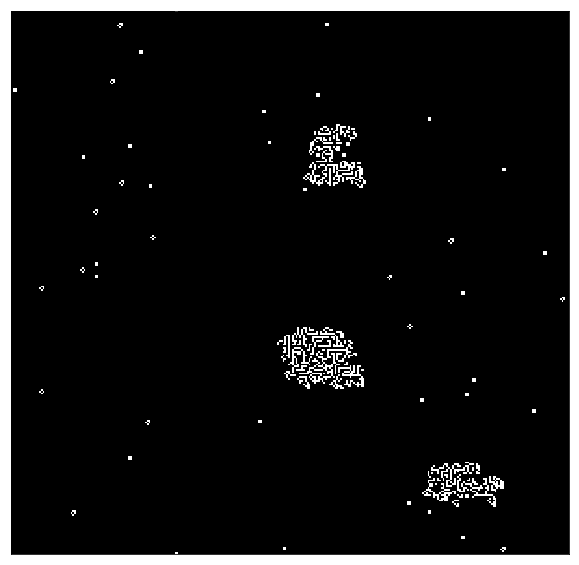

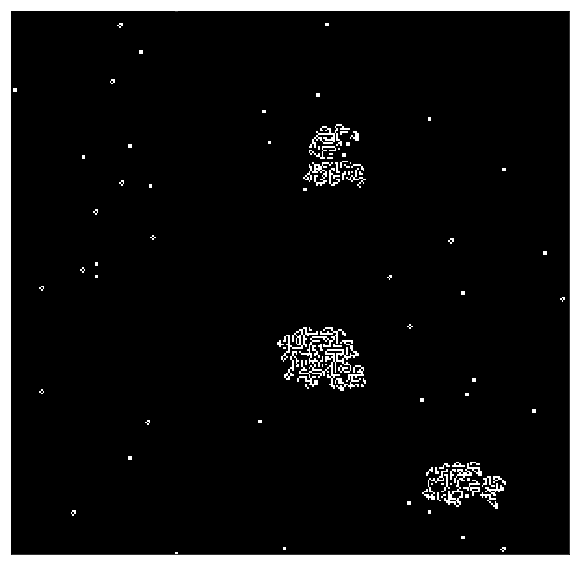

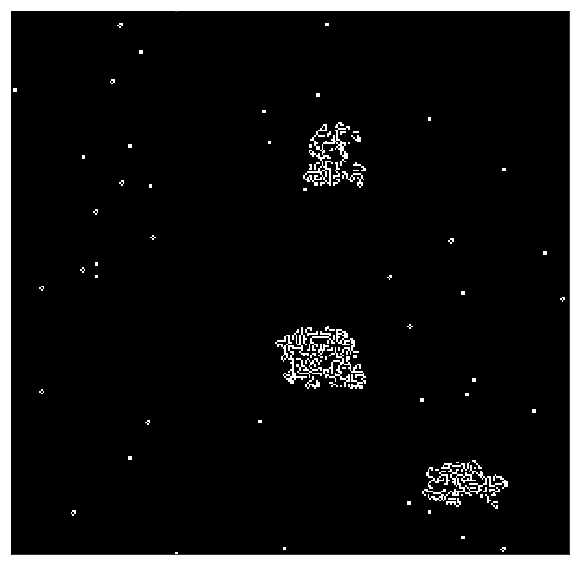

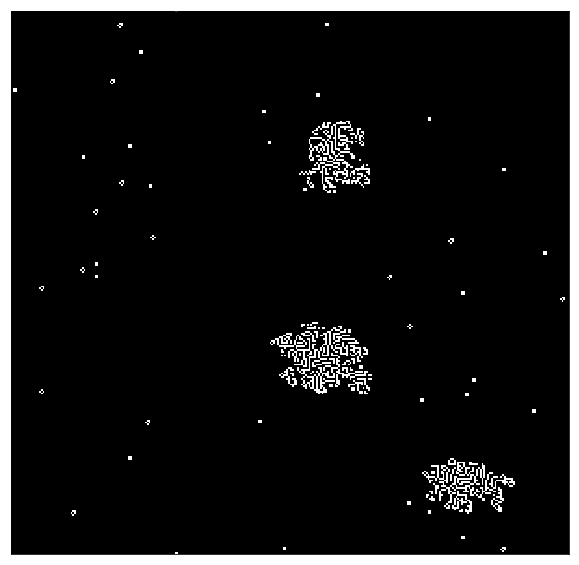

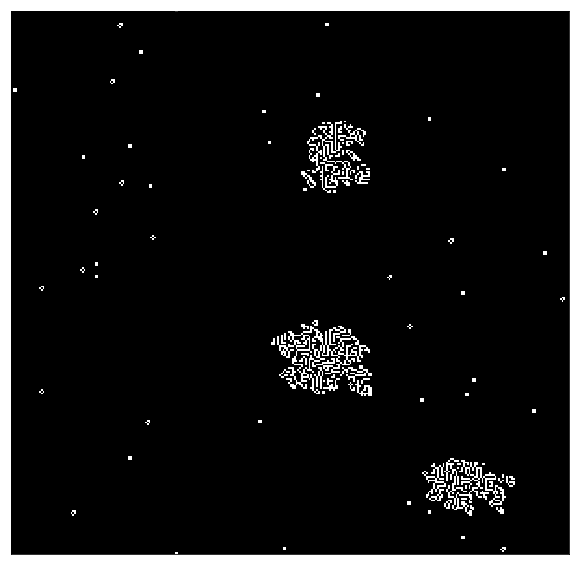

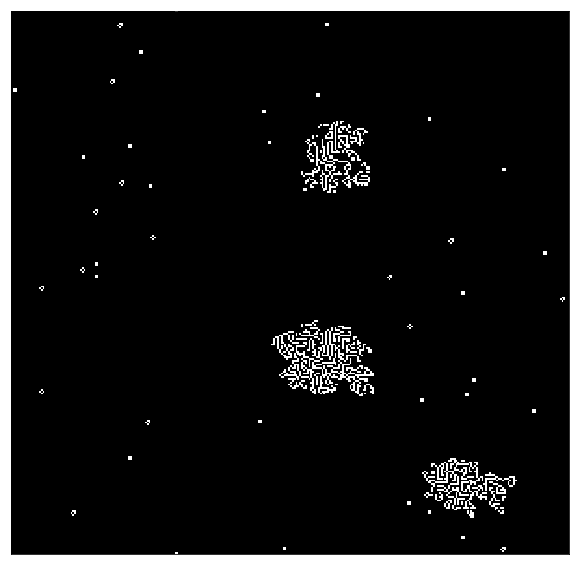

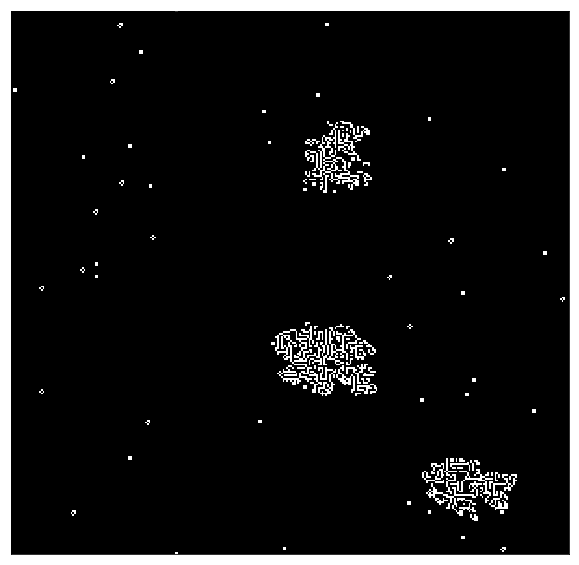

In [30]:
import imageio

gif_images = []
for i in tqdm(range(num_iters)):

    grid.plot().savefig(os.path.join(gif_images_path, f'{i}.png'))
    gif_images.append(imageio.imread(os.path.join(gif_images_path, f'{i}.png')))

    grid.one_time_step()

imageio.mimsave('single_game_of_life.gif', gif_images, duration=0.15)

![](single_game_of_life.gif)

## Examples

### Sanity Check

In [360]:
test_n_processes = 4
n_iterations = 100
grid_size = 300
grid_coef = 0.95
cells_path = 'sane_cells'
images_path = 'life_images_mpi'
exp_name = 'sane'

if os.path.exists(cells_path):
    os.remove(cells_path)
    
os.system(f'mpirun -n {test_n_processes} python mpi_life.py -images_path={images_path} -cells_path={cells_path} -grid_coef={grid_coef} -grid_size={grid_size} -n_iterations={n_iterations}')

0

100%|██████████| 100/100 [00:12<00:00,  8.38it/s]


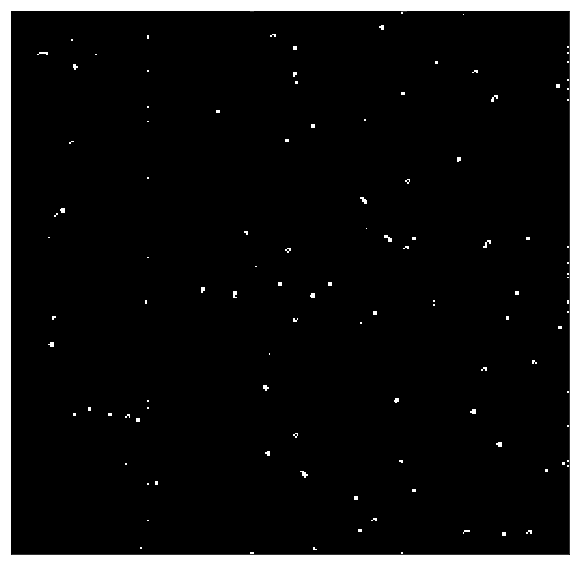

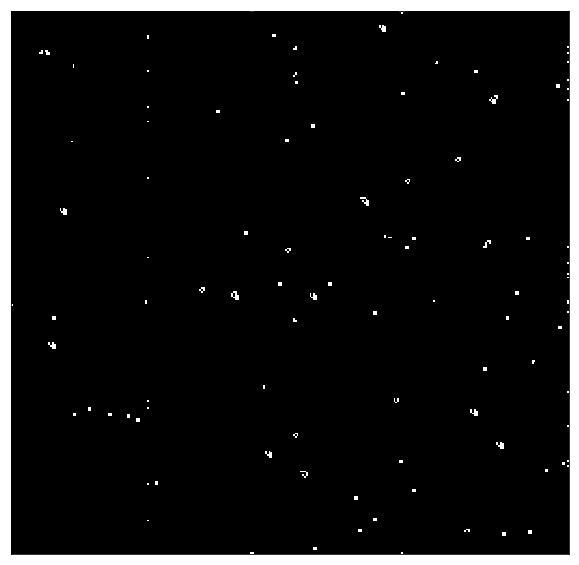

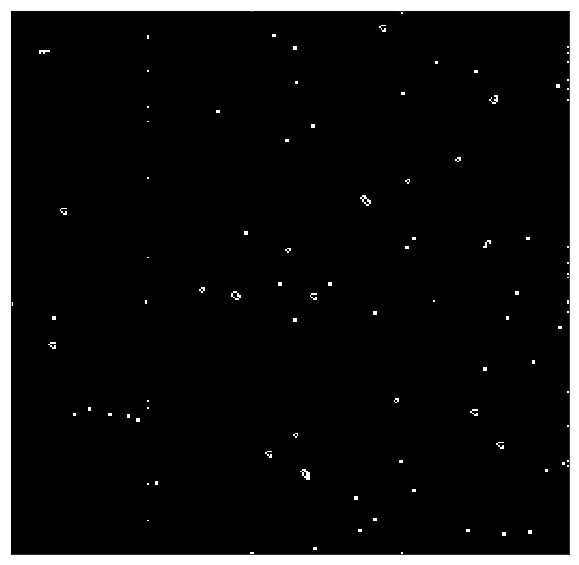

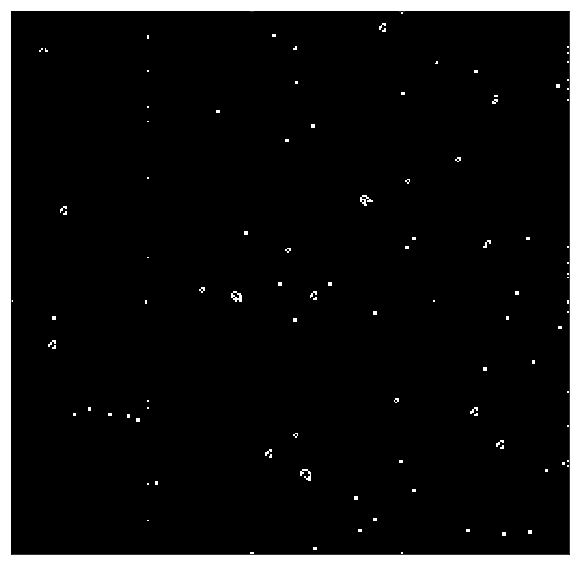

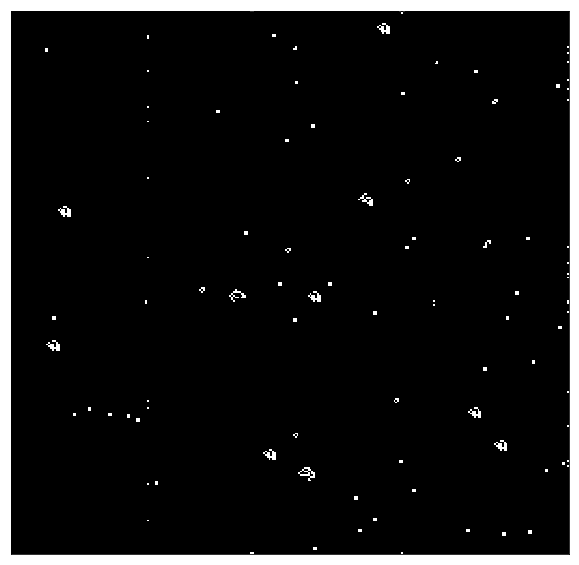

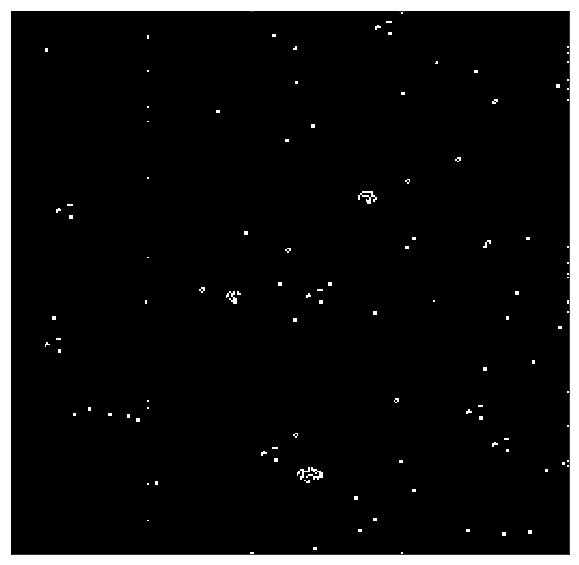

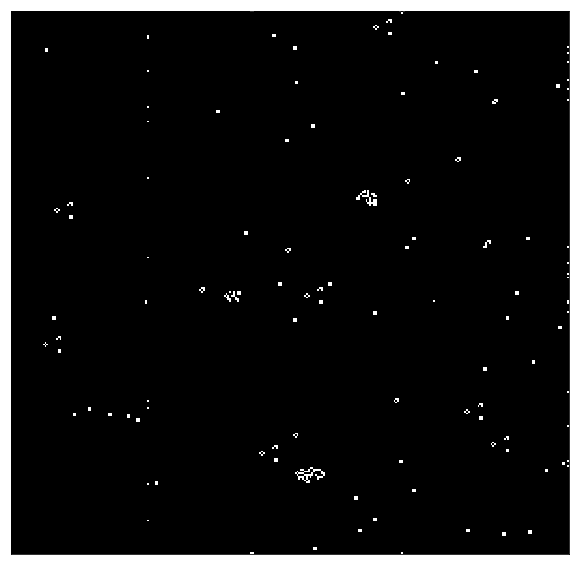

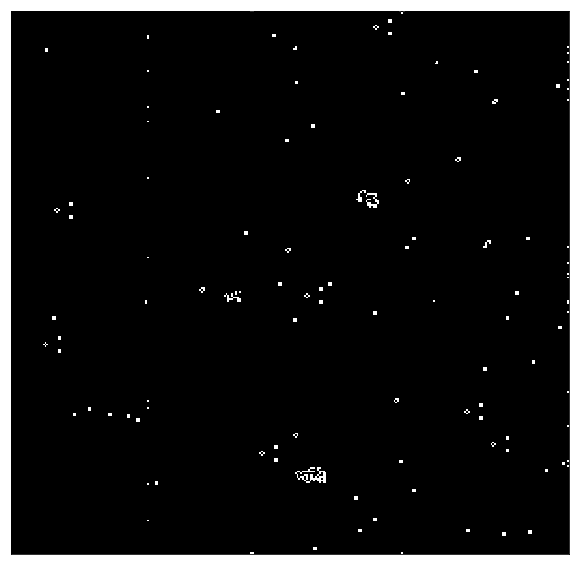

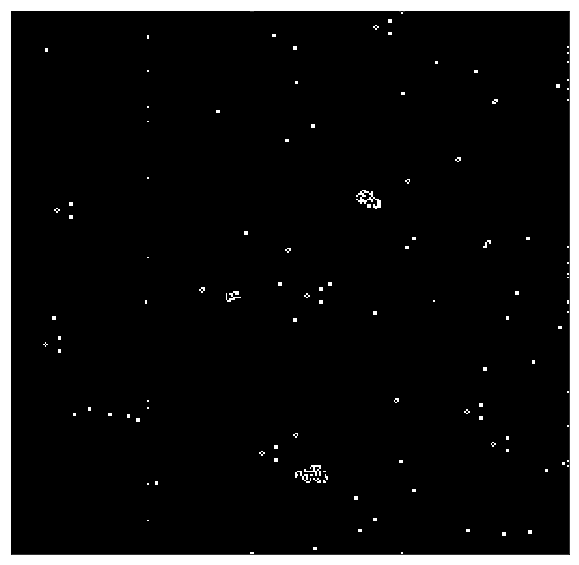

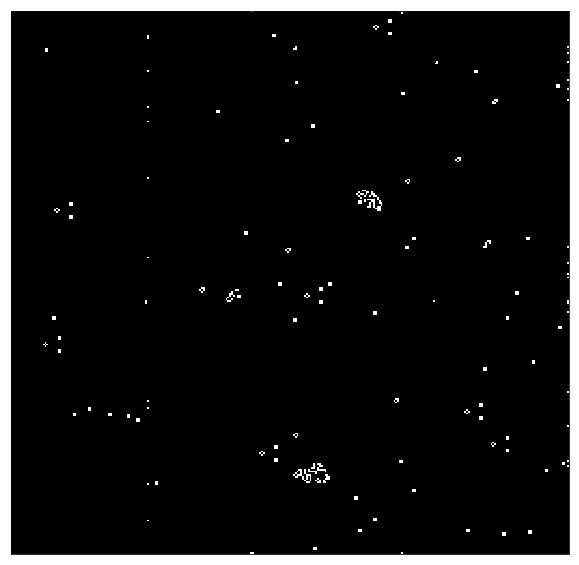

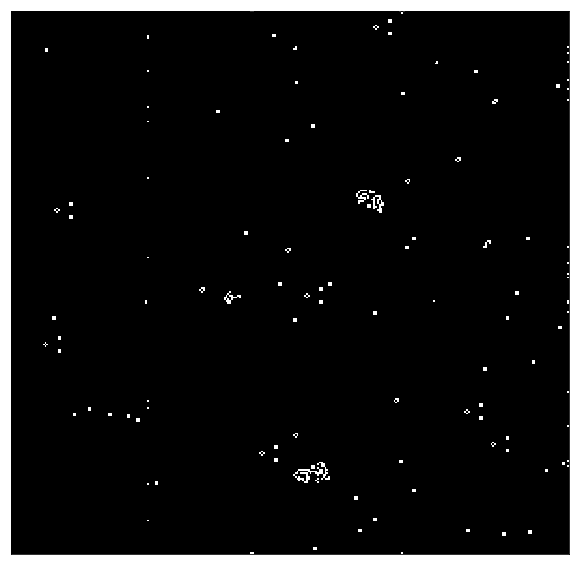

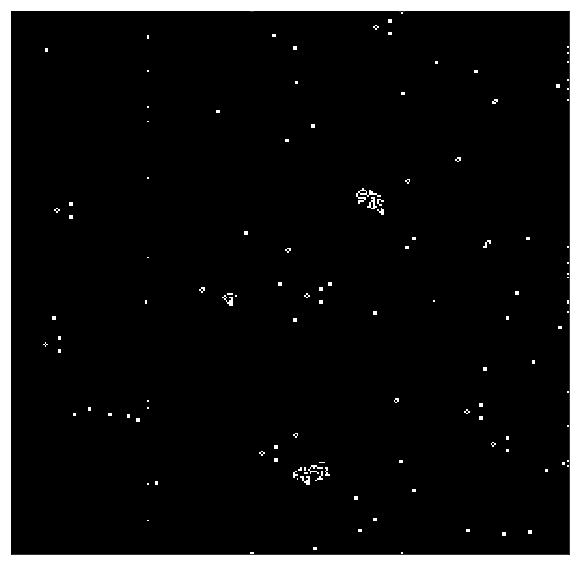

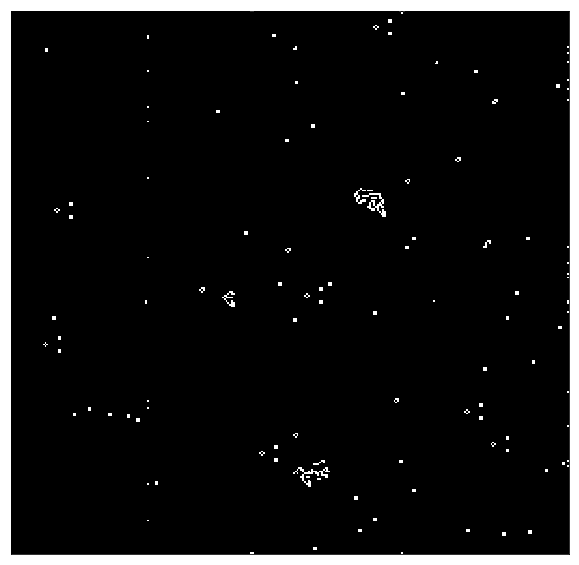

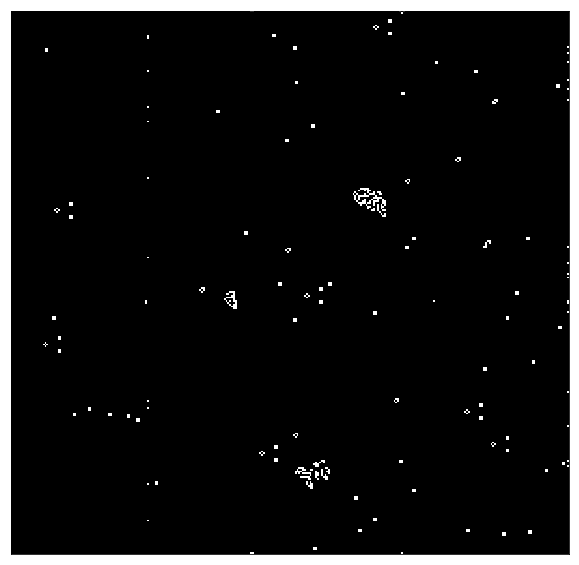

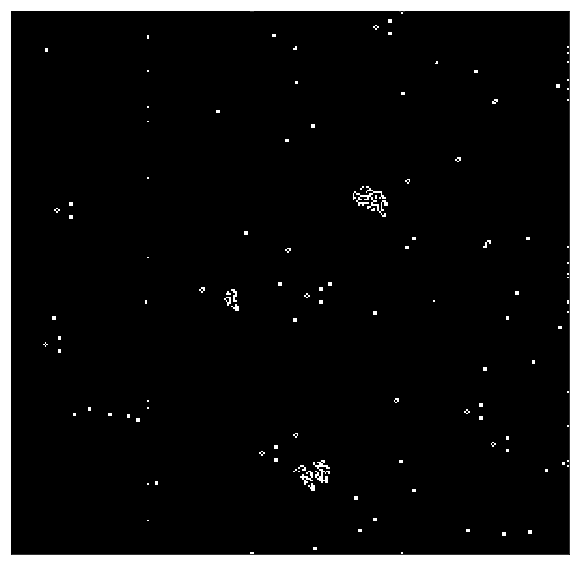

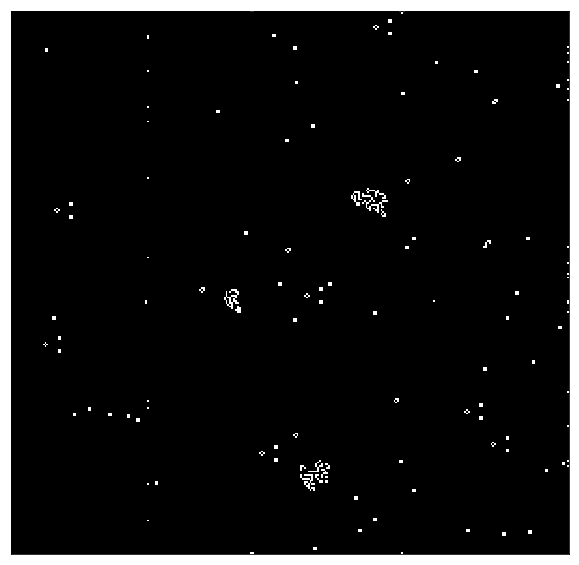

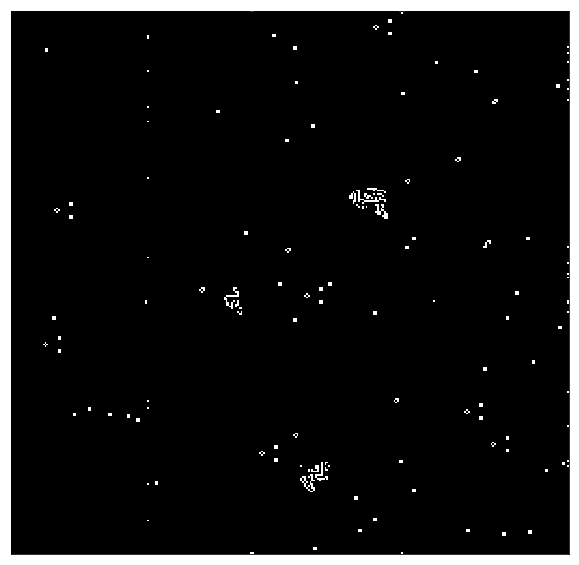

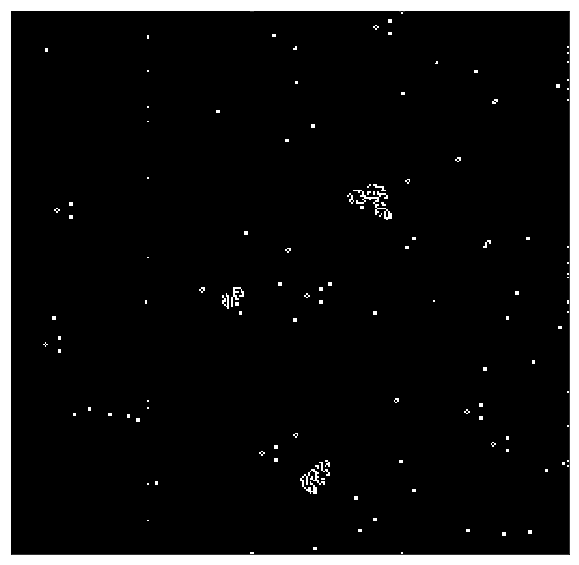

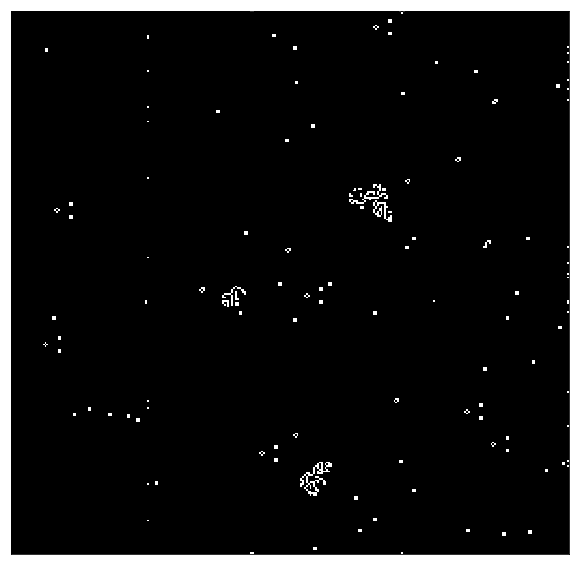

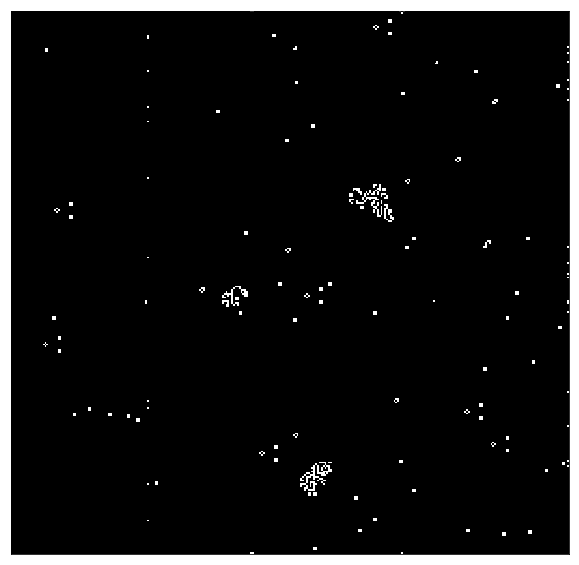

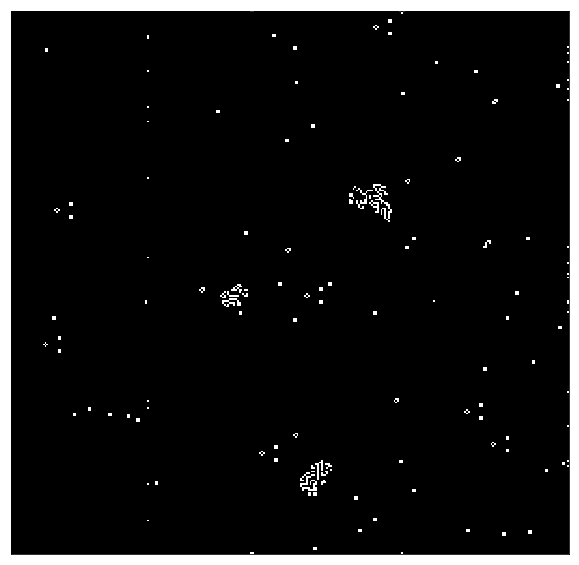

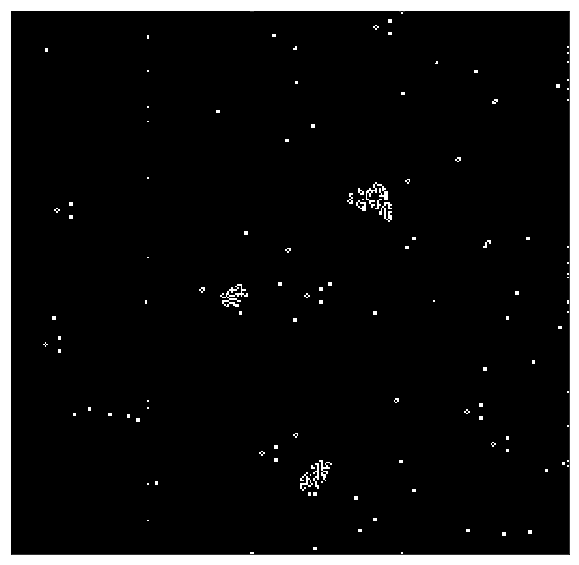

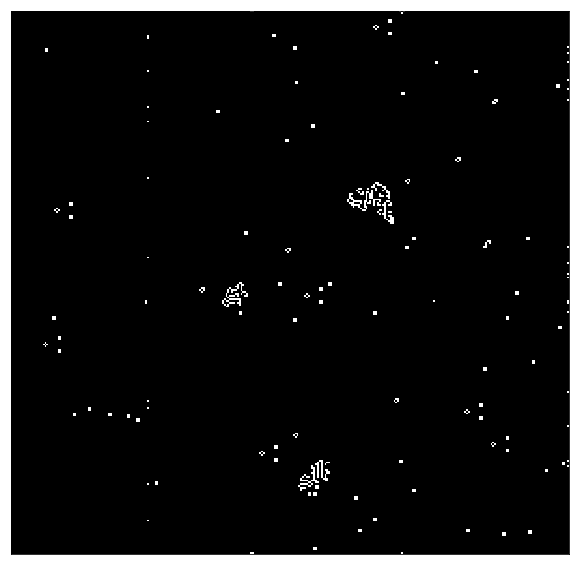

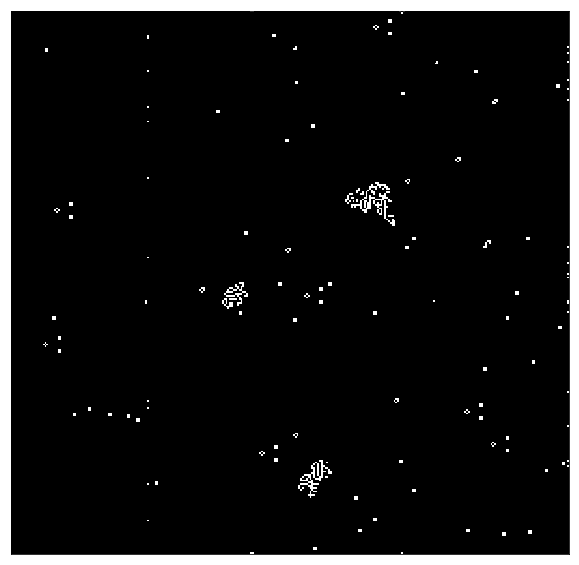

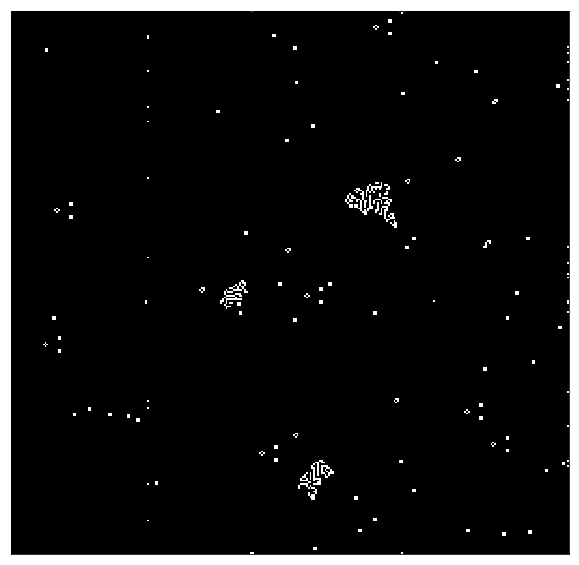

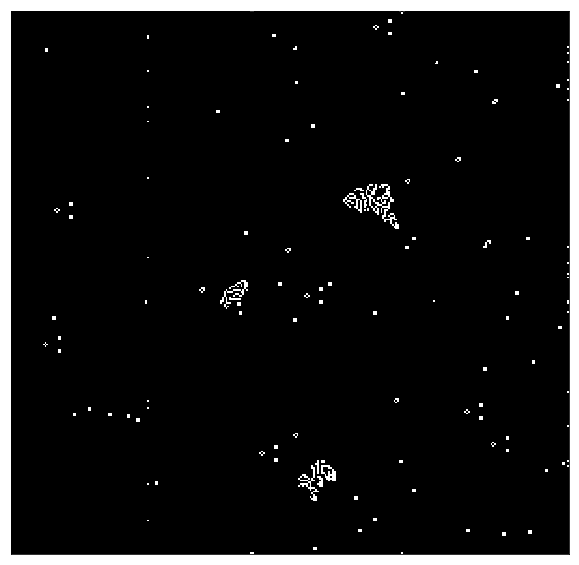

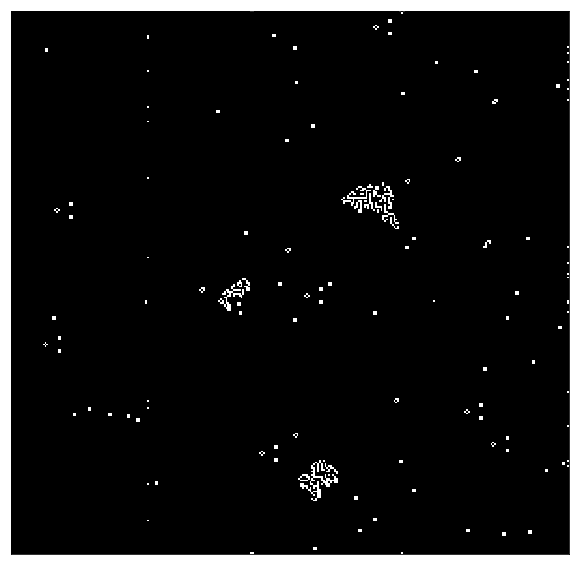

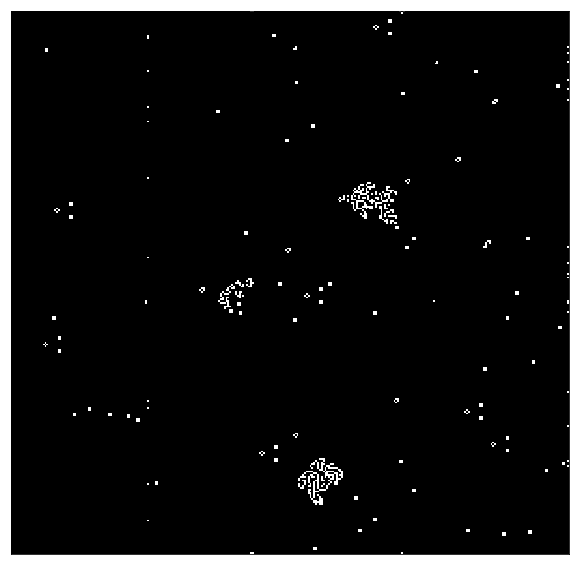

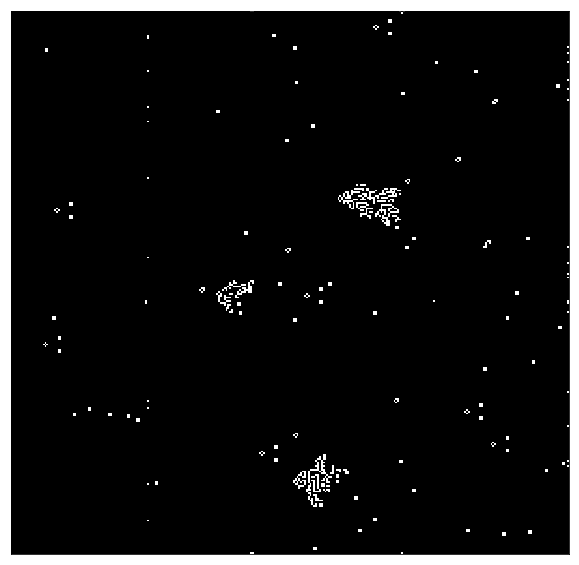

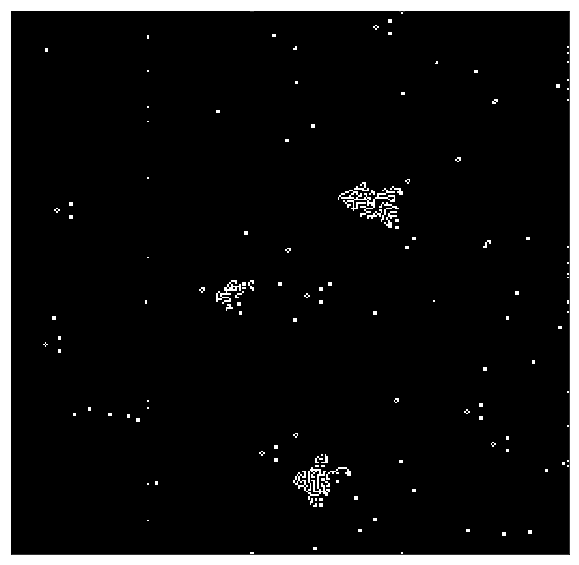

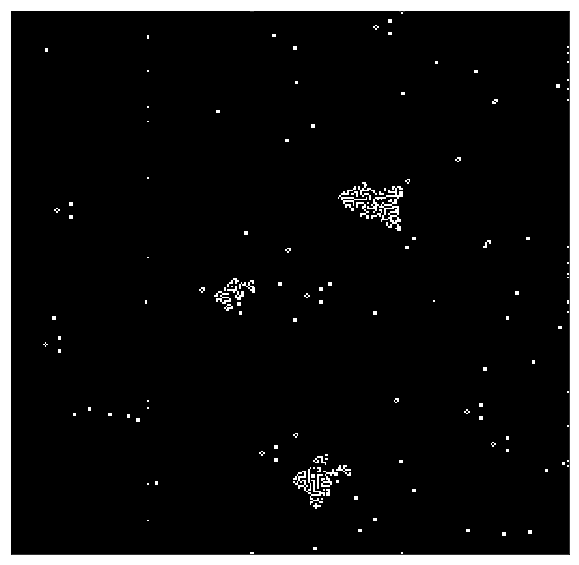

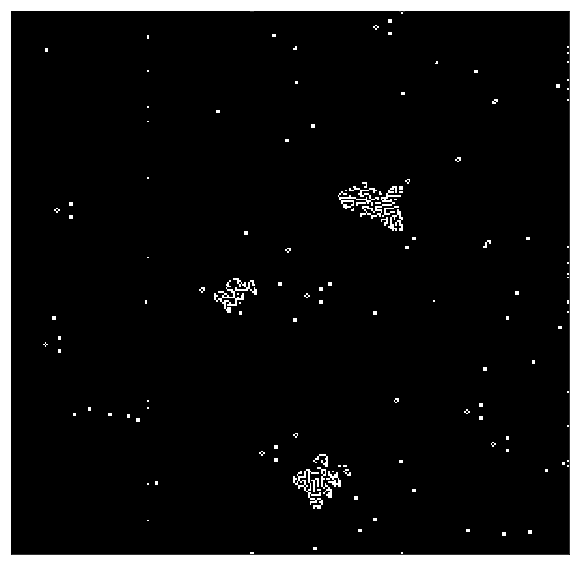

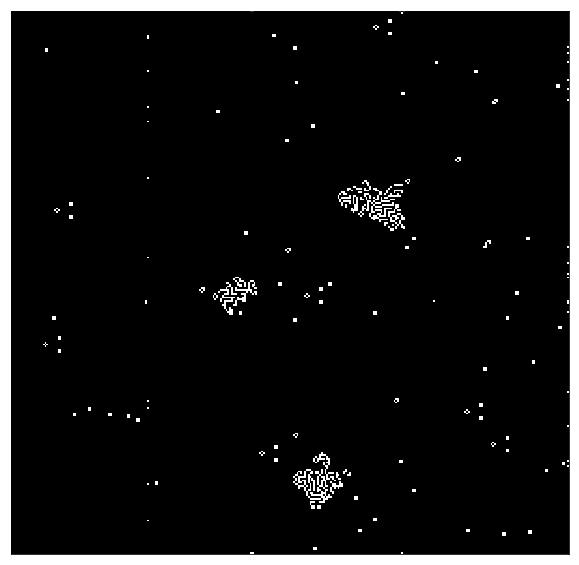

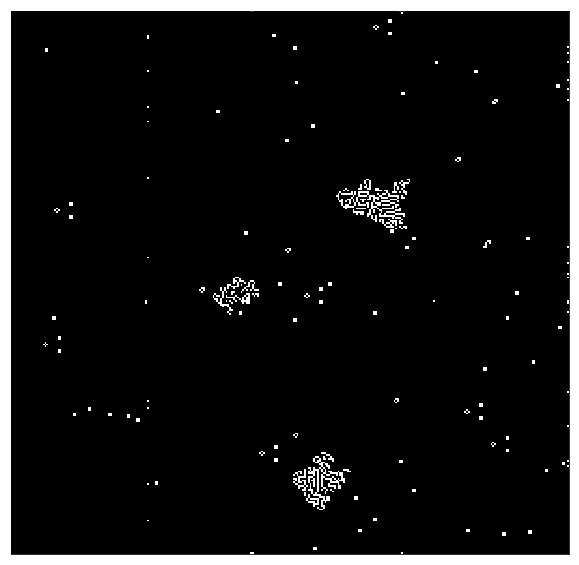

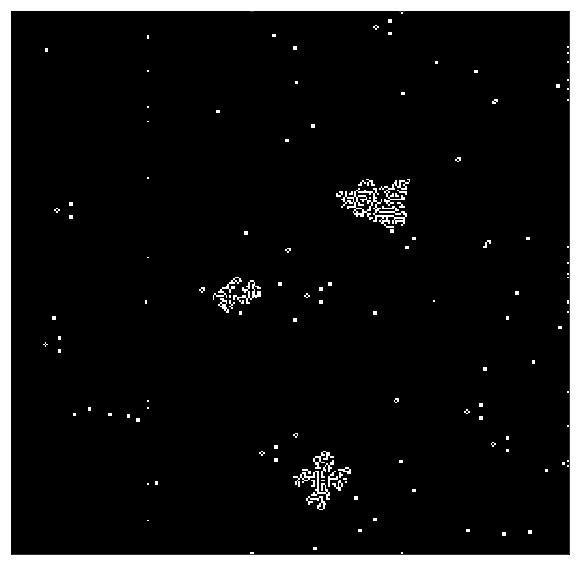

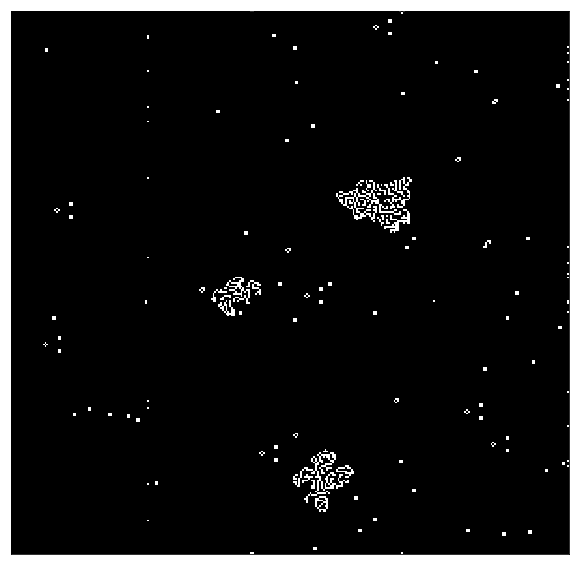

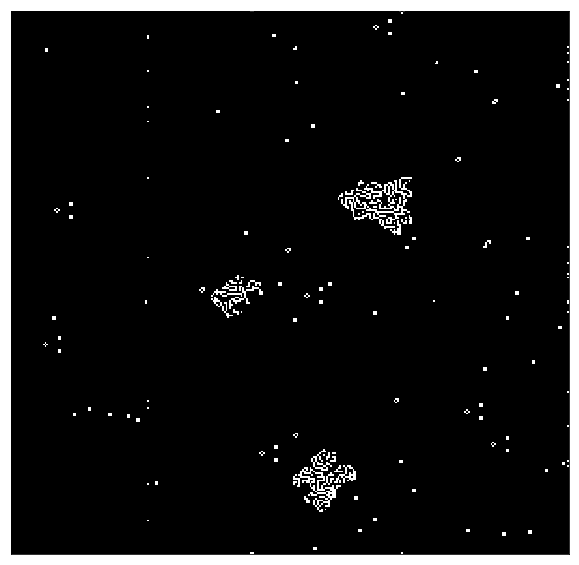

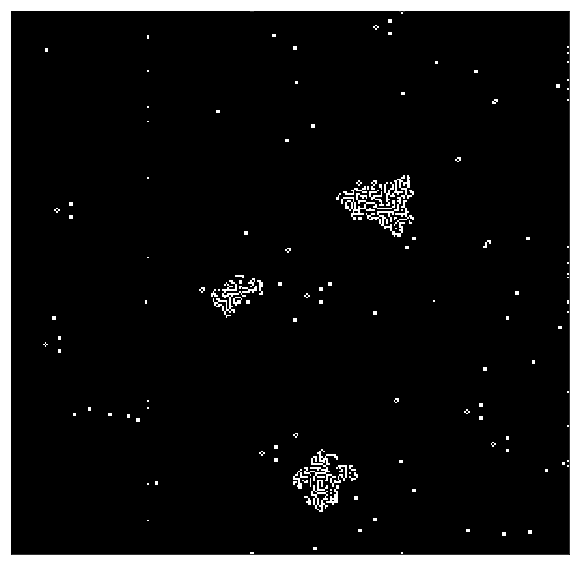

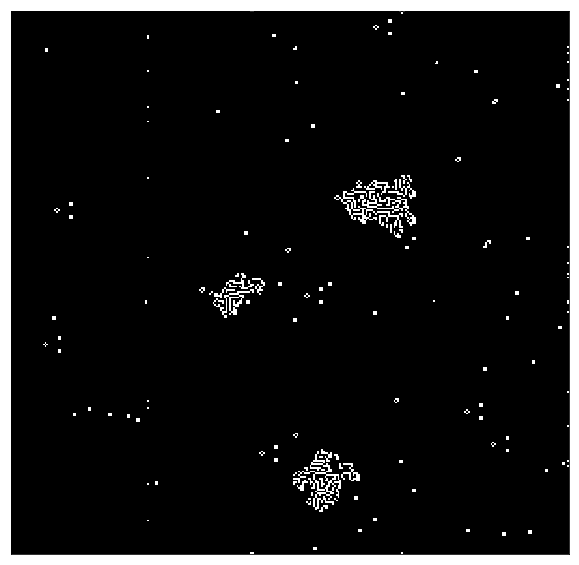

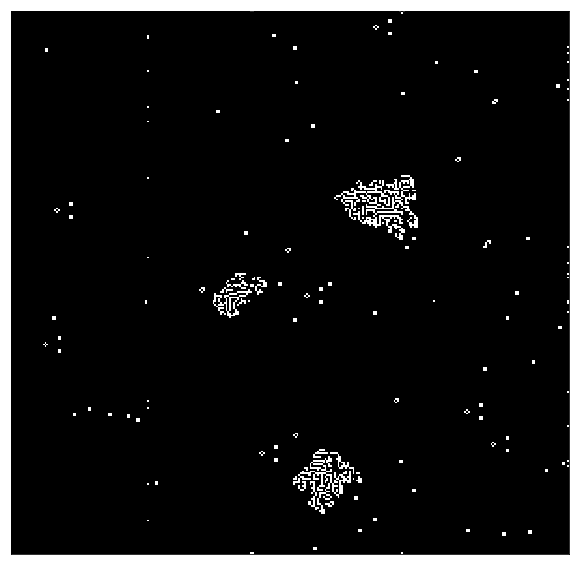

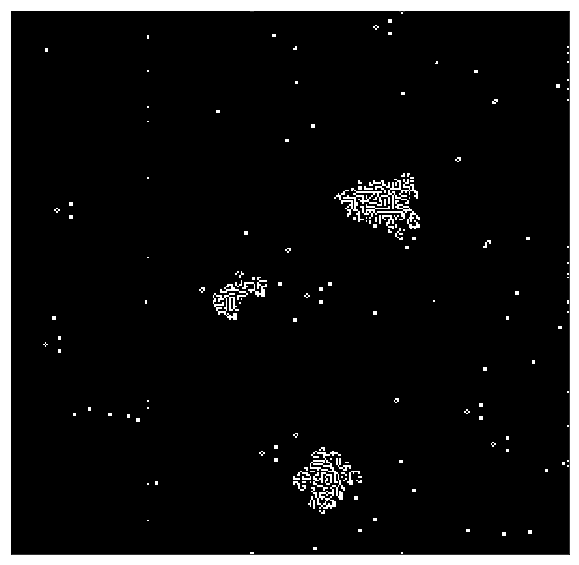

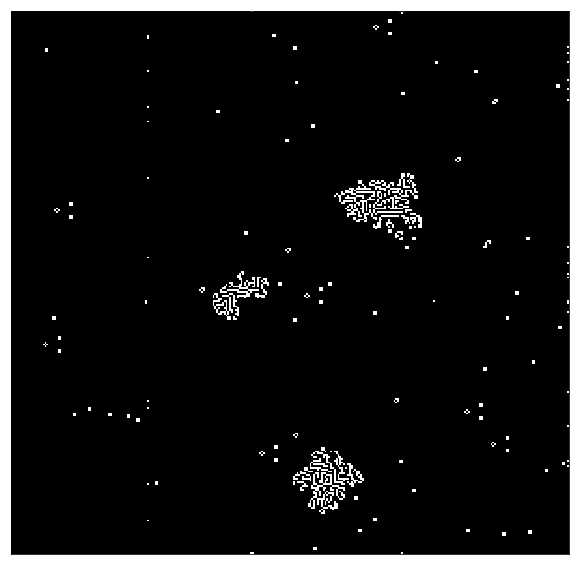

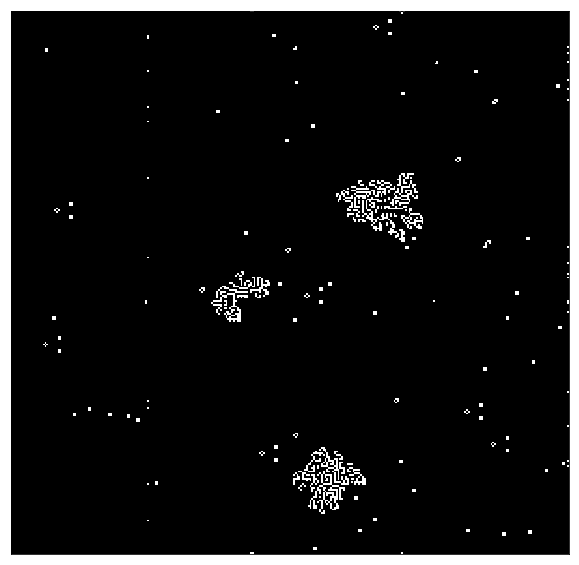

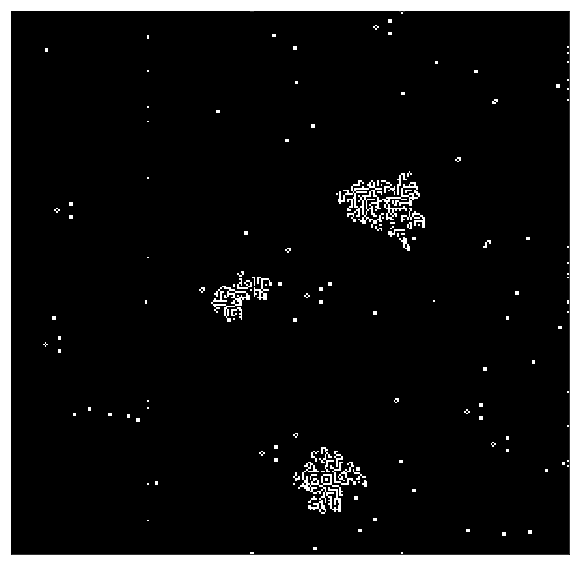

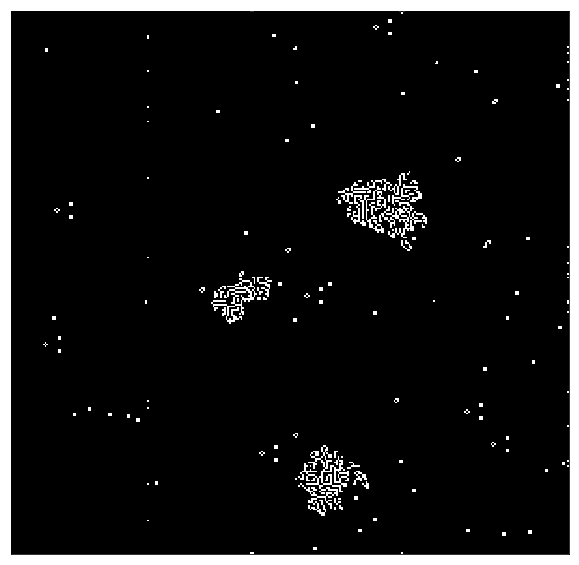

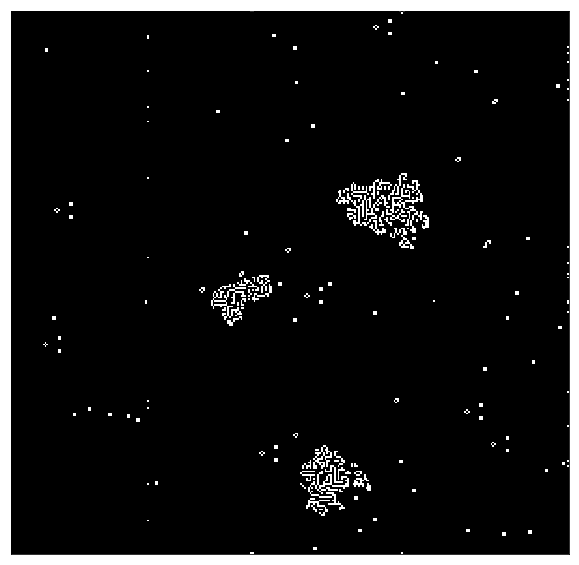

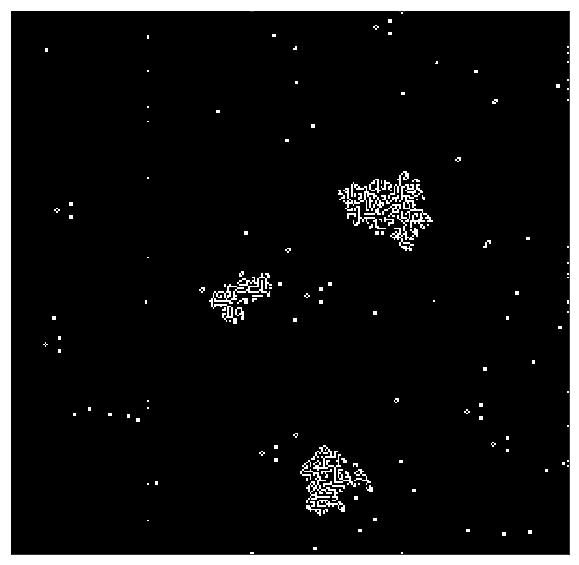

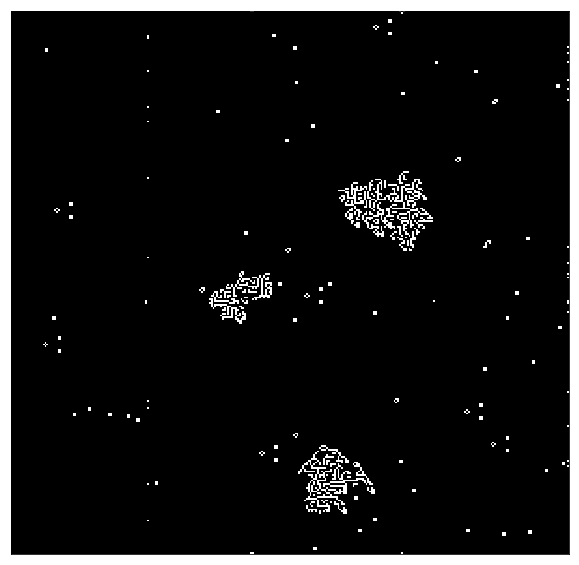

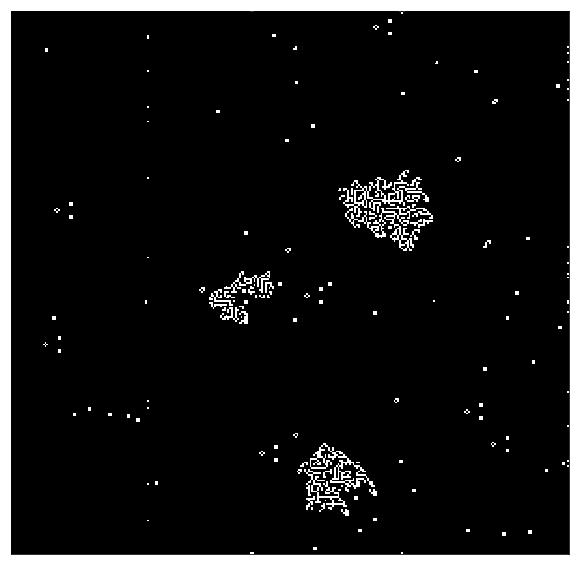

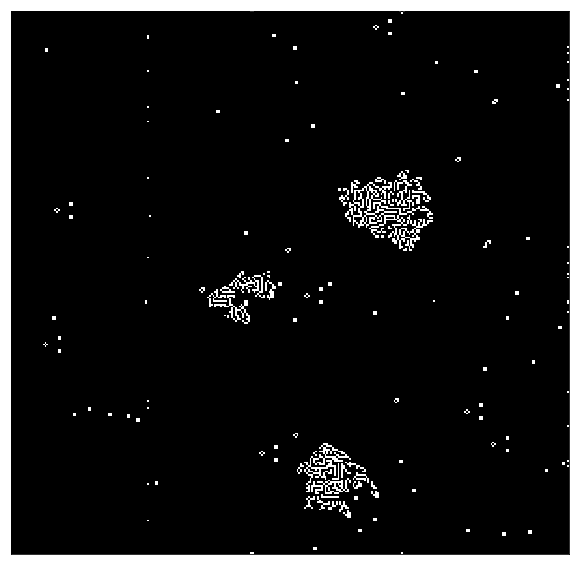

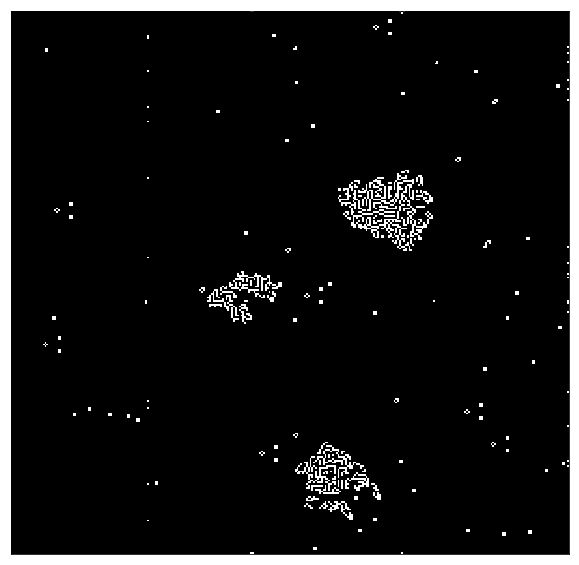

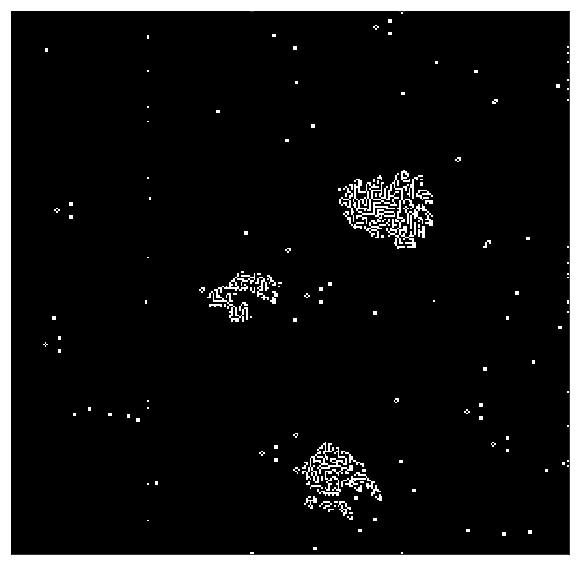

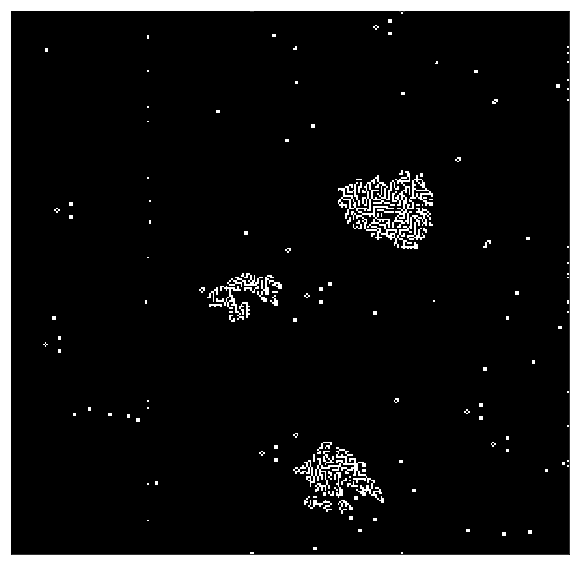

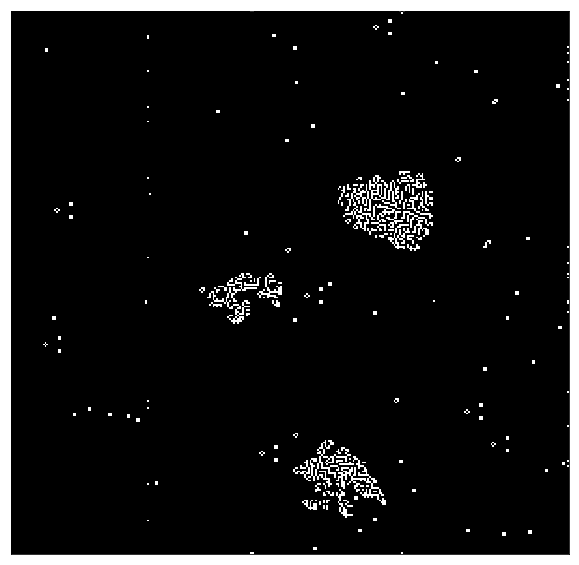

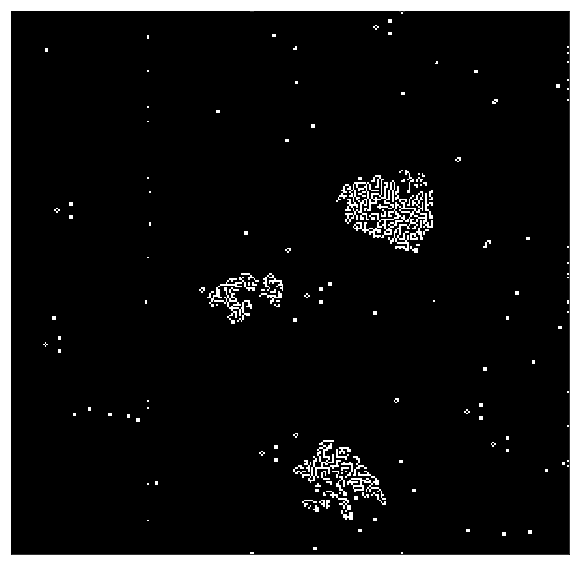

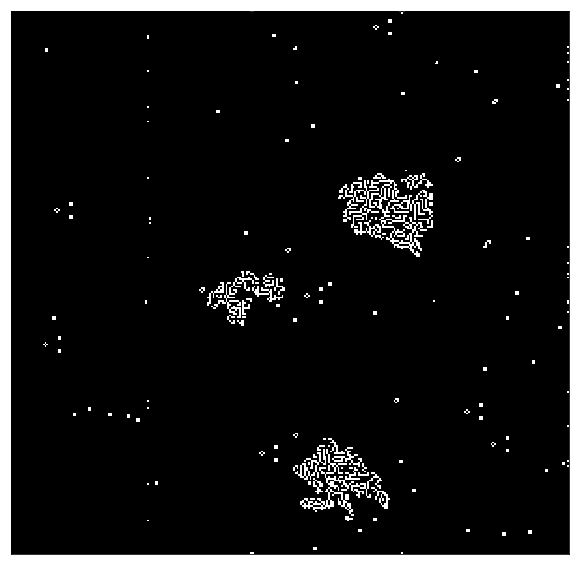

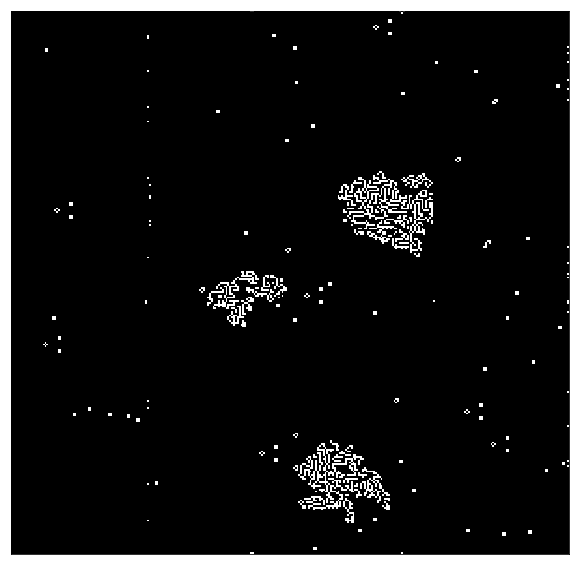

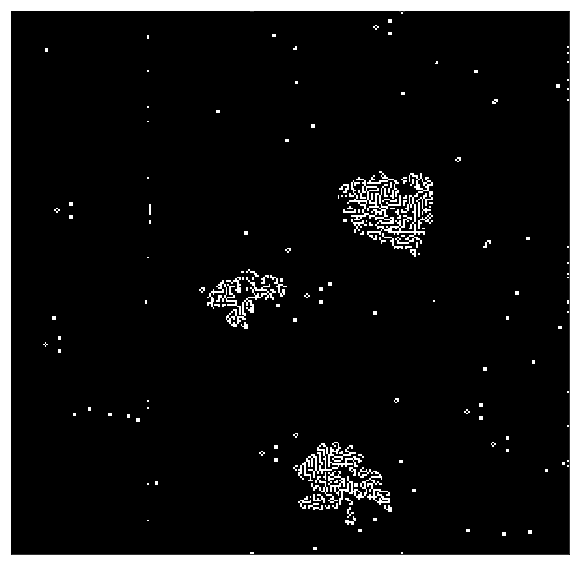

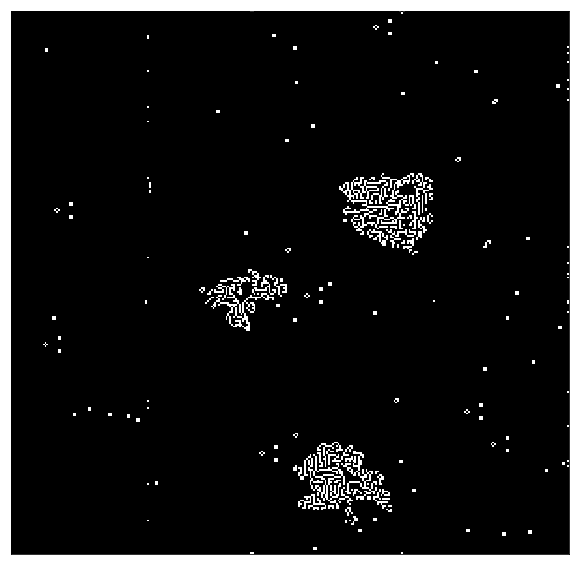

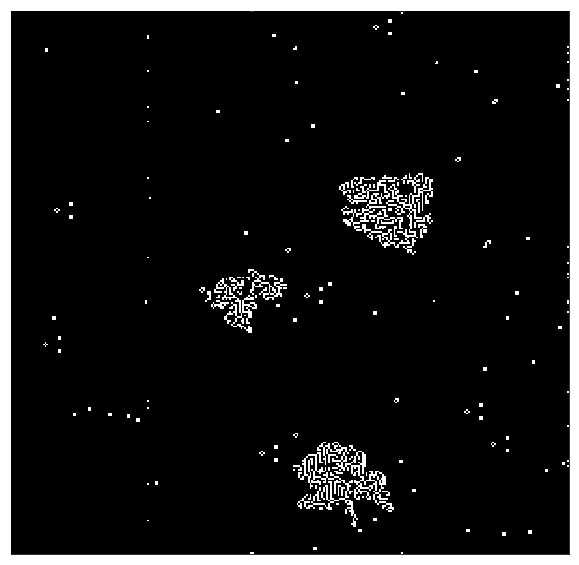

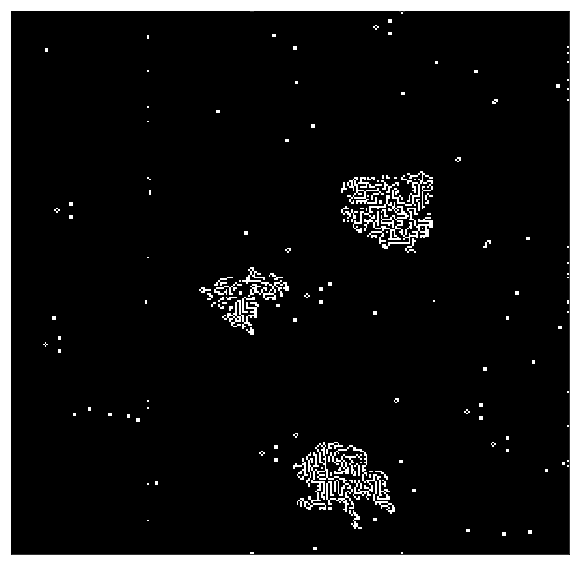

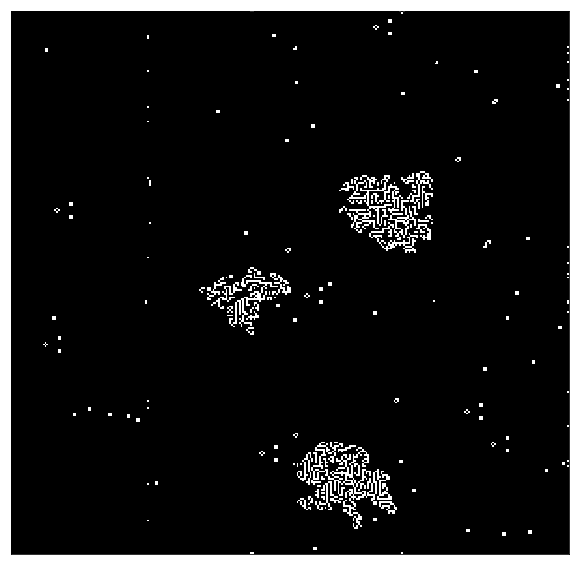

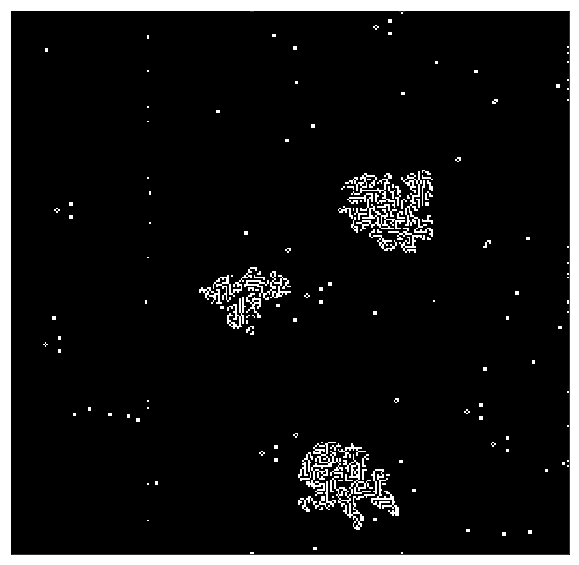

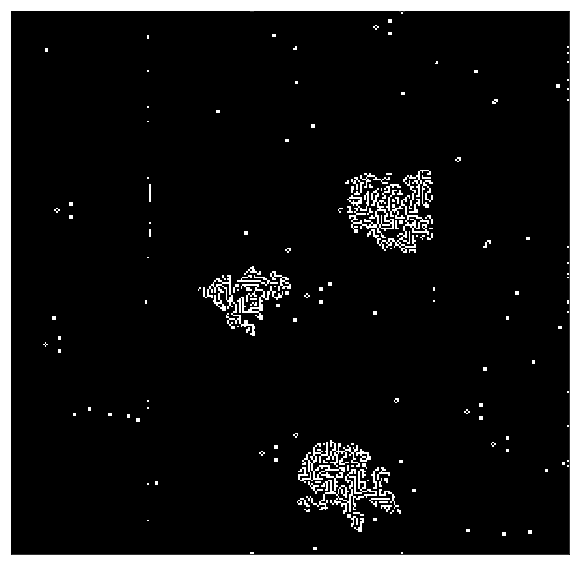

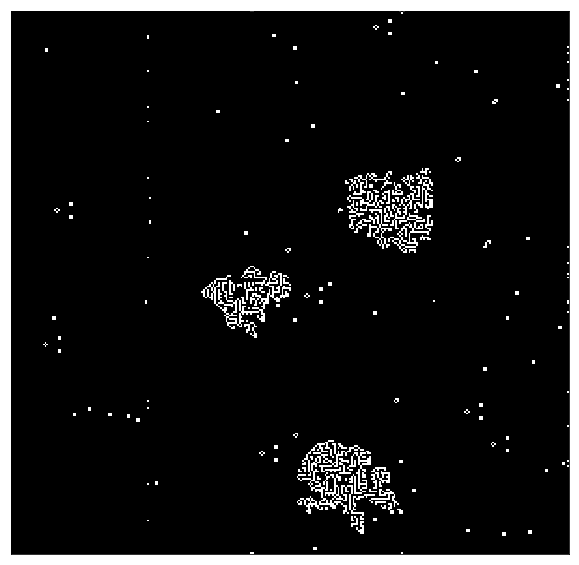

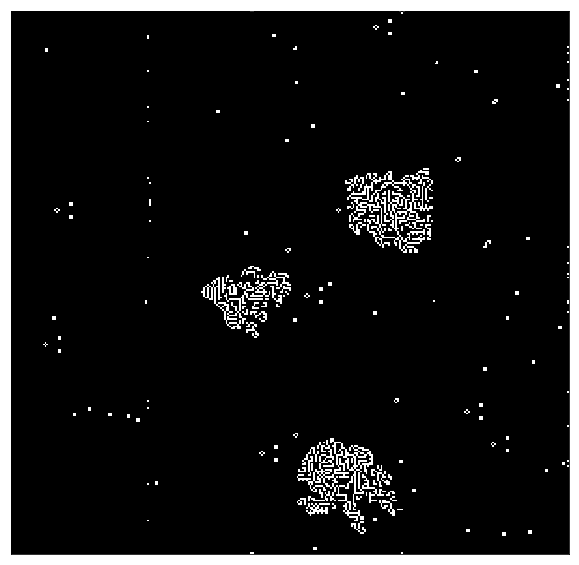

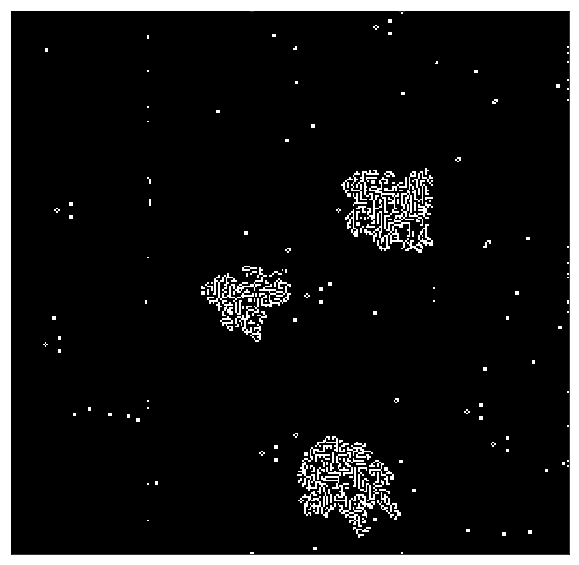

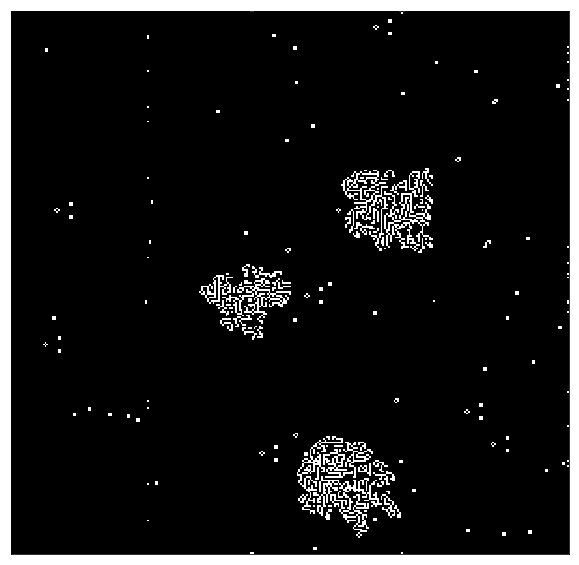

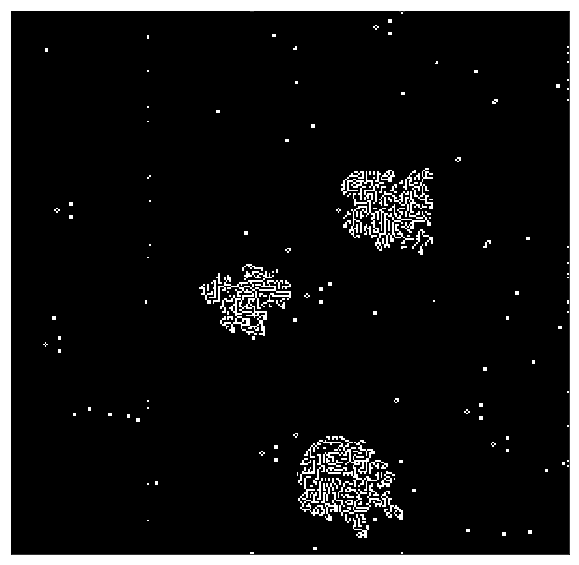

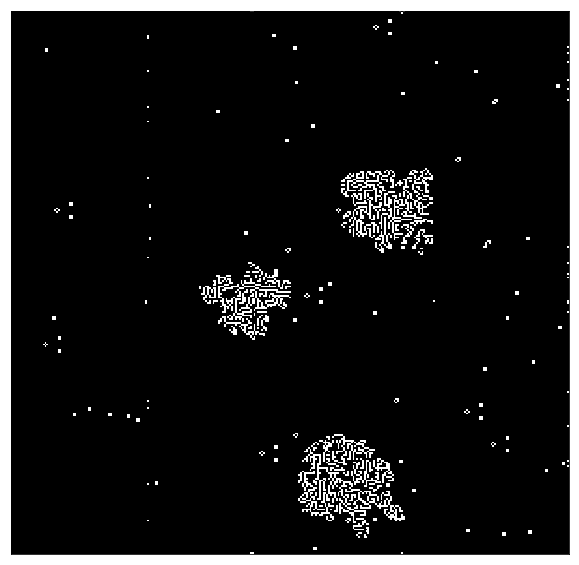

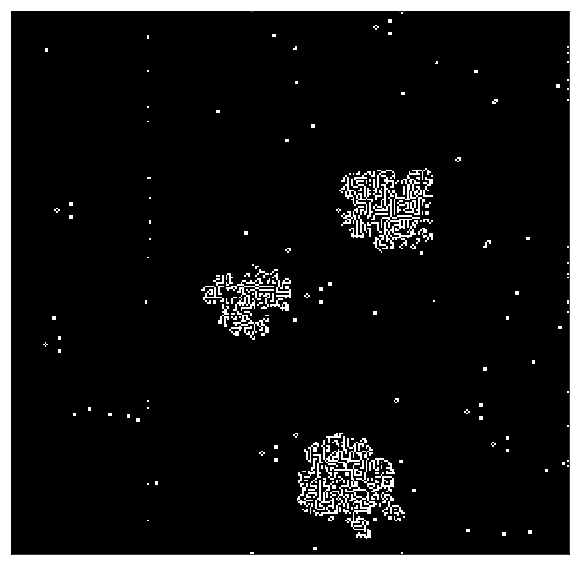

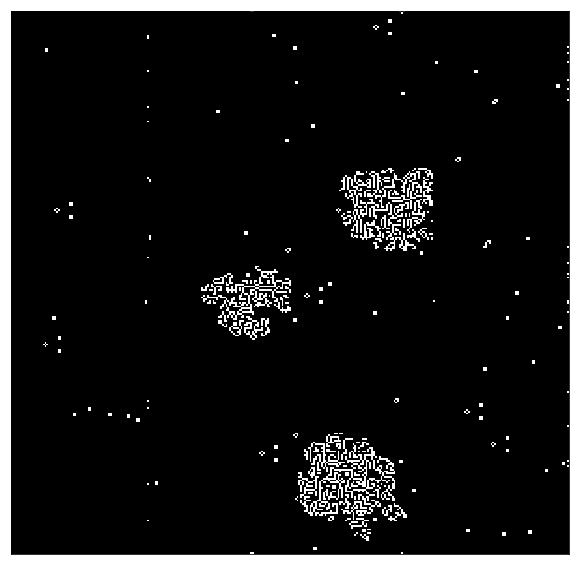

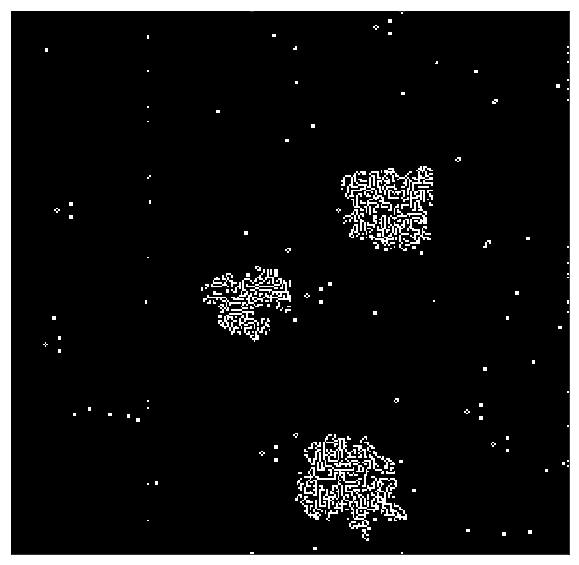

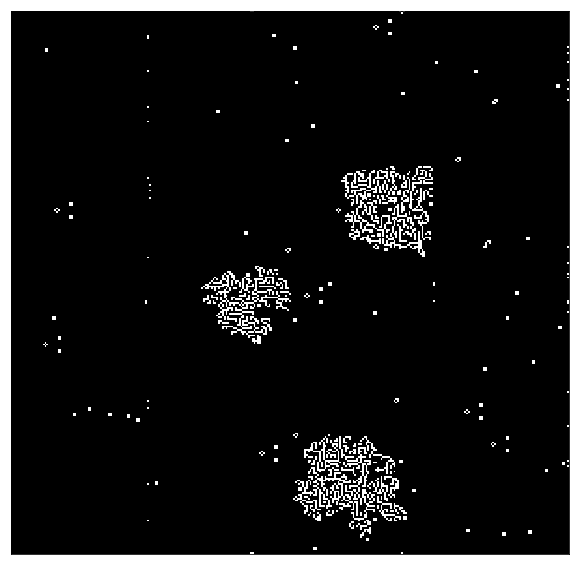

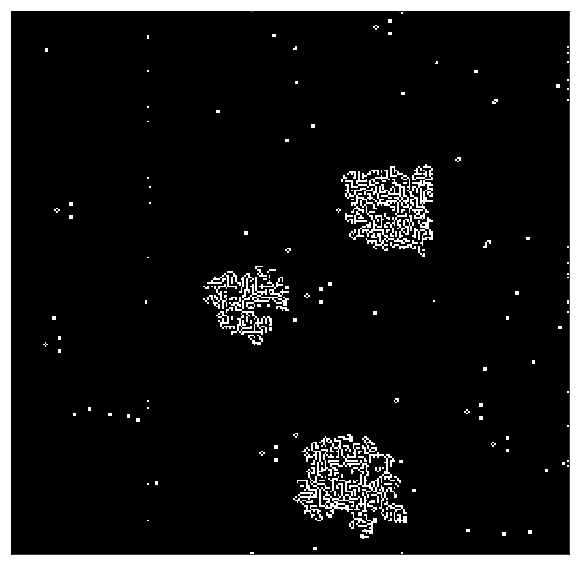

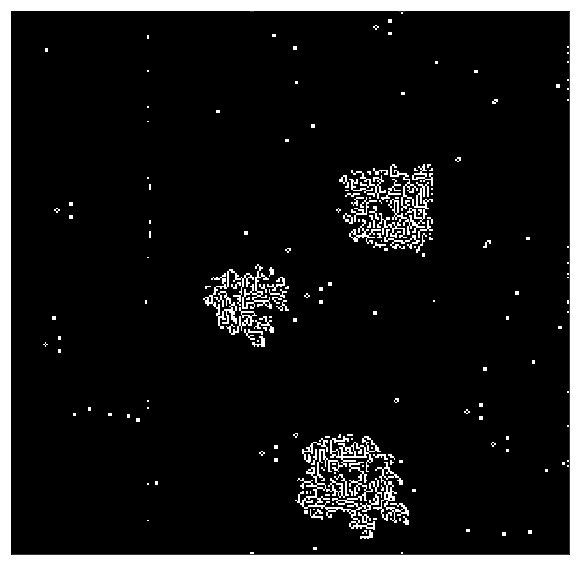

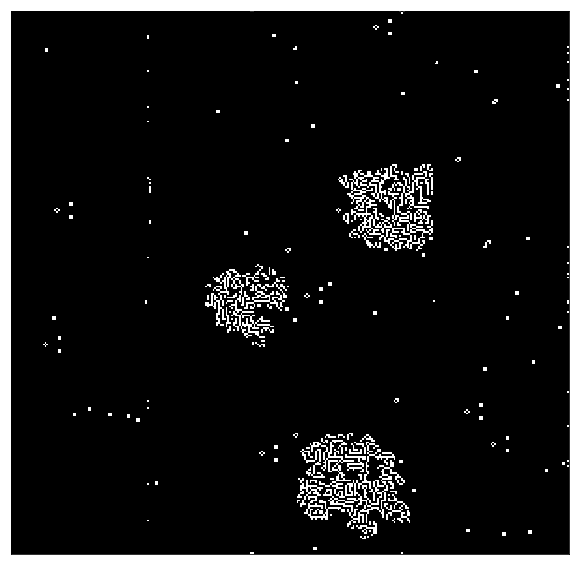

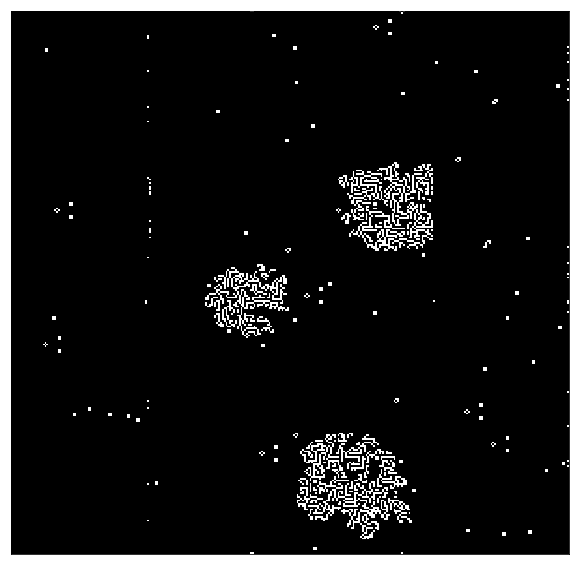

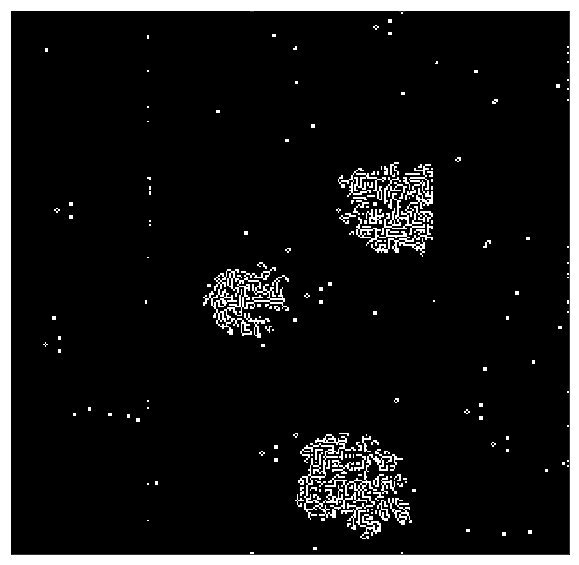

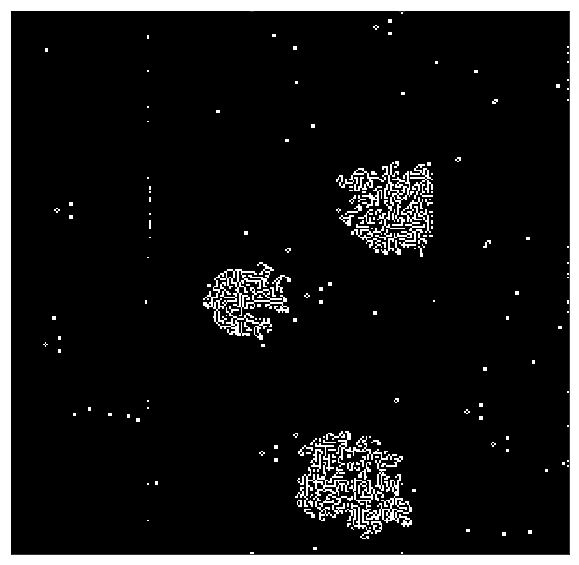

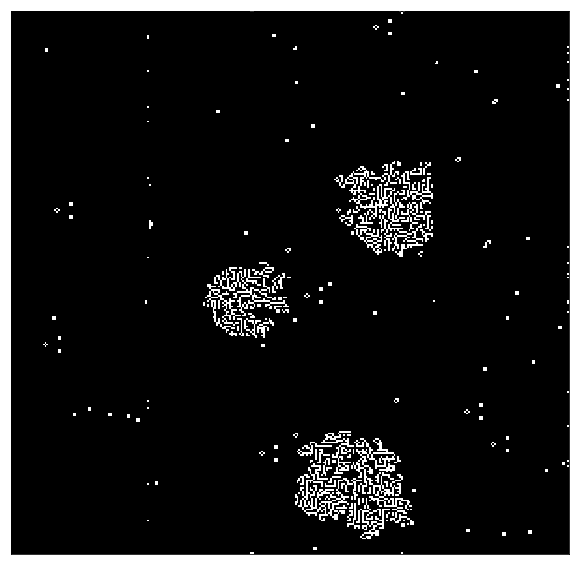

In [361]:
gif_images = []
gif_images_path = os.path.join(images_path, 'gif')

if os.path.exists(gif_images_path):
    os.system(f'rm -rf {gif_images_path}/*')
else:
    os.makedirs(gif_images_path)

for i in tqdm(range(n_iterations)):
        parts = [np.load(os.path.join(images_path, f'{j}_{i}.npy')) for j in range(test_n_processes)]

        joined_img = parts[0]
        for part in parts[1:]:
            joined_img = np.hstack((joined_img[:, 1:-1], part[:, 1:-1]))
                
        joined_img = plot_image(joined_img)
        joined_img.savefig(os.path.join(gif_images_path, f'{i}.png'))
        
        gif_images.append(imageio.imread(os.path.join(gif_images_path, f'{i}.png')))
    
imageio.mimsave(f'game_of_life_mpi_{exp_name}.gif', gif_images, duration=0.15)

![](game_of_life_mpi_sane.gif)

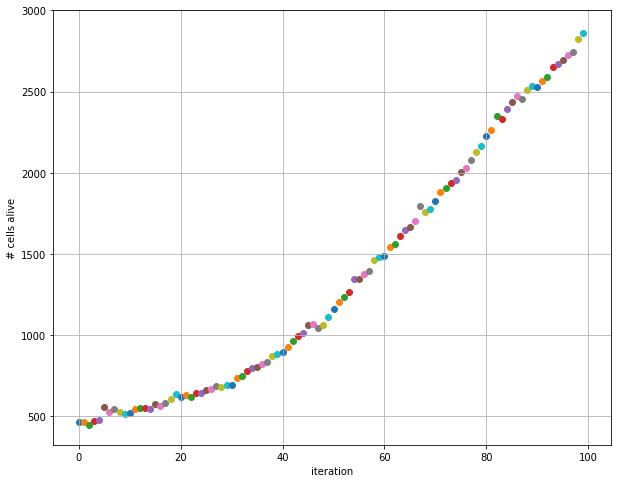

In [362]:
iter_cells = {}

with open(cells_path, 'r') as f:
    for line in f.readlines():
        iter, cells = line.strip().split()
        iter_cells[int(iter)] = float(cells)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for iter, cells in iter_cells.items():
    ax.scatter(iter, cells)

ax.grid()
ax.set_xlabel('iteration')
ax.set_ylabel('# cells alive')

fig.savefig(f'{exp_name}.png')

### And another example

In [357]:
test_n_processes = 5
n_iterations = 90
grid_size = 250
grid_coef = 0.5
cells_path = 'half_cells'
images_path = 'life_images_mpi_2'
exp_name = 'half_exp'

if os.path.exists(cells_path):
    os.remove(cells_path)
    
os.system(f'mpirun -n {test_n_processes} python mpi_life.py -images_path={images_path} -cells_path={cells_path} -grid_coef={grid_coef} -grid_size={grid_size} -n_iterations={n_iterations}')

0

 21%|██        | 19/90 [00:02<00:07,  9.00it/s]/home/sanityseeker/.local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 90/90 [00:11<00:00,  7.99it/s]


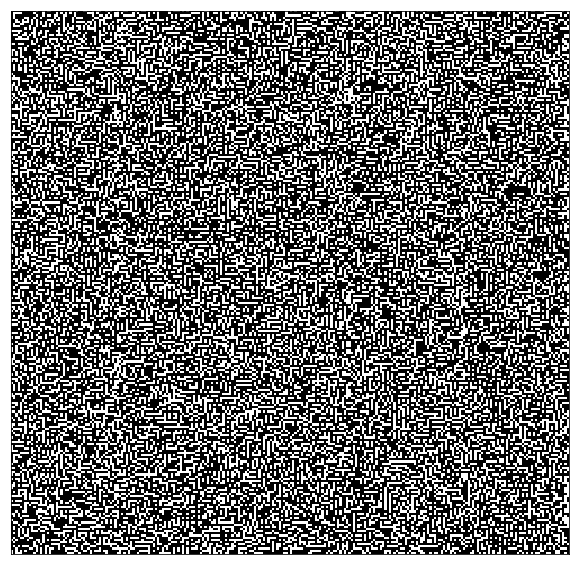

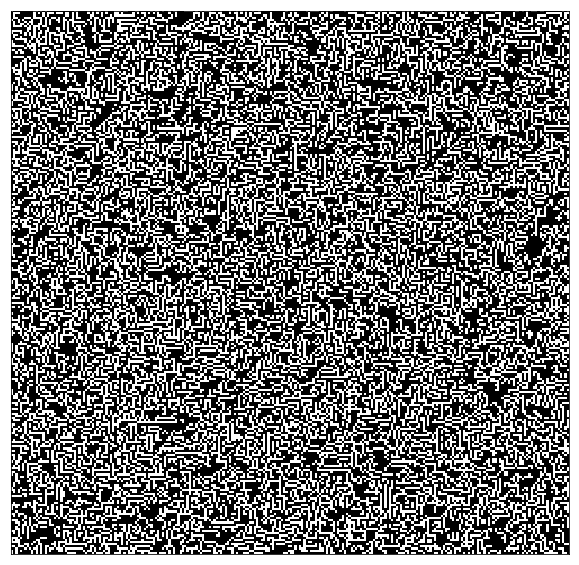

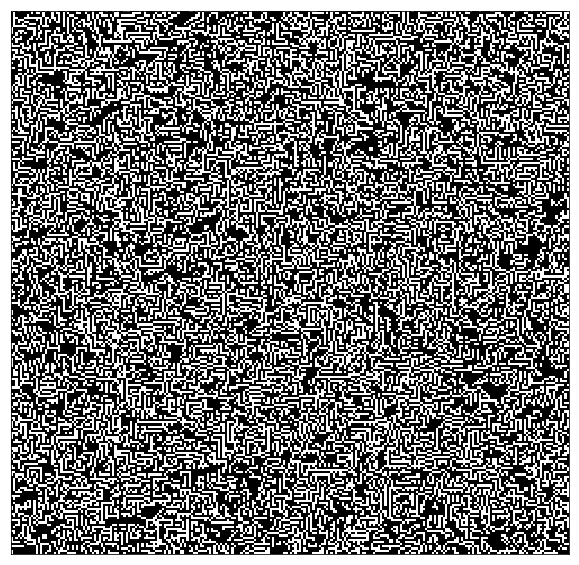

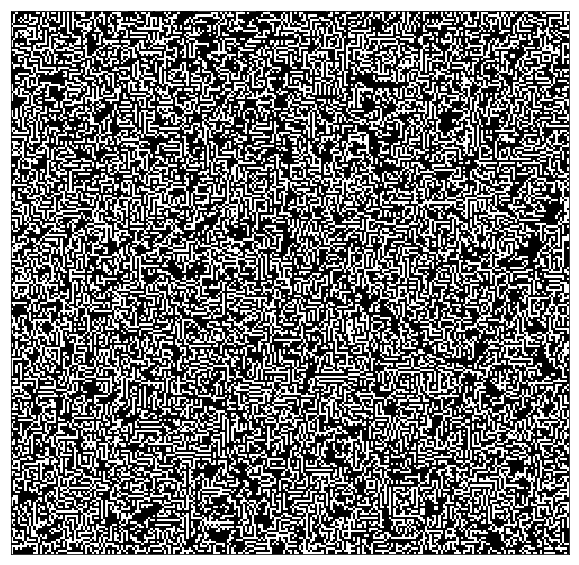

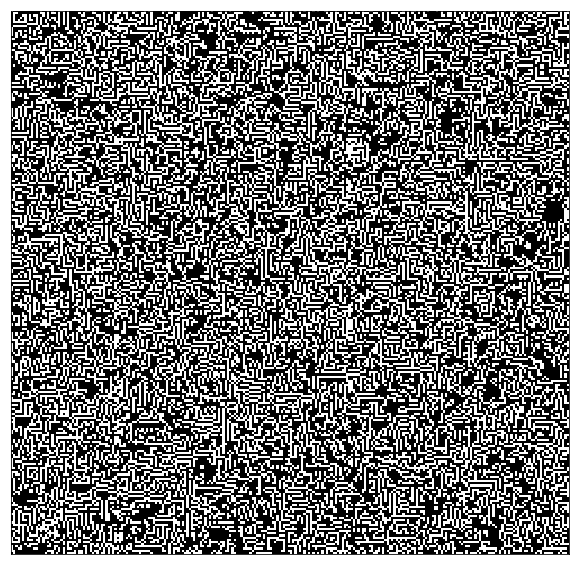

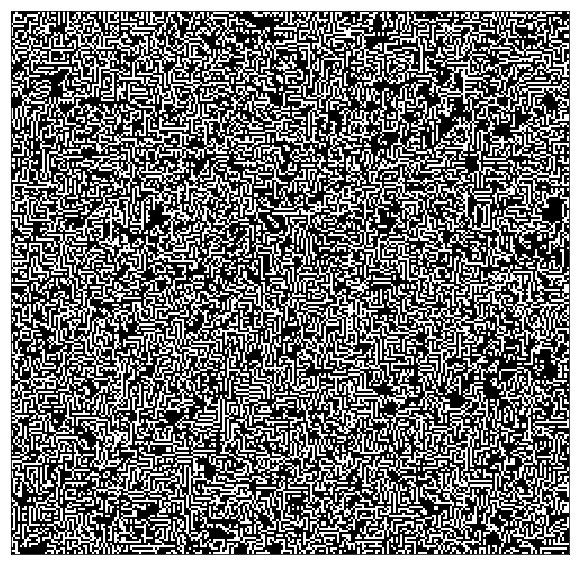

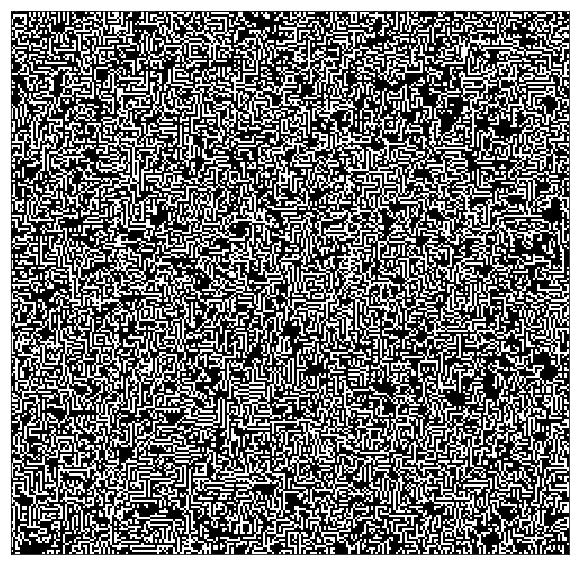

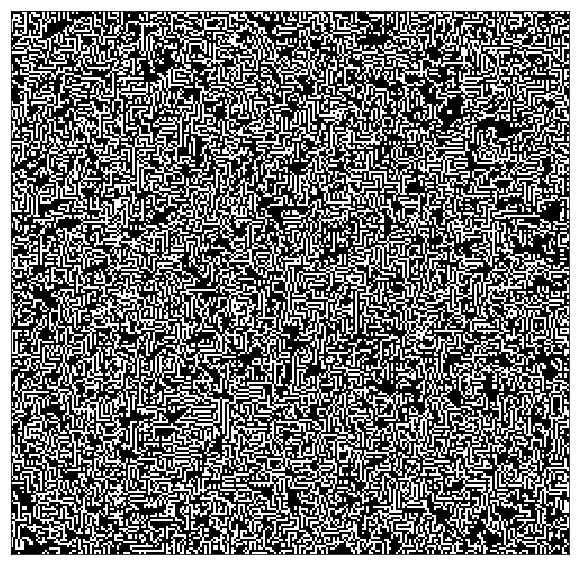

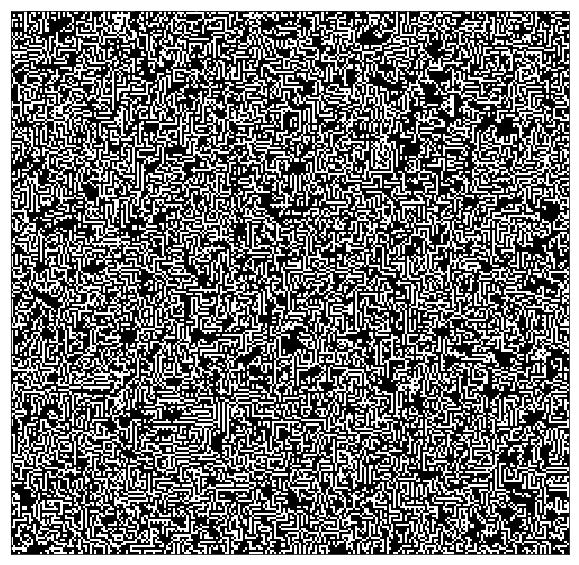

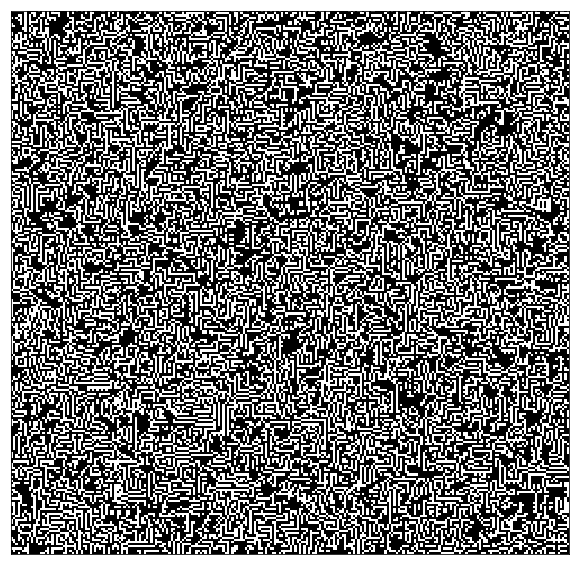

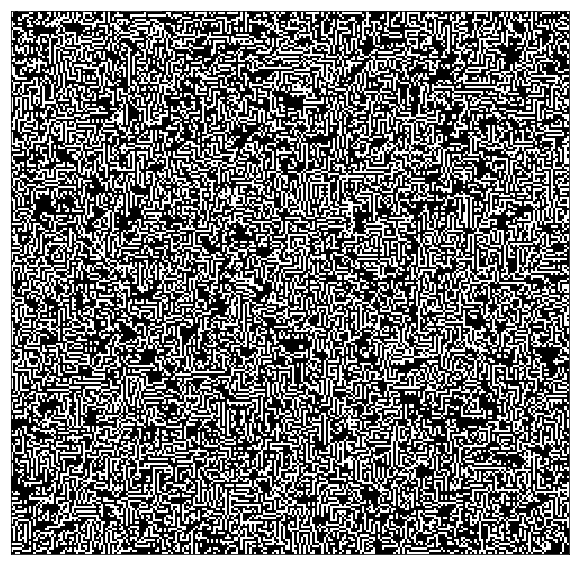

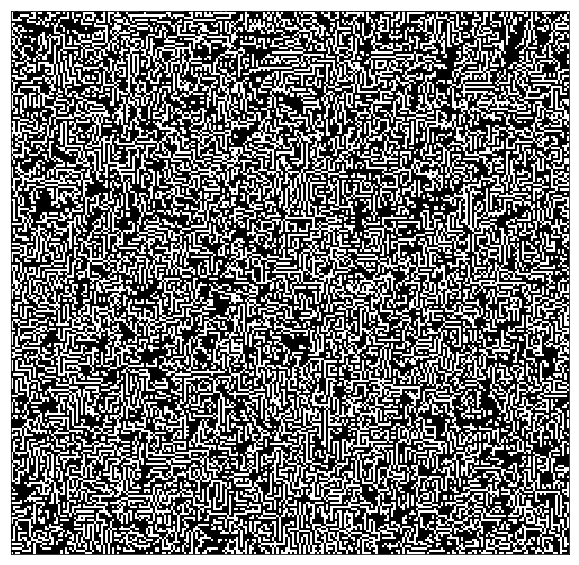

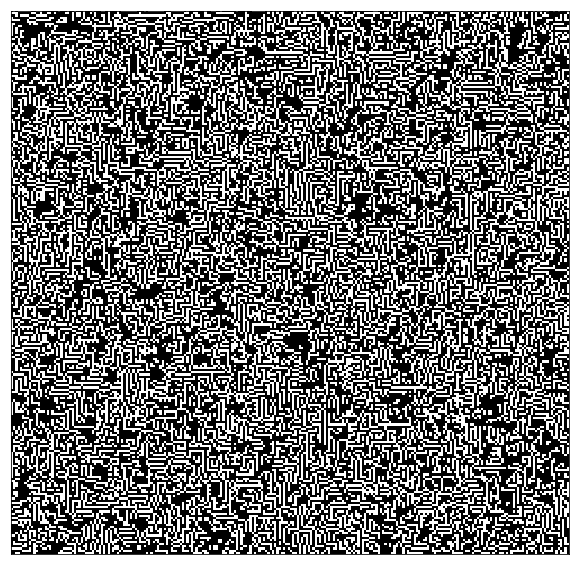

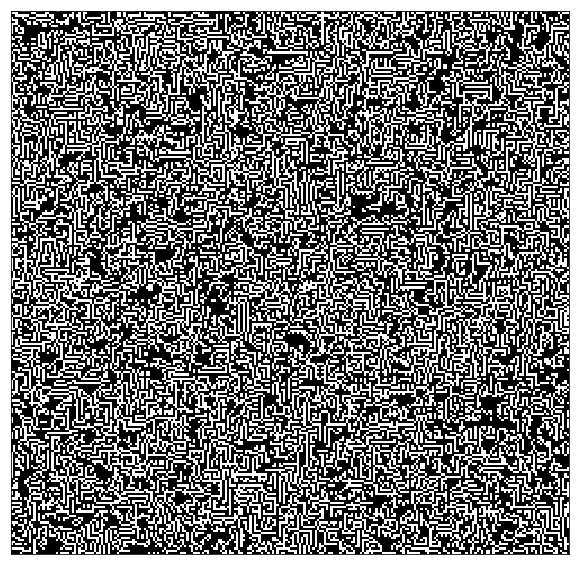

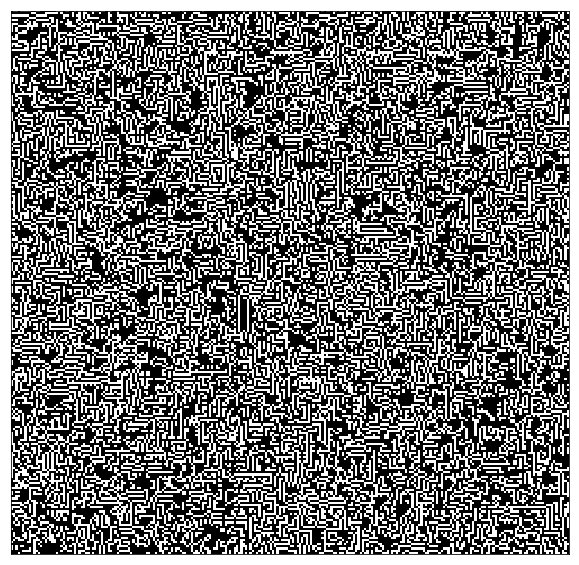

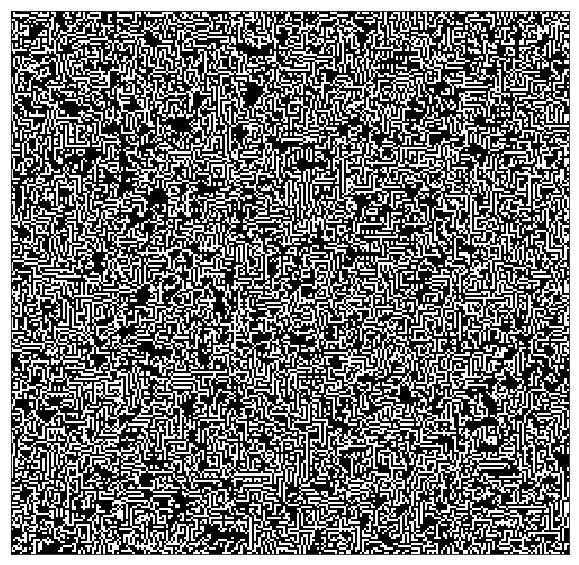

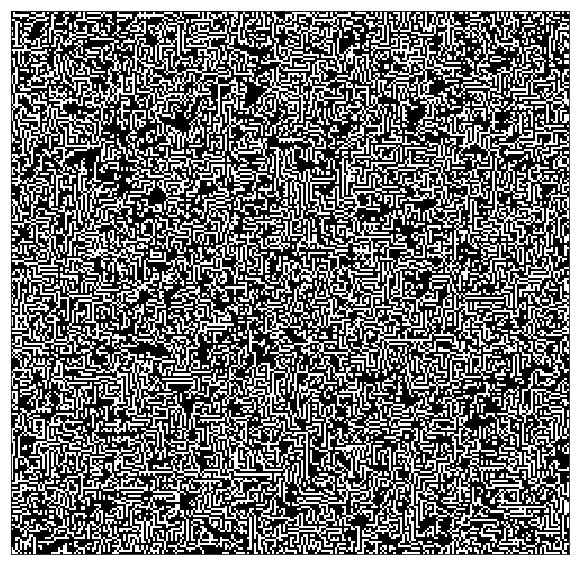

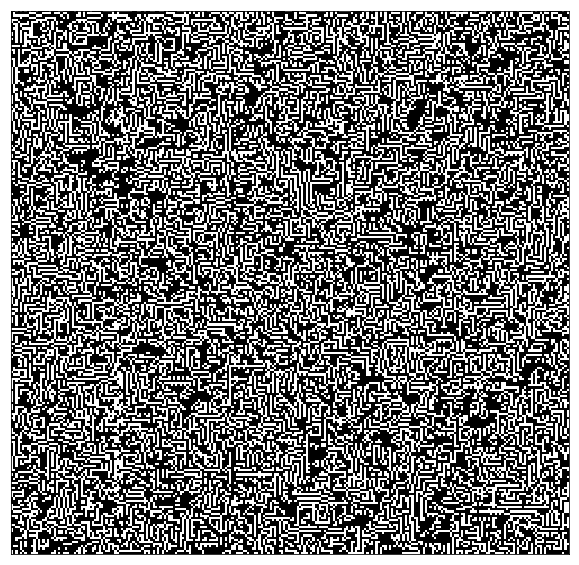

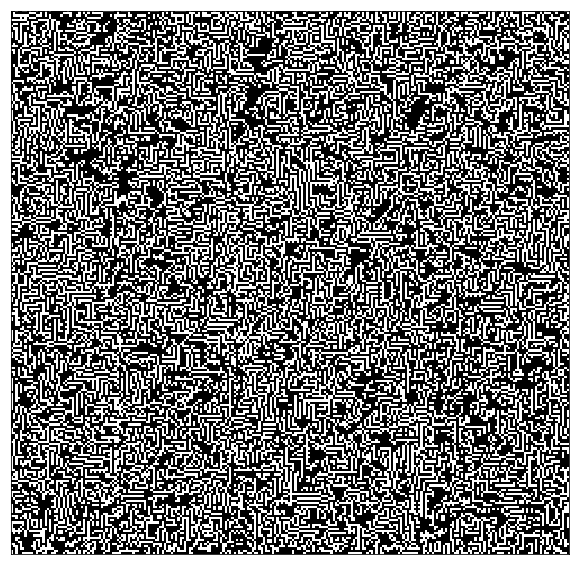

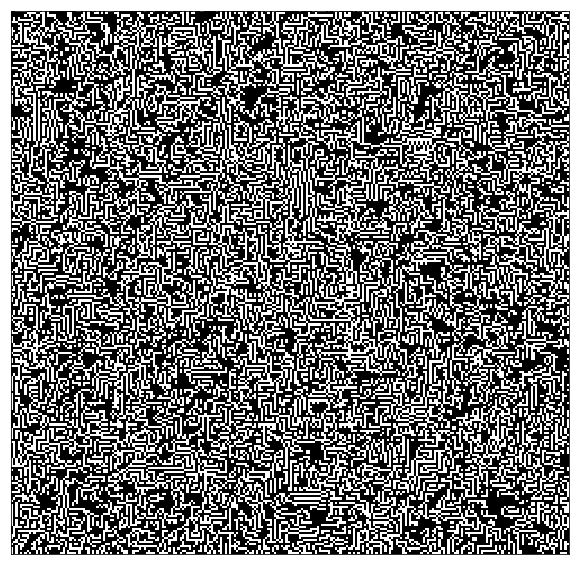

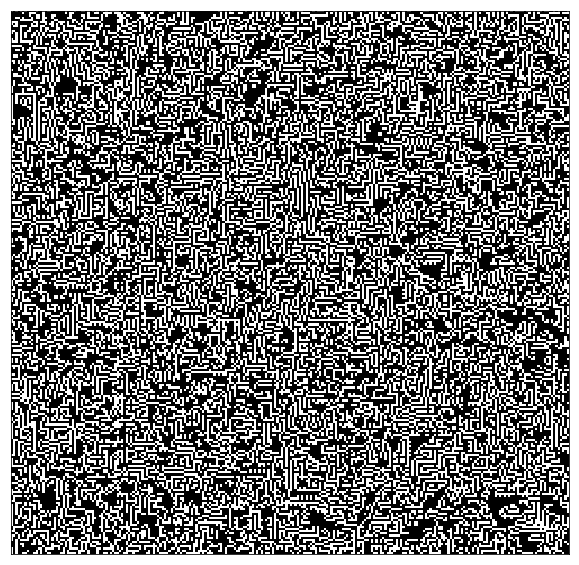

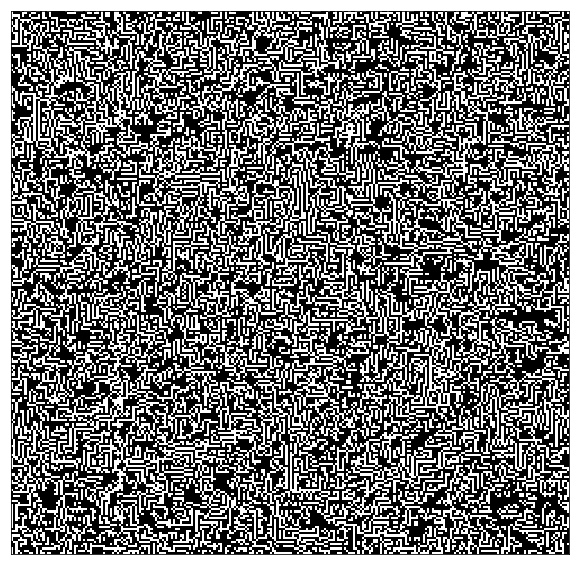

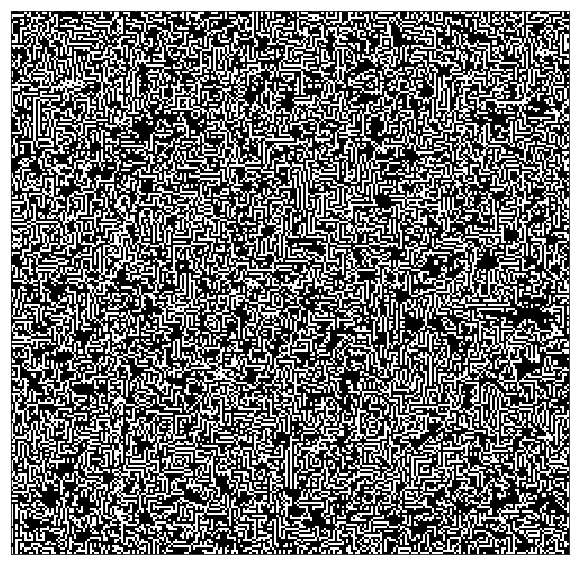

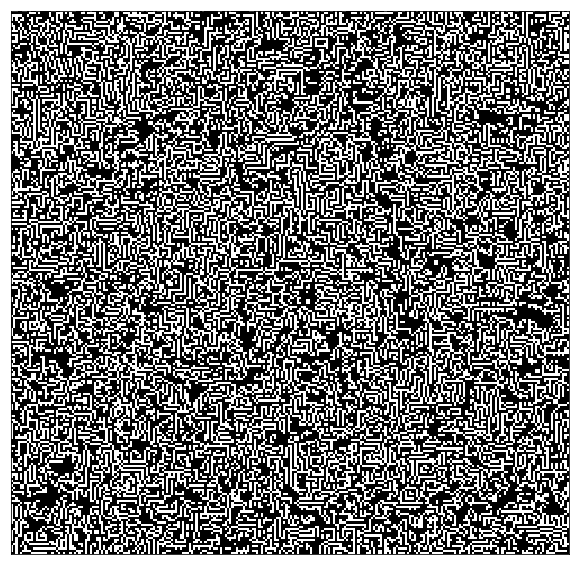

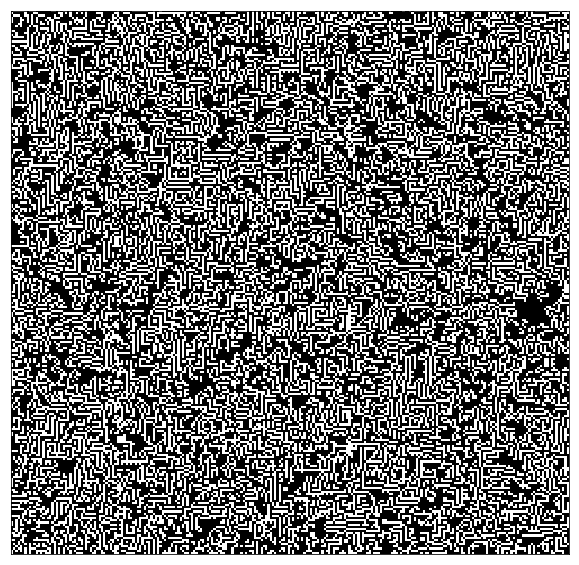

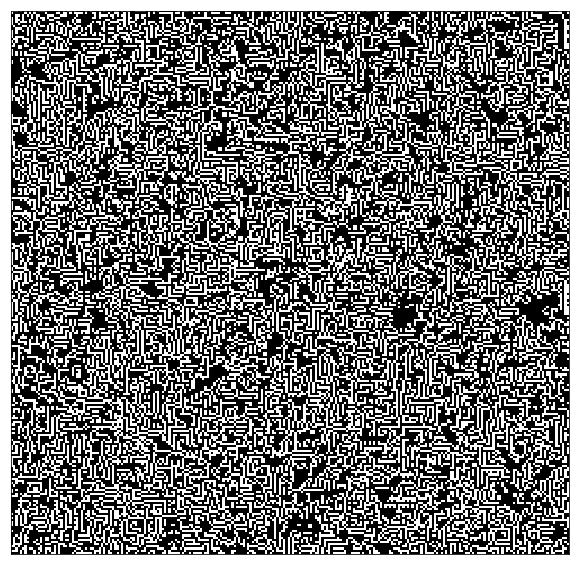

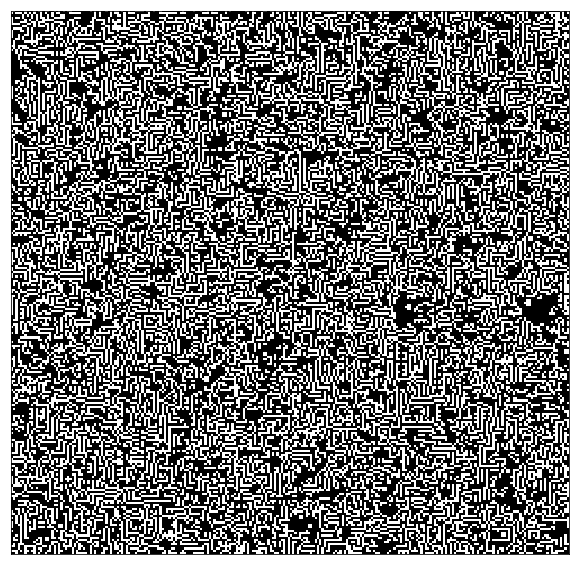

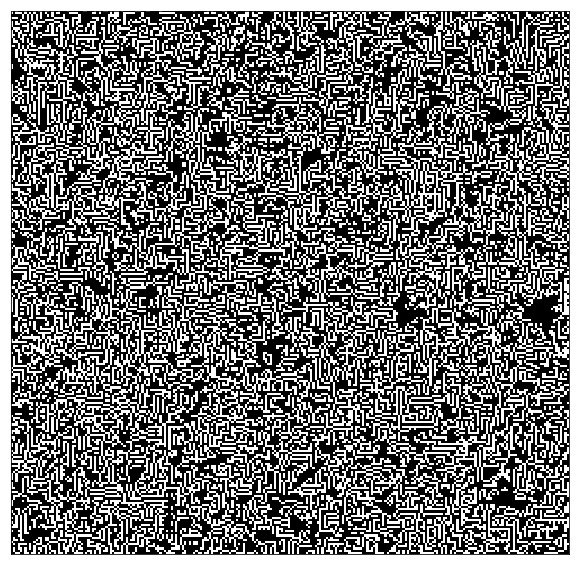

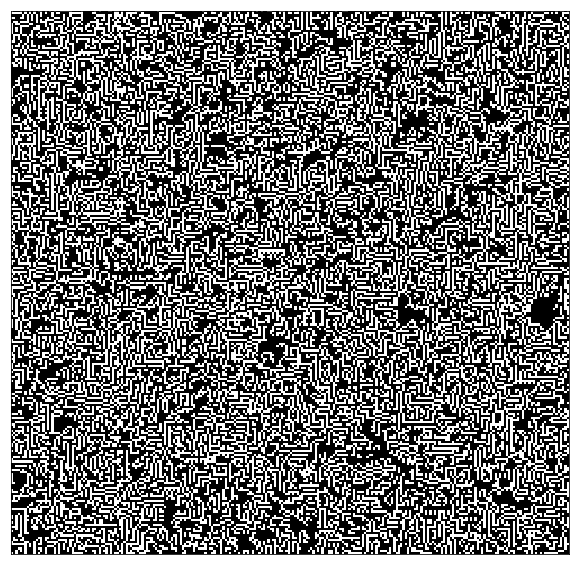

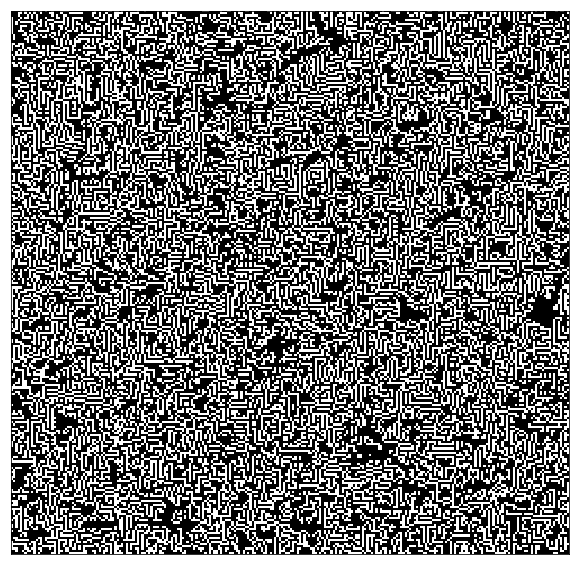

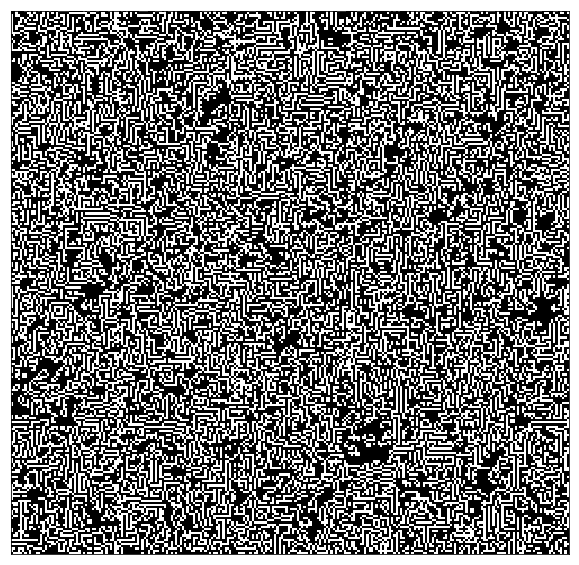

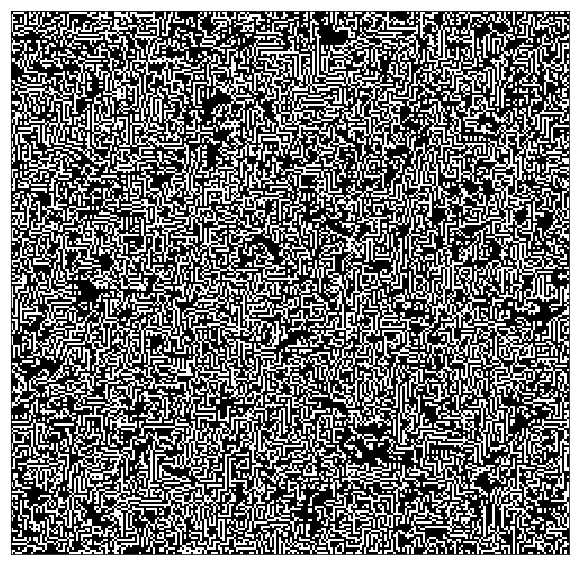

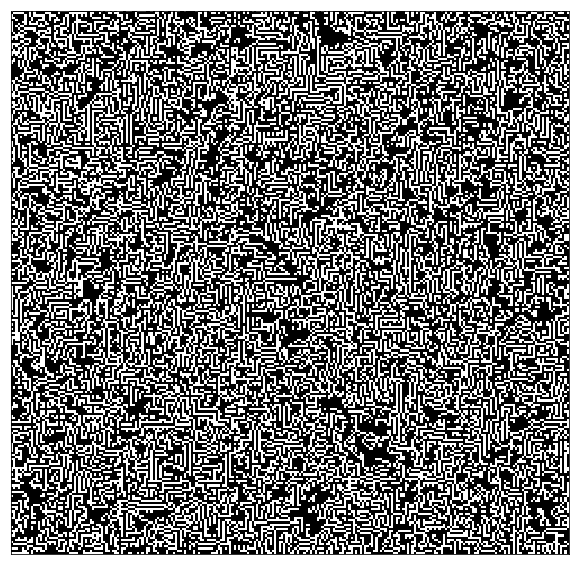

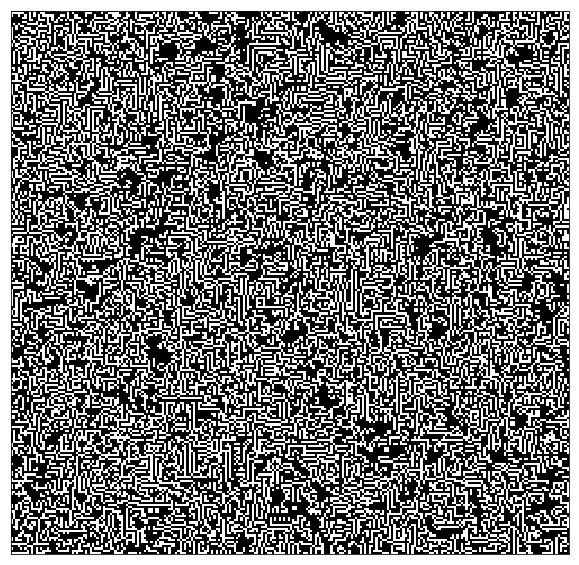

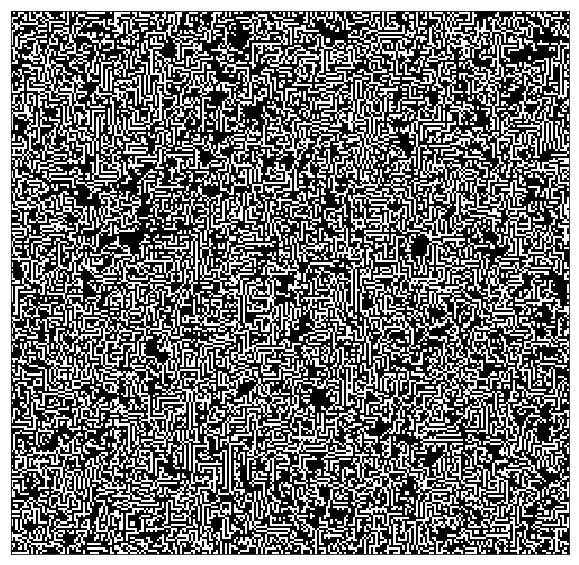

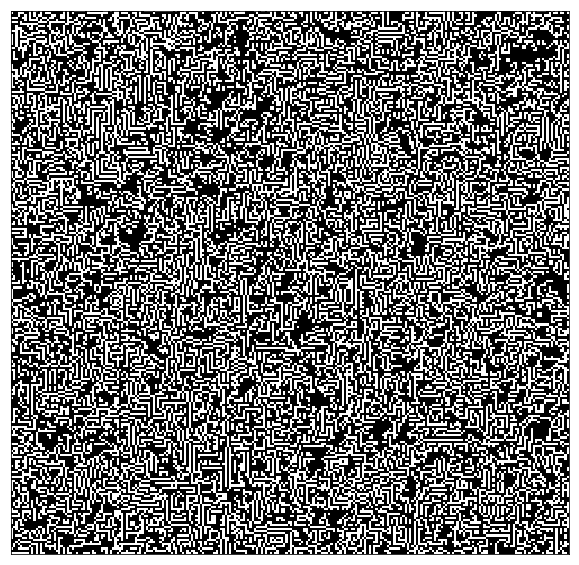

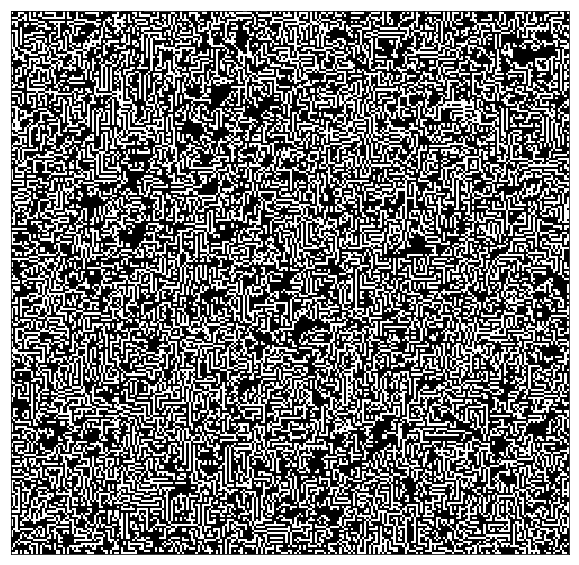

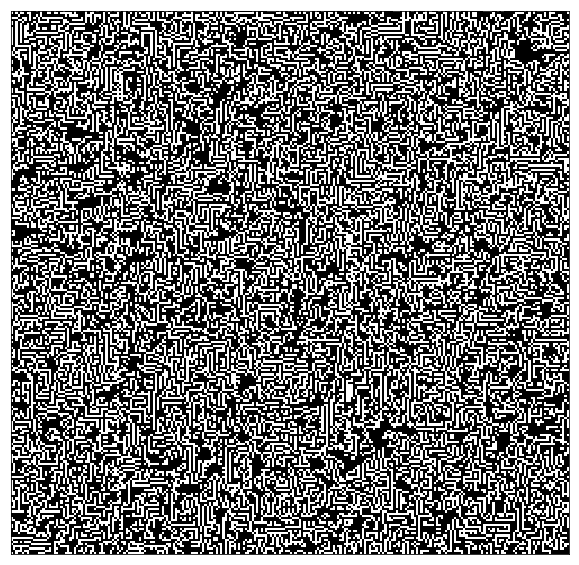

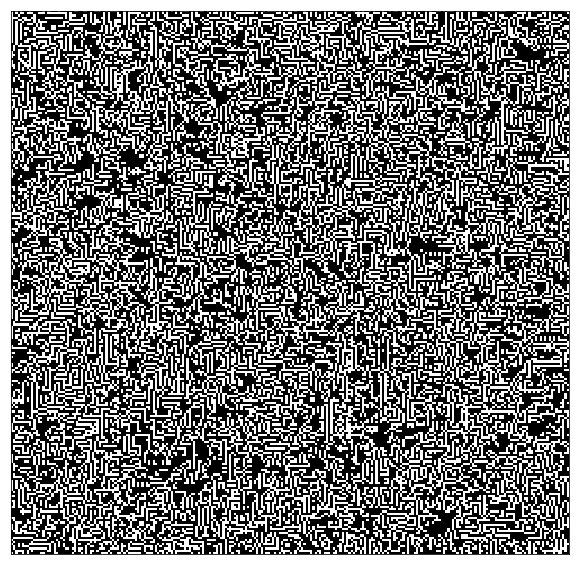

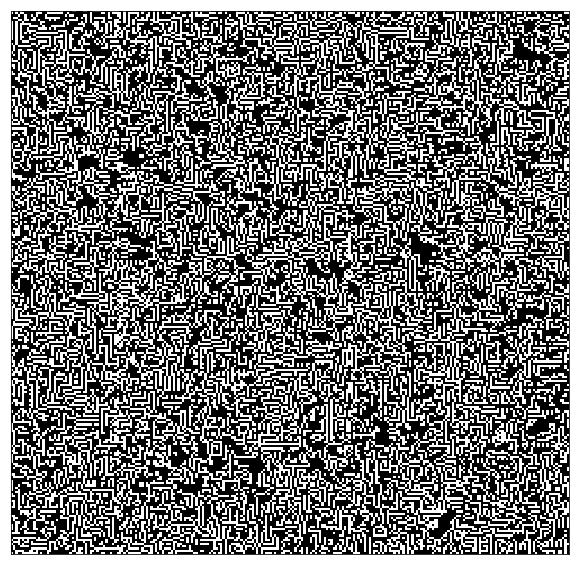

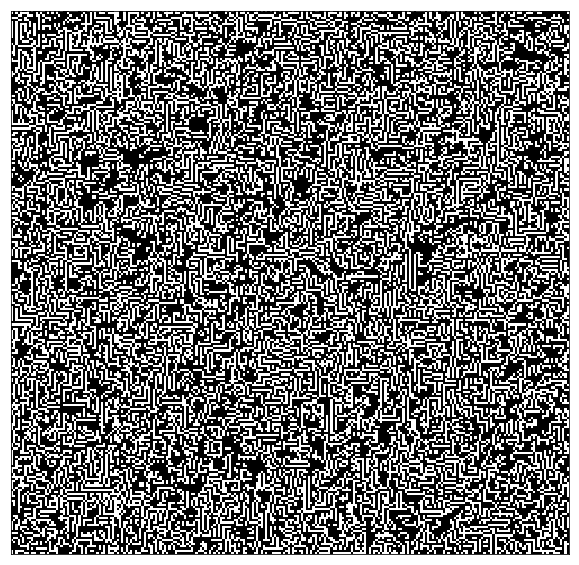

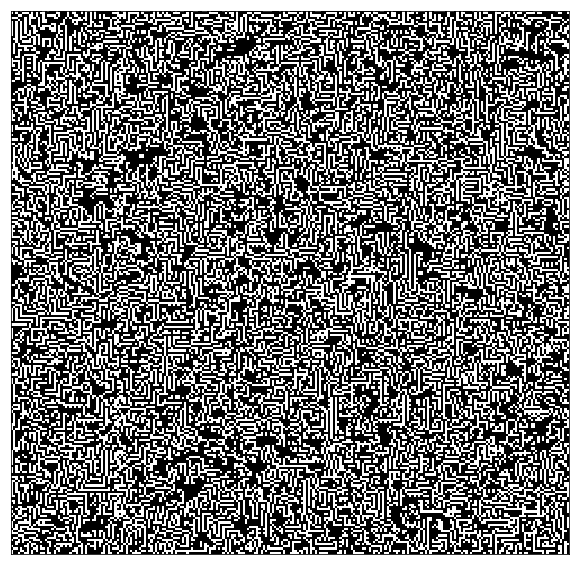

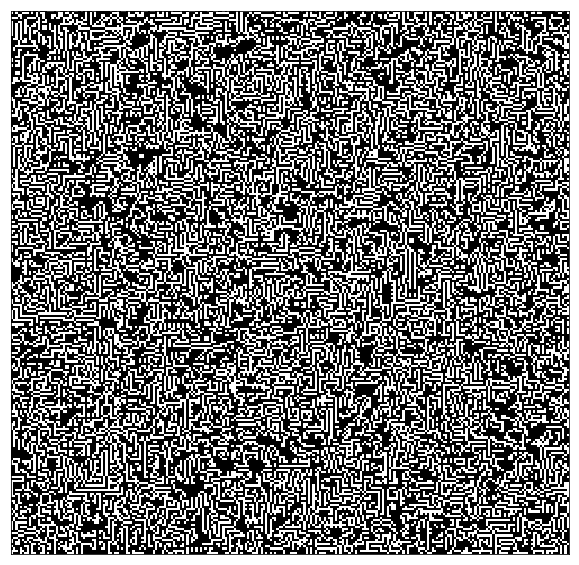

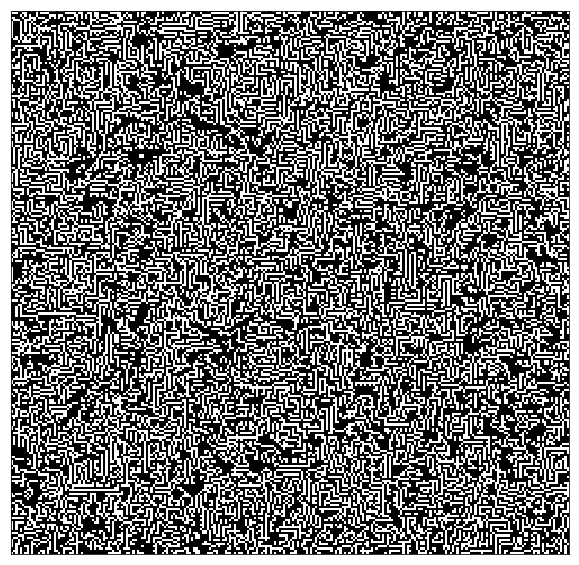

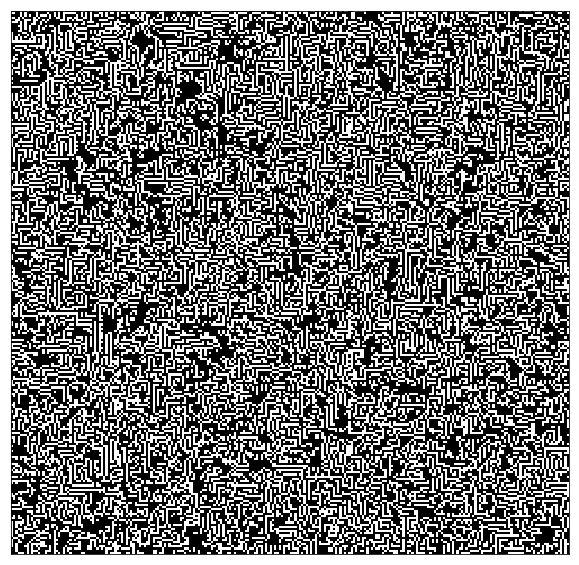

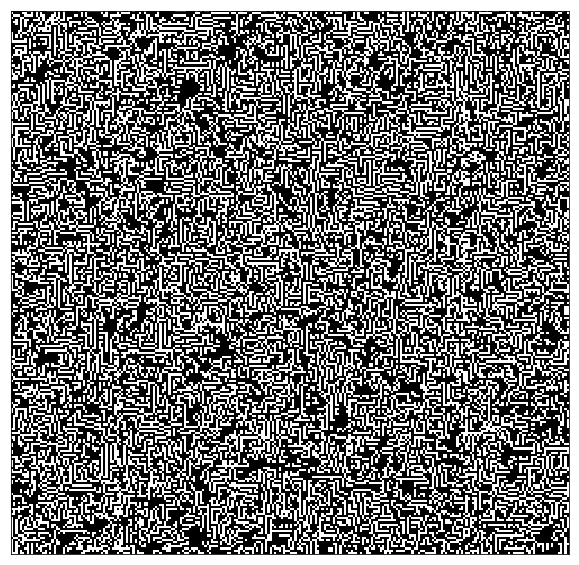

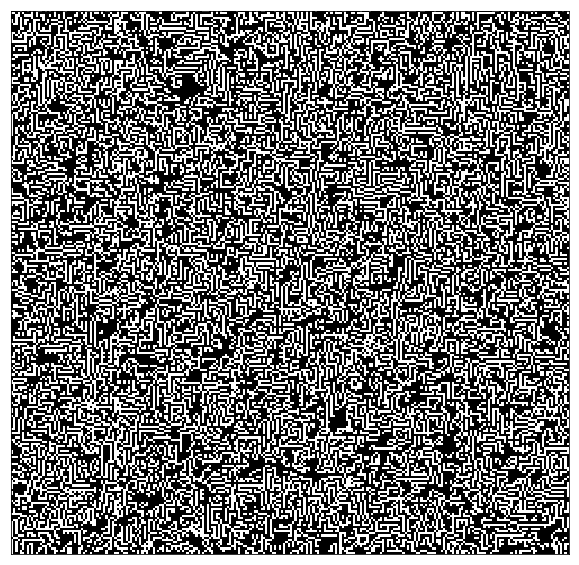

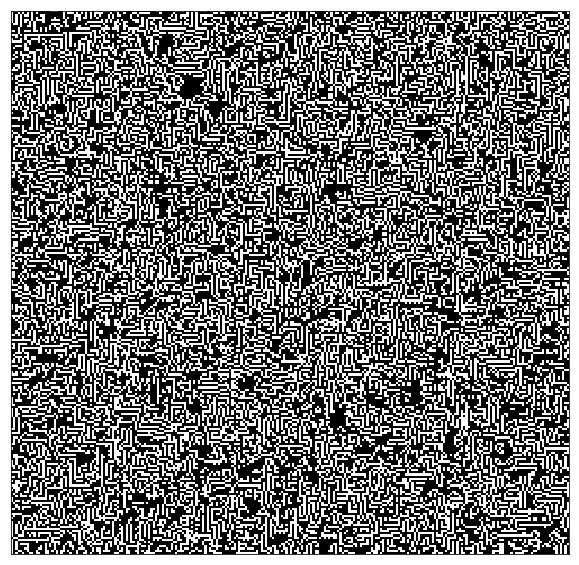

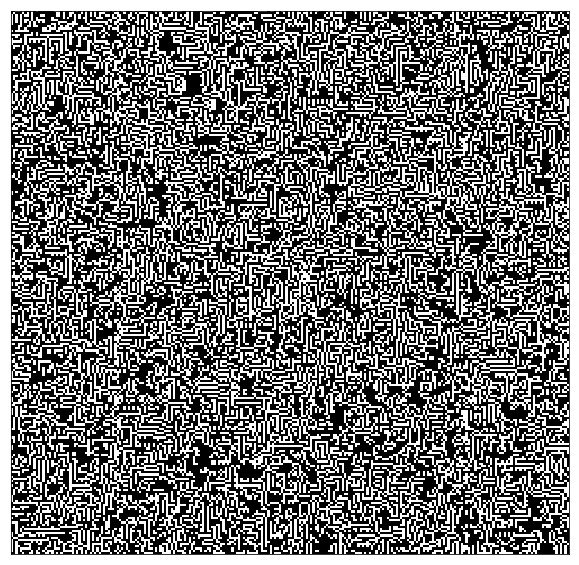

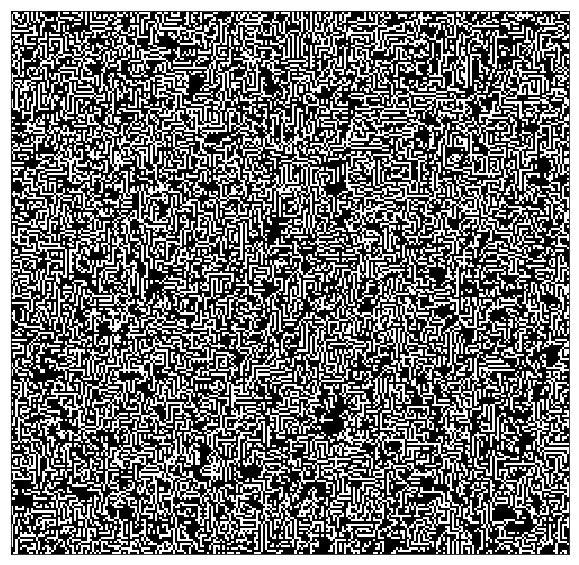

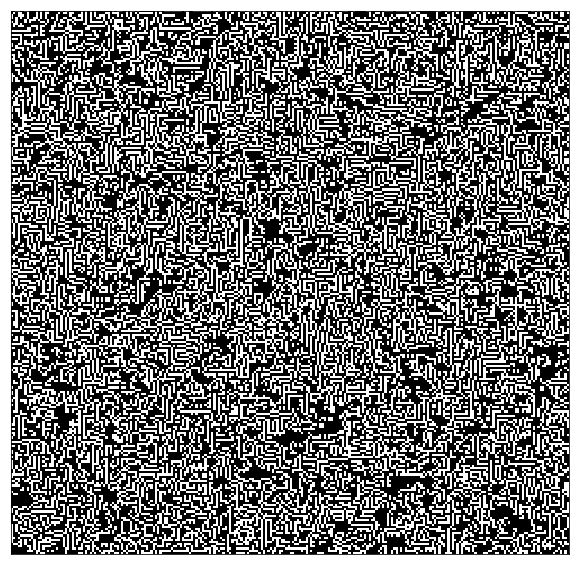

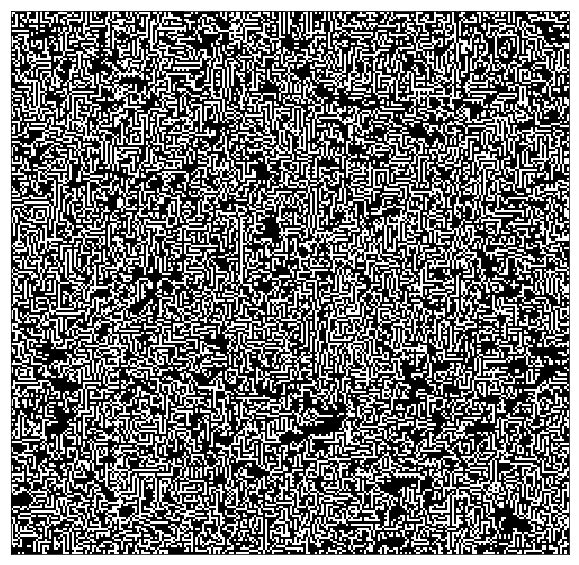

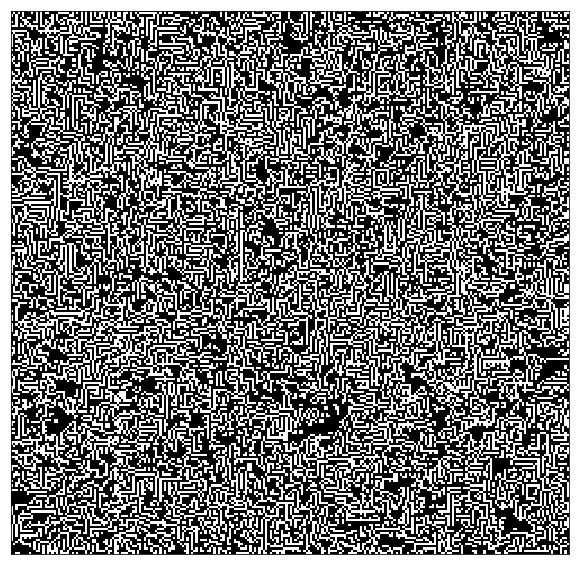

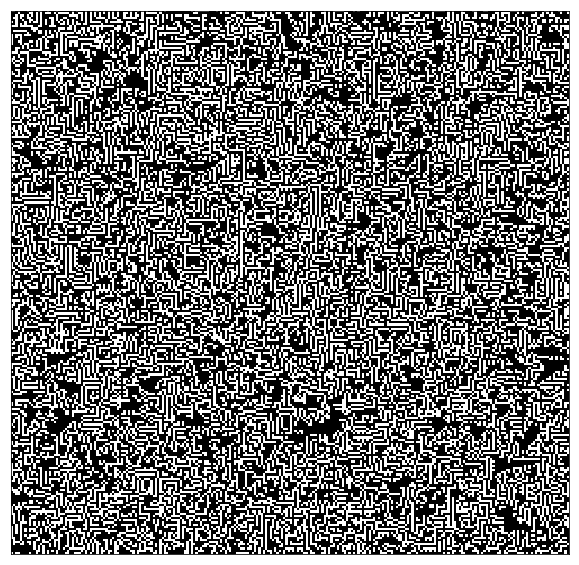

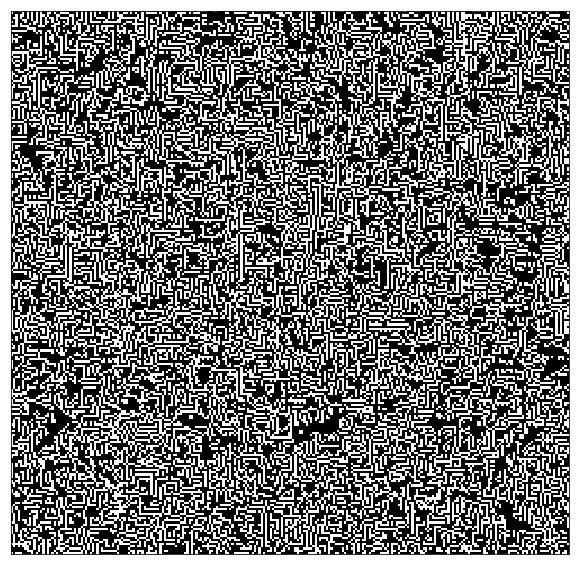

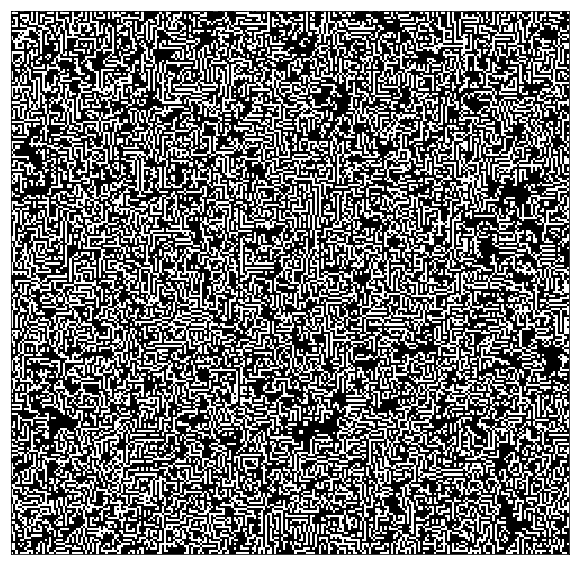

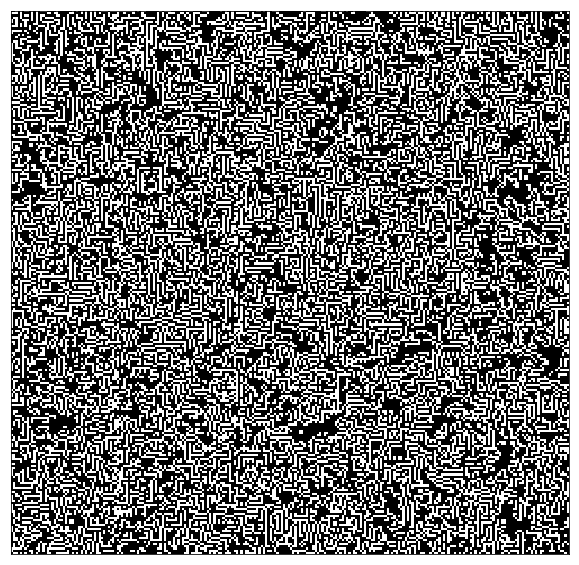

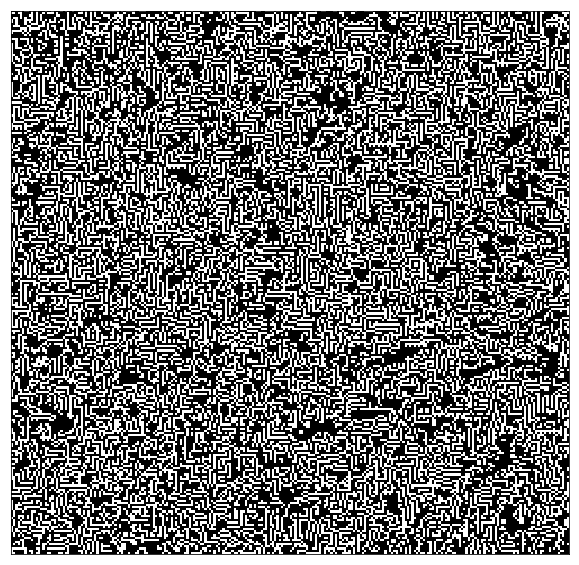

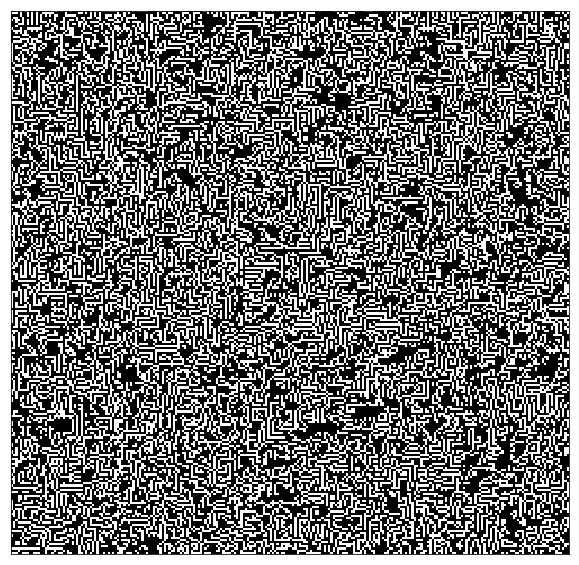

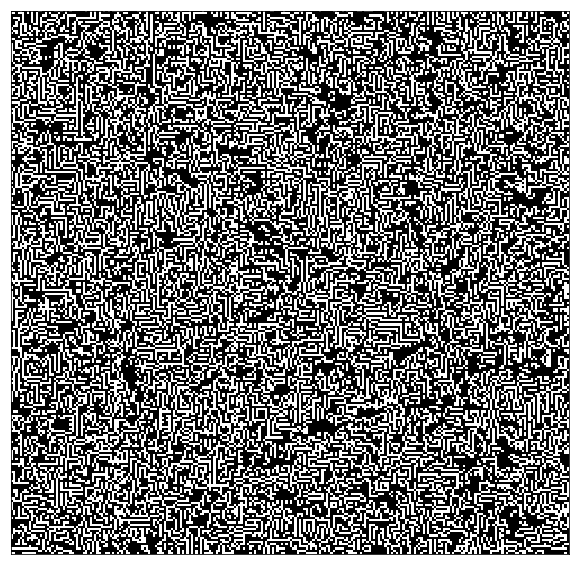

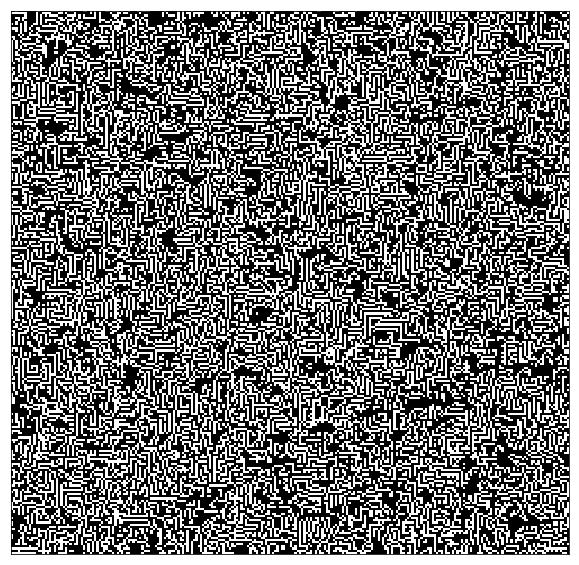

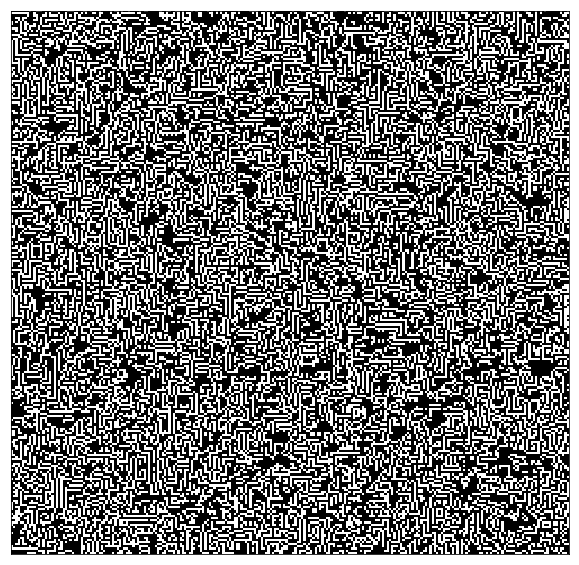

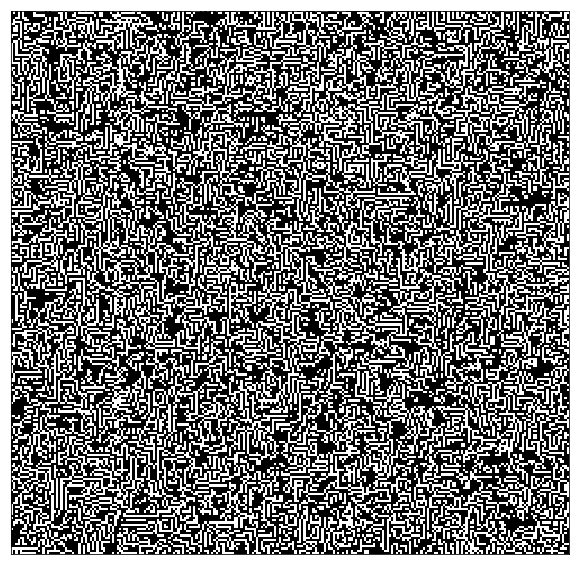

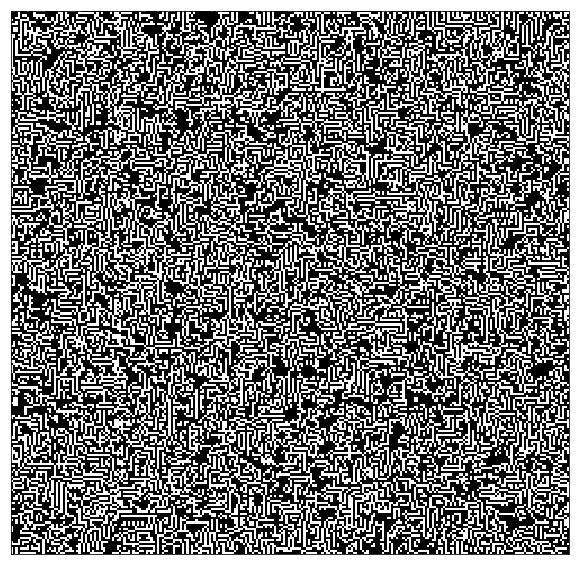

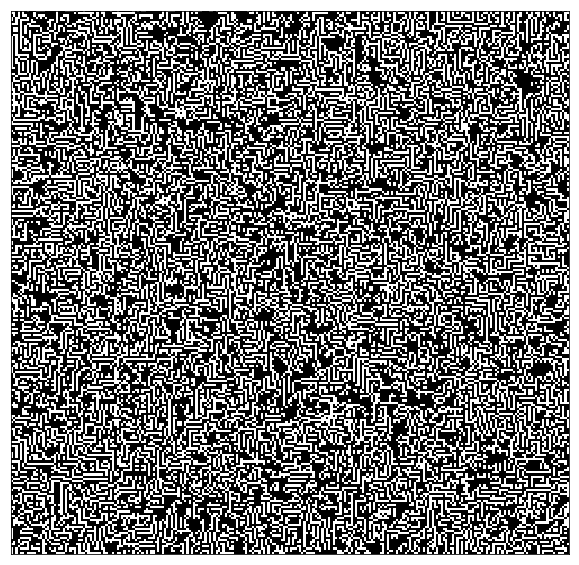

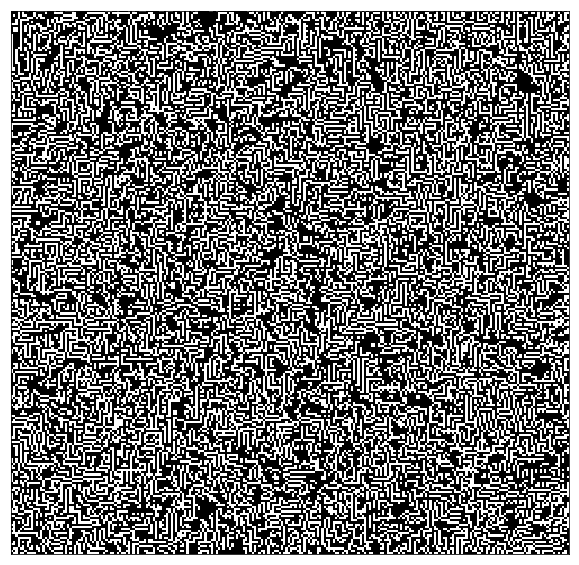

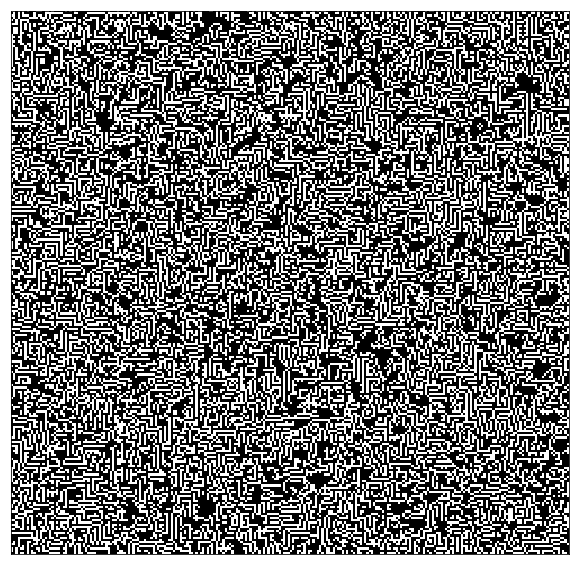

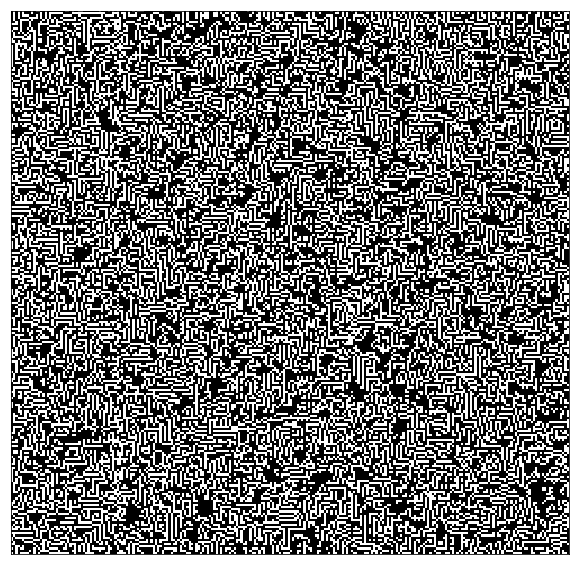

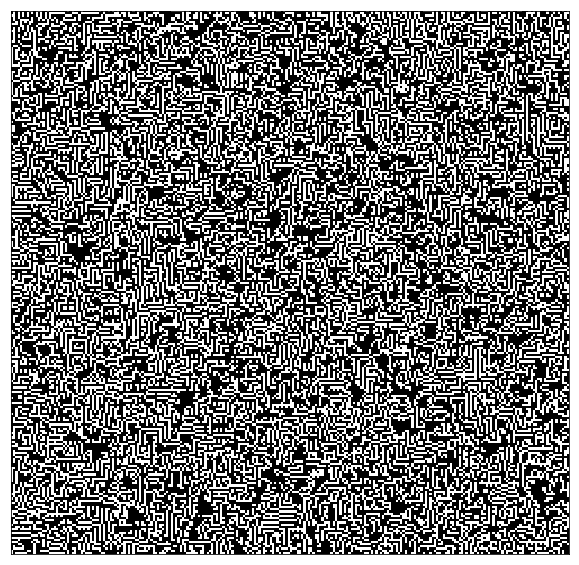

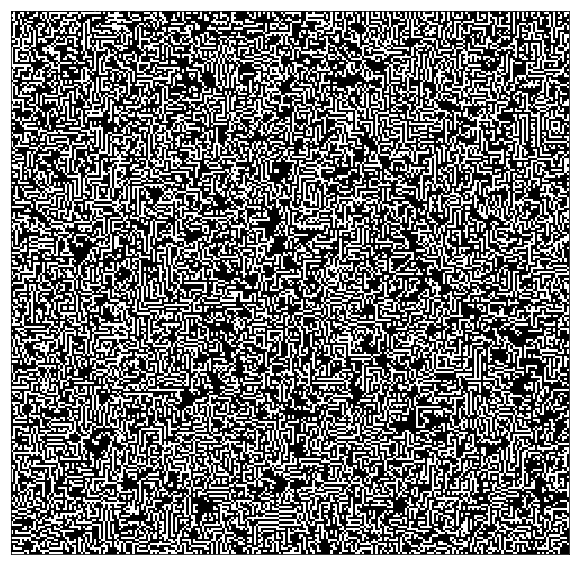

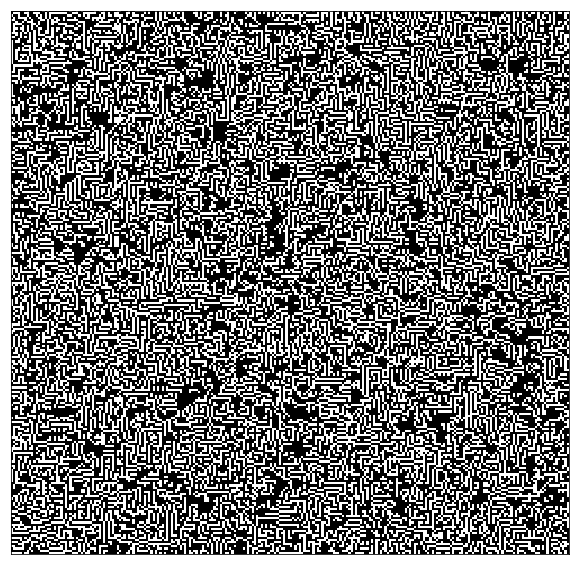

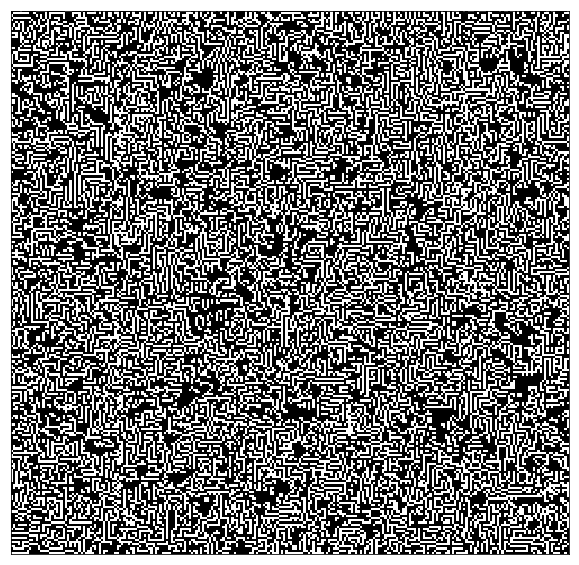

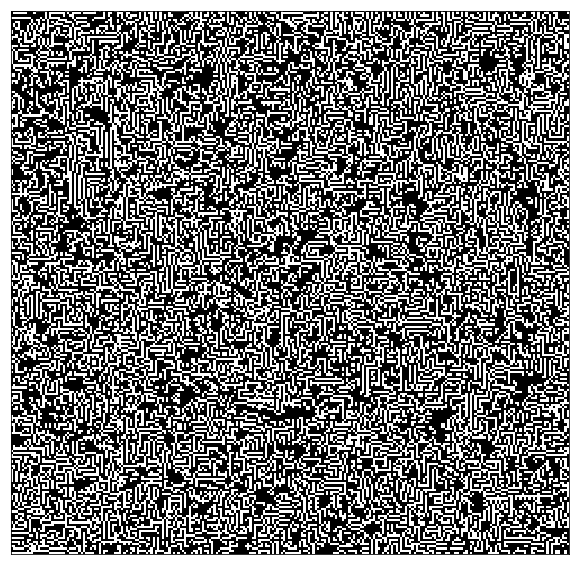

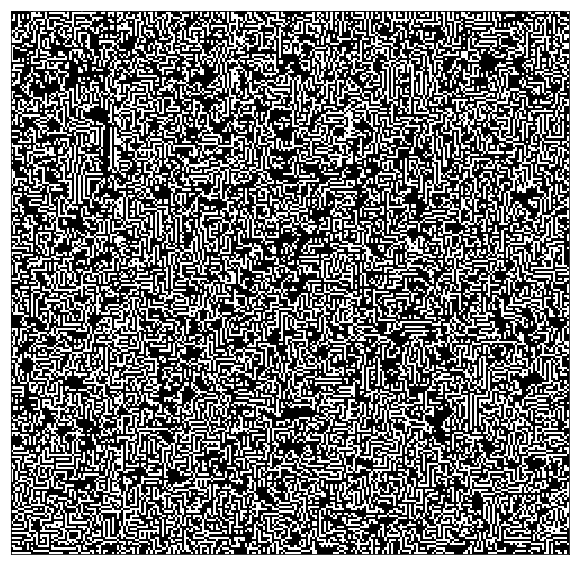

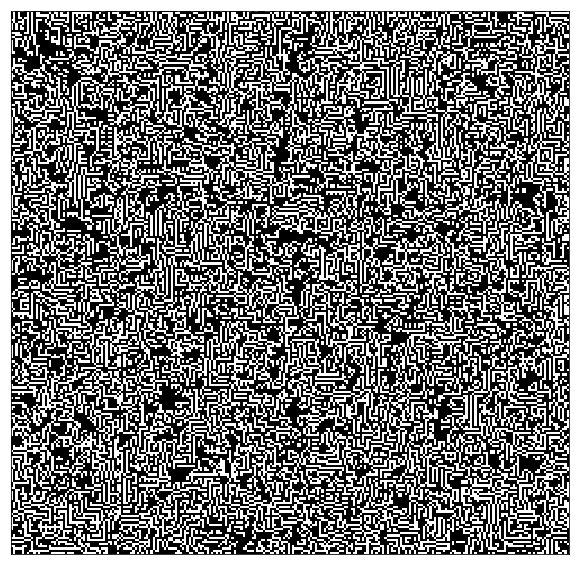

In [358]:
gif_images = []
gif_images_path = os.path.join(images_path, 'gif')

if os.path.exists(gif_images_path):
    os.system(f'rm -rf {gif_images_path}/*')
else:
    os.makedirs(gif_images_path)

for i in tqdm(range(n_iterations)):
        parts = [np.load(os.path.join(images_path, f'{j}_{i}.npy')) for j in range(test_n_processes)]

        joined_img = parts[0]
        for part in parts[1:]:
            joined_img = np.hstack((joined_img[:, 1:-1], part[:, 1:-1]))
                
        joined_img = plot_image(joined_img)
        joined_img.savefig(os.path.join(gif_images_path, f'{i}.png'))
        
        gif_images.append(imageio.imread(os.path.join(gif_images_path, f'{i}.png')))
    
imageio.mimsave(f'game_of_life_mpi_{exp_name}.gif', gif_images, duration=0.15)

![](game_of_life_mpi_half_exp.gif)

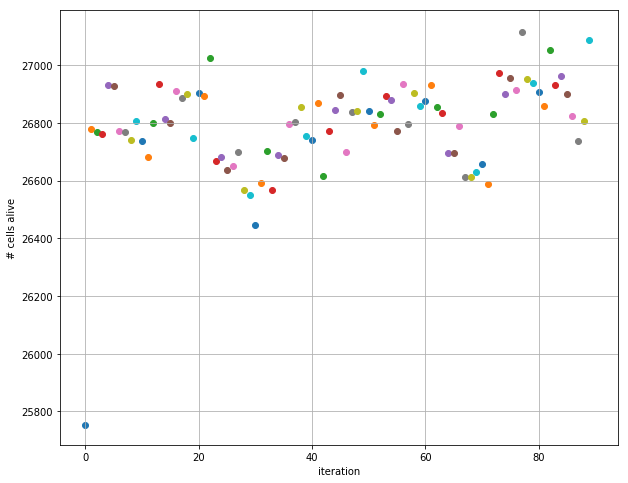

In [359]:
iter_cells = {}

with open(cells_path, 'r') as f:
    for line in f.readlines():
        iter, cells = line.strip().split()
        iter_cells[int(iter)] = float(cells)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for iter, cells in iter_cells.items():
    ax.scatter(iter, cells)

ax.grid()
ax.set_xlabel('iteration')
ax.set_ylabel('# cells alive')

fig.savefig(f'{exp_name}.png')

## Glider gun

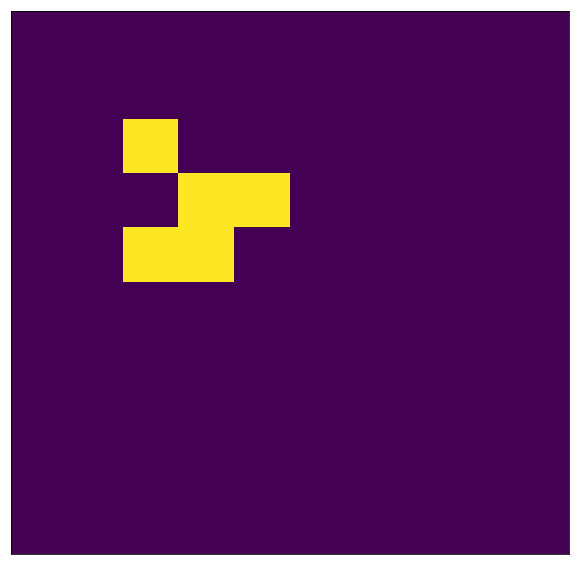

In [48]:
grid_glider = grid_class(7, 7, 0.95, use_glider=True)
grid_glider.plot().show()

In [49]:
num_iters = 100
gif_images_path = 'gif_images_glider'
exp_name = 'glider'

if os.path.exists(gif_images_path):
    os.system(f'rm -rf {gif_images_path}/*')
else:
    os.makedirs(gif_images_path)

 20%|██        | 20/100 [00:03<00:11,  6.92it/s]/home/sanityseeker/.local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


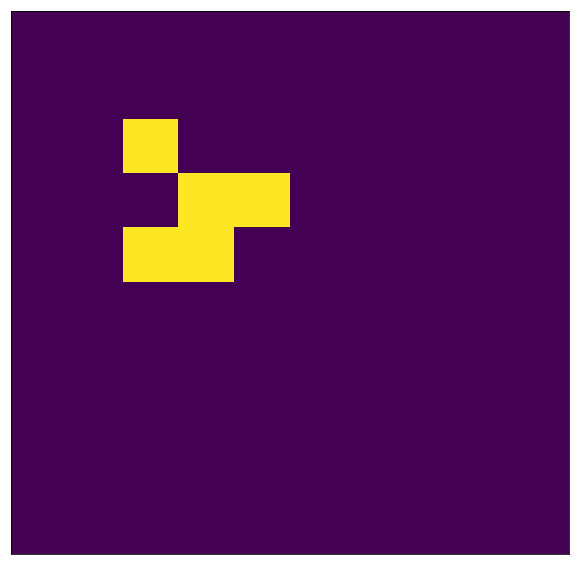

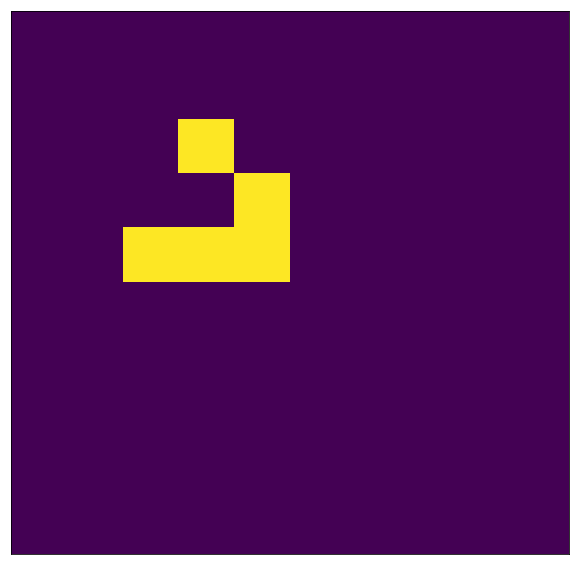

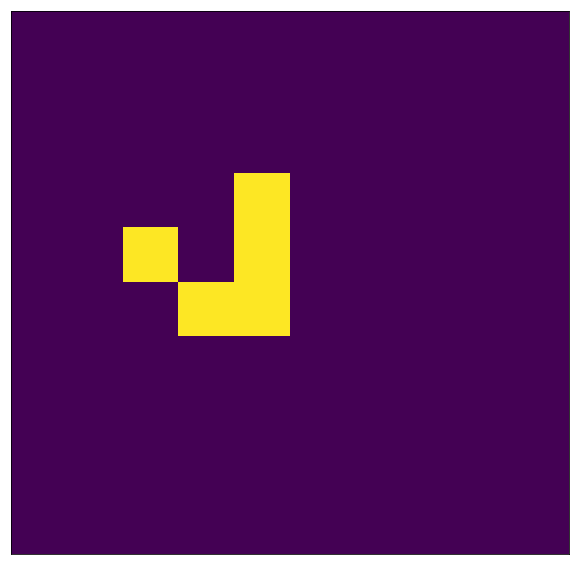

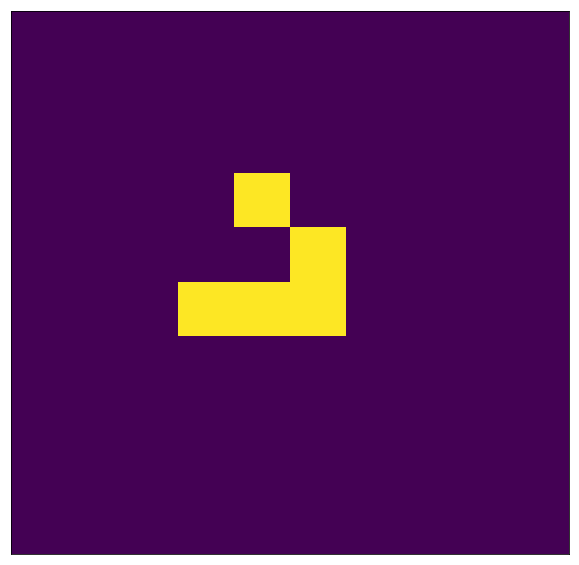

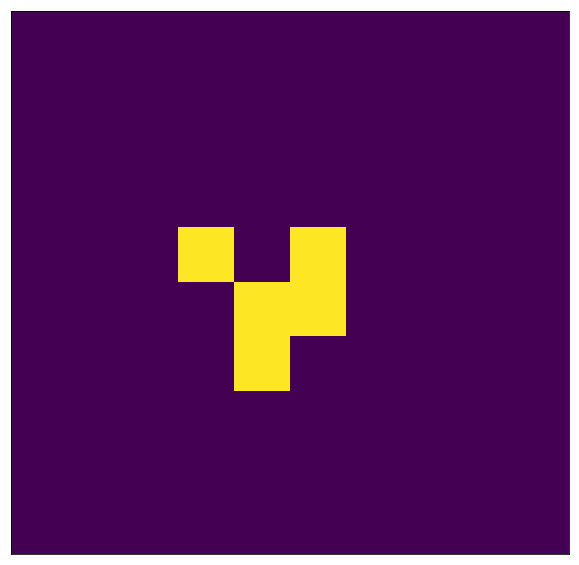

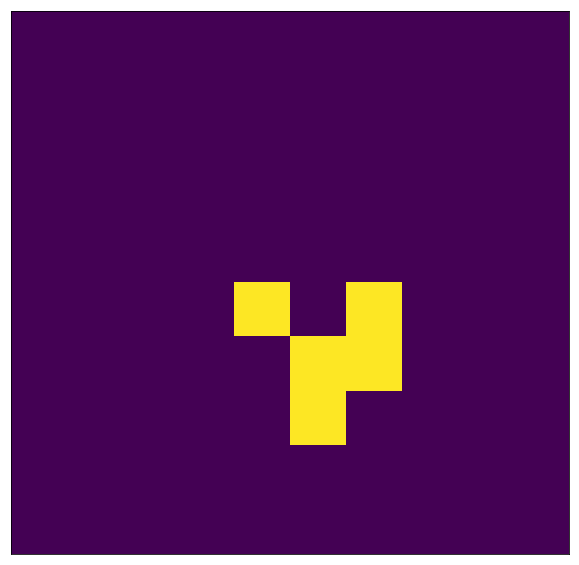

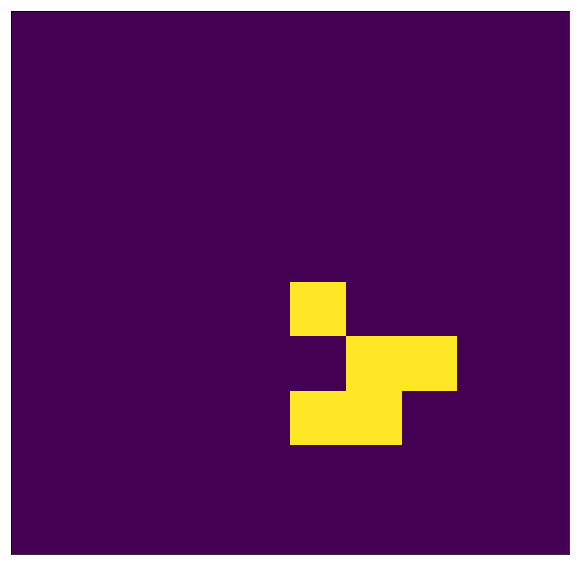

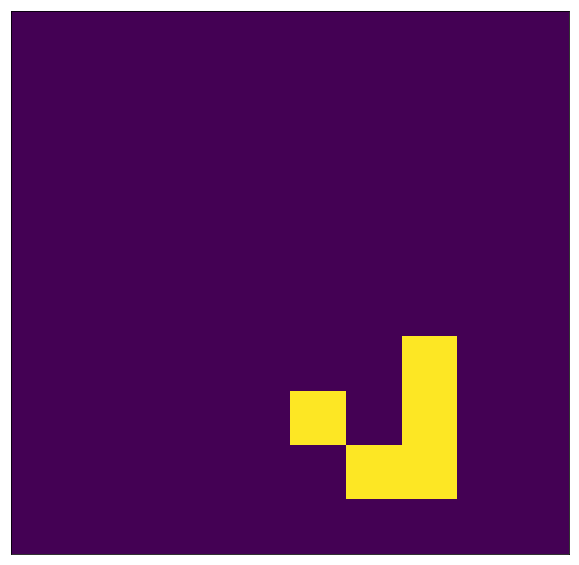

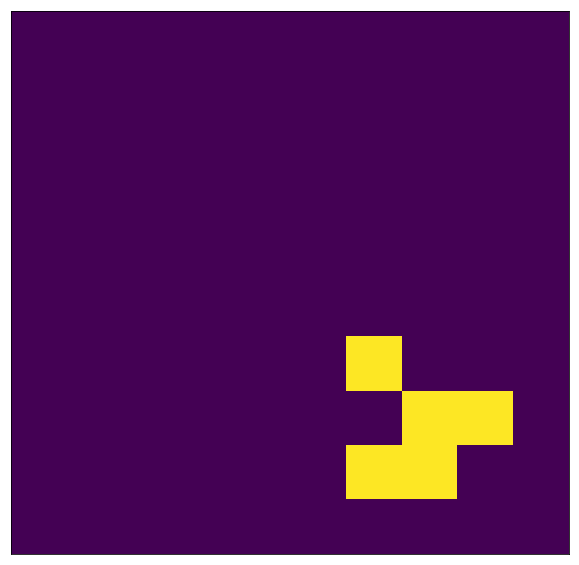

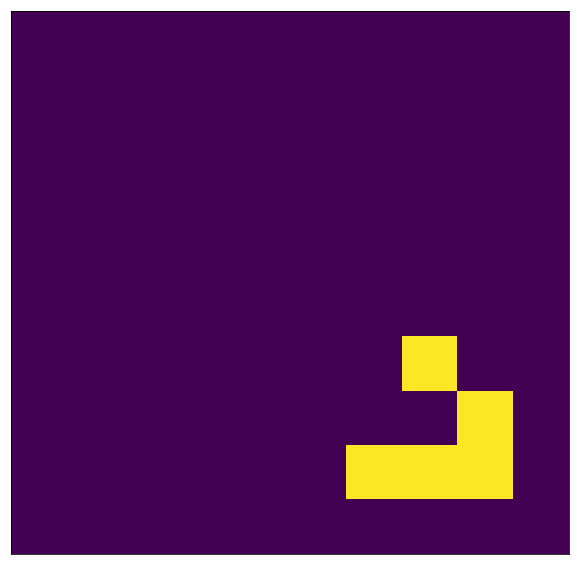

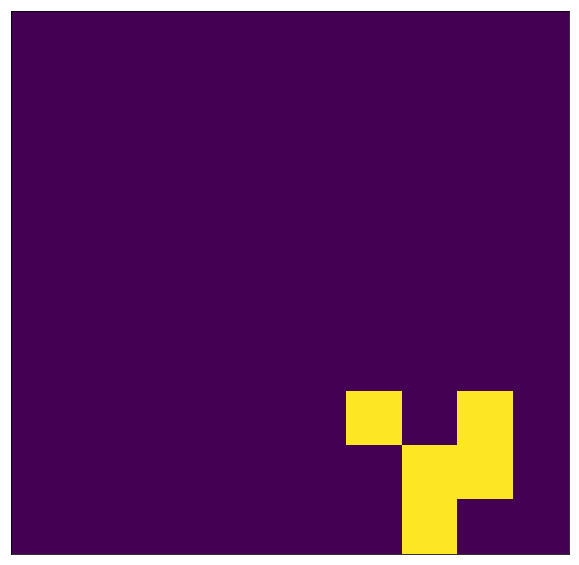

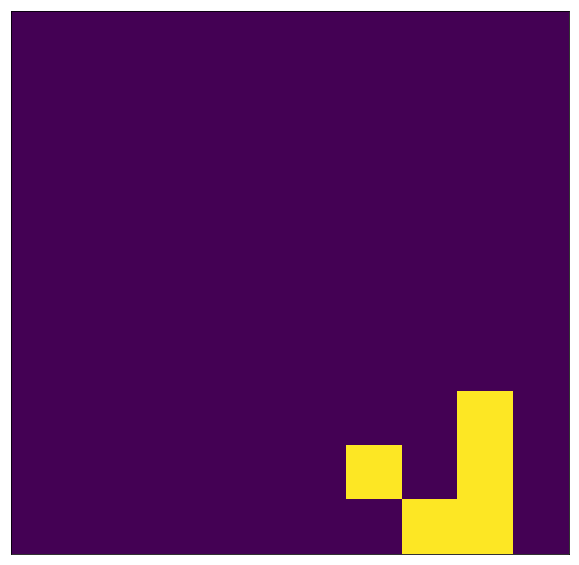

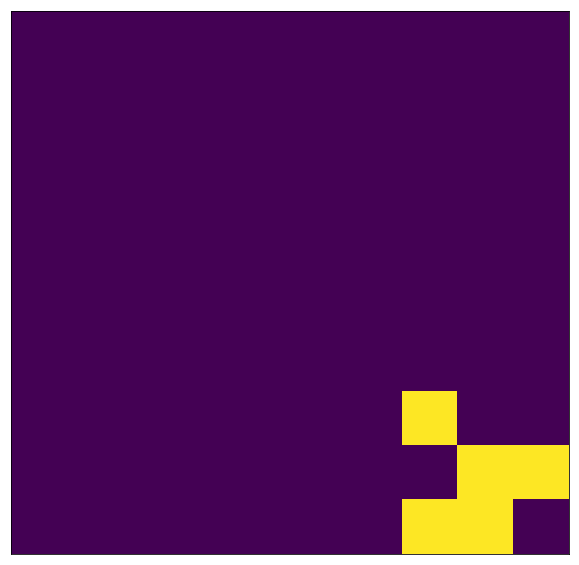

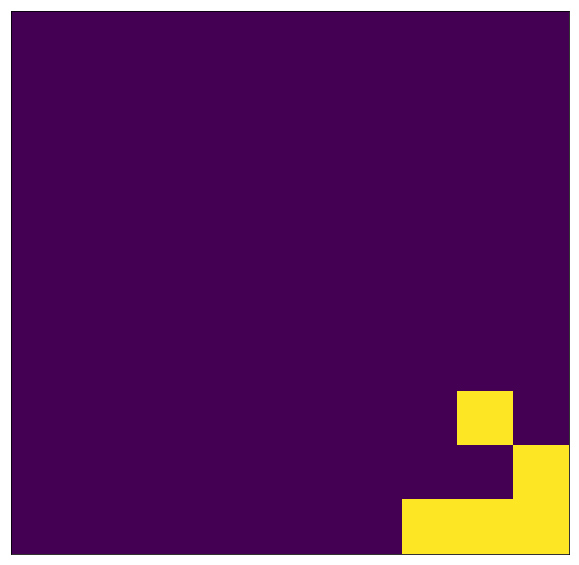

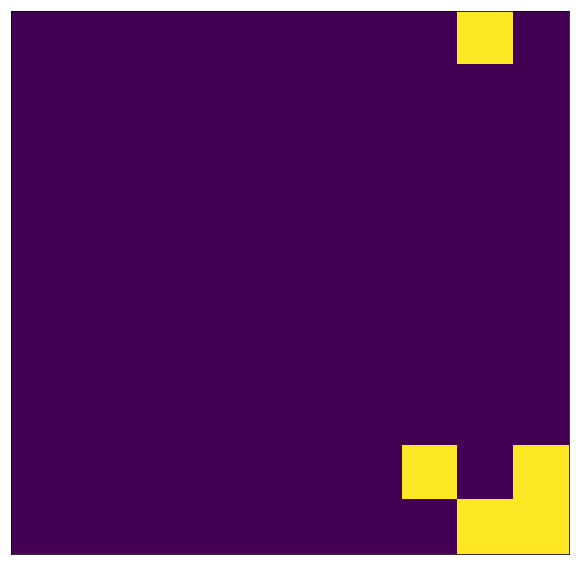

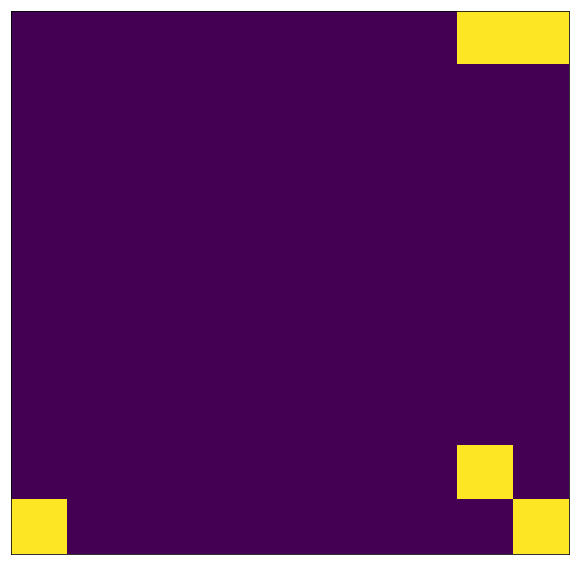

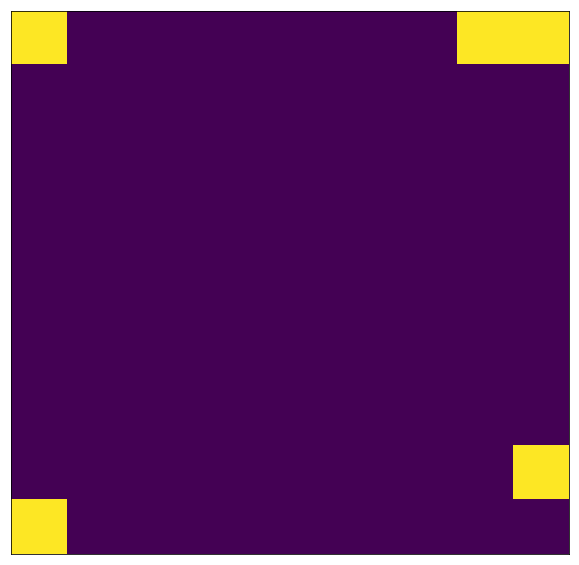

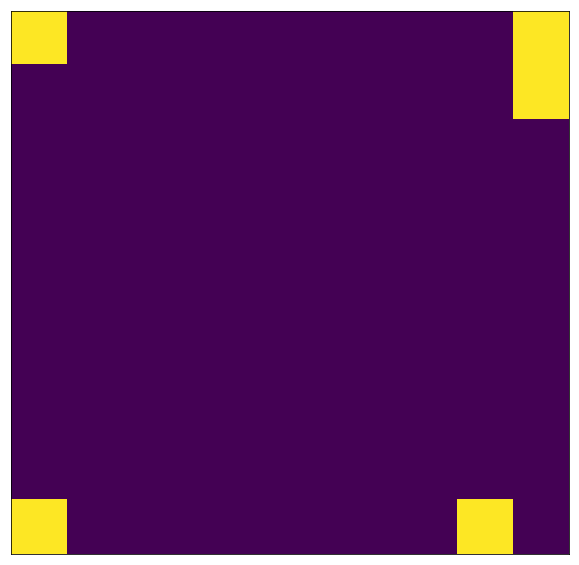

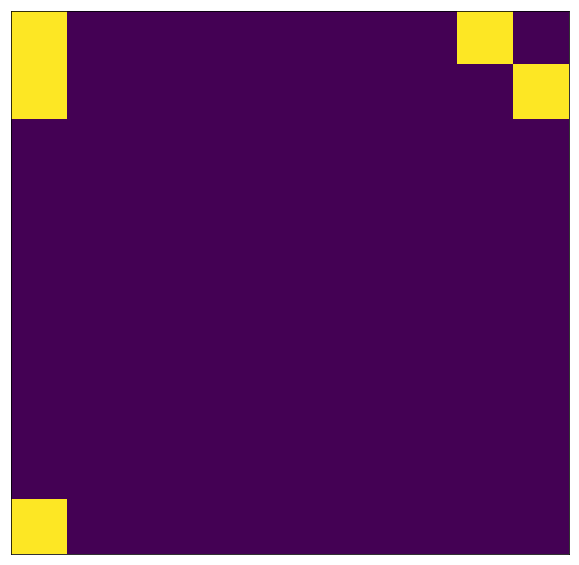

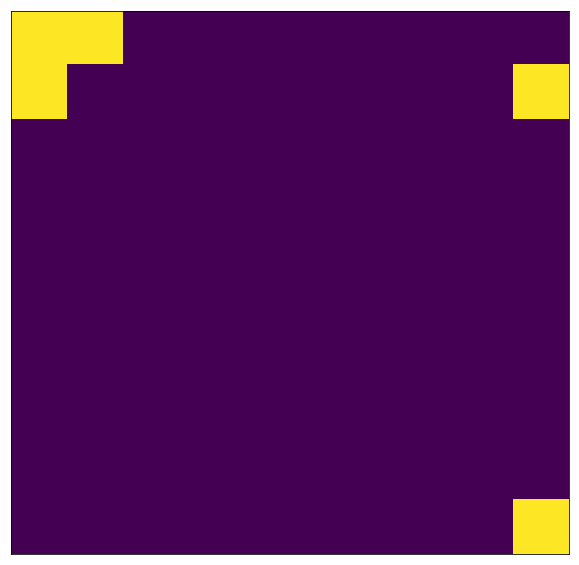

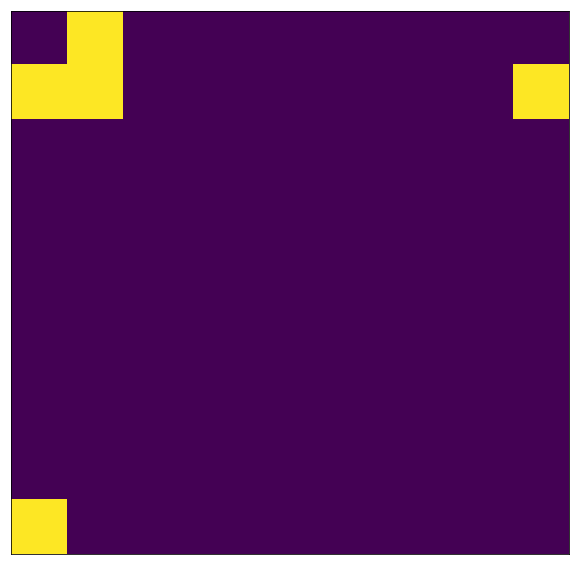

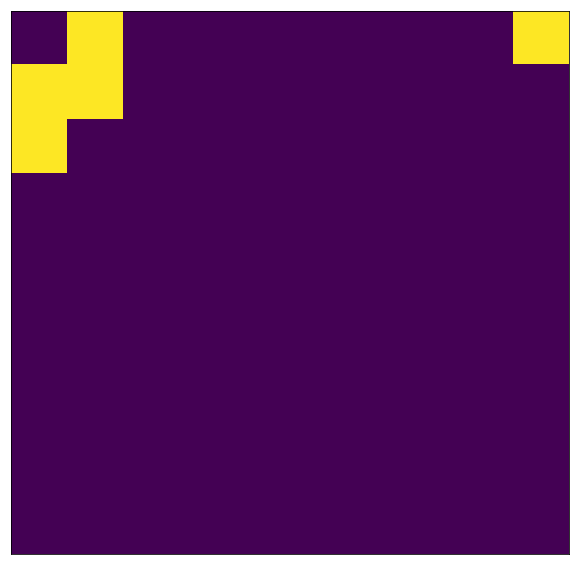

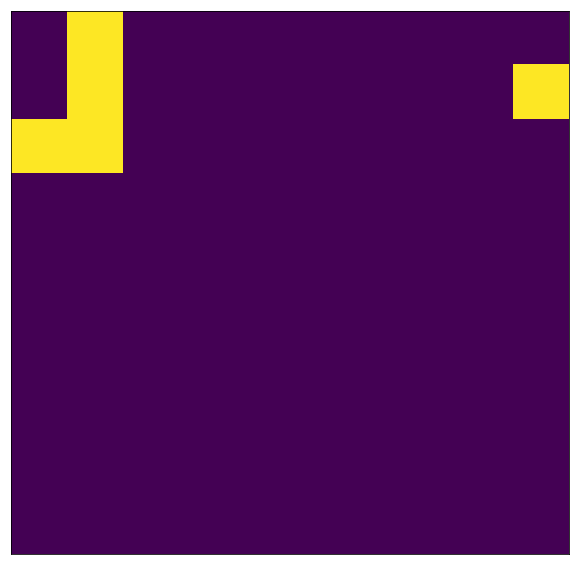

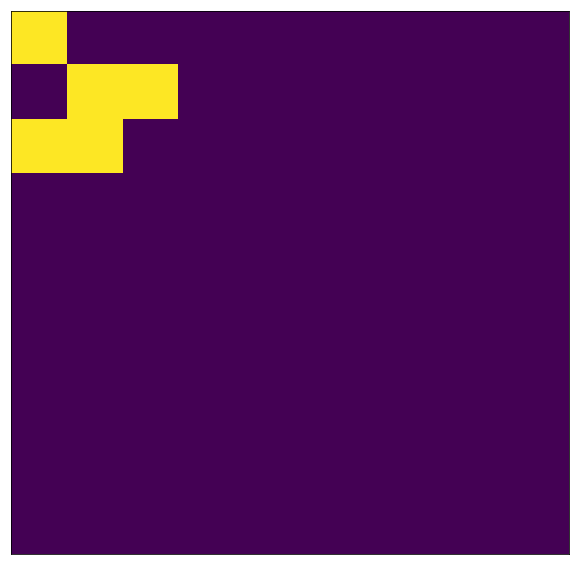

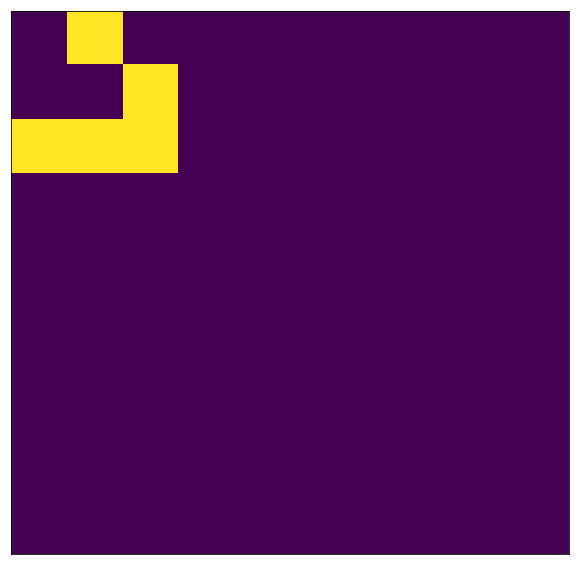

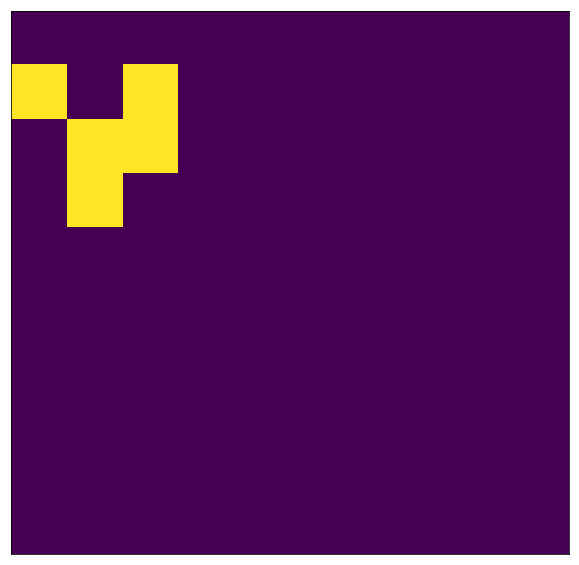

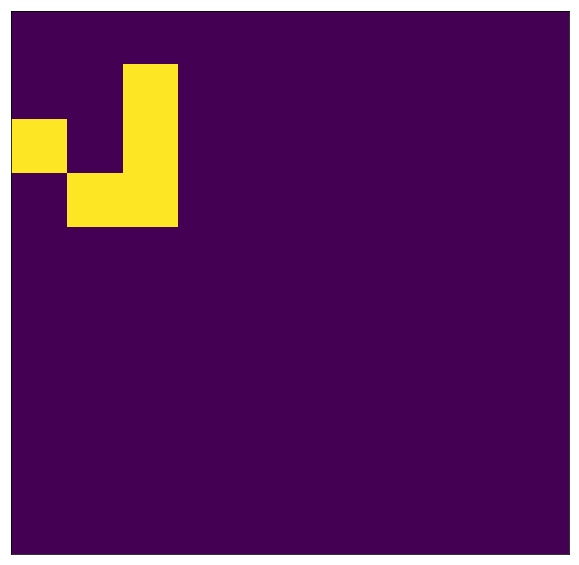

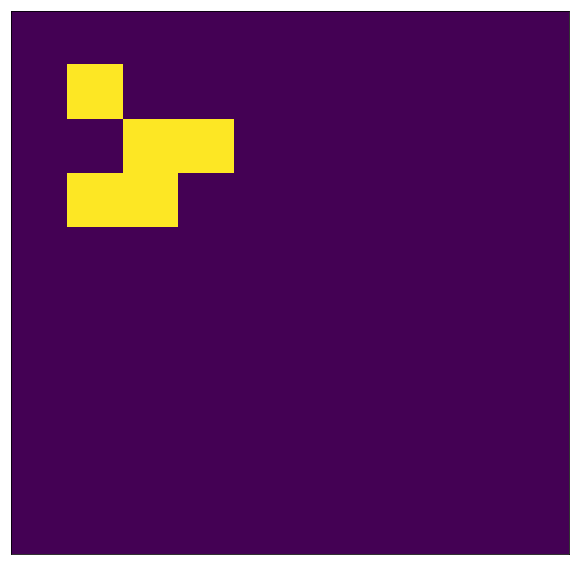

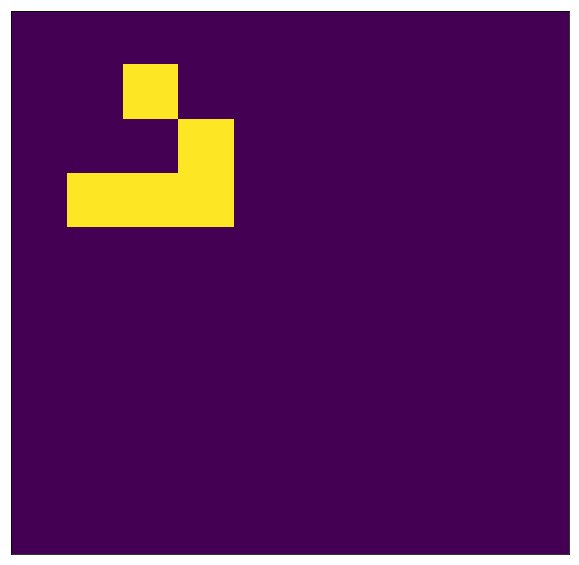

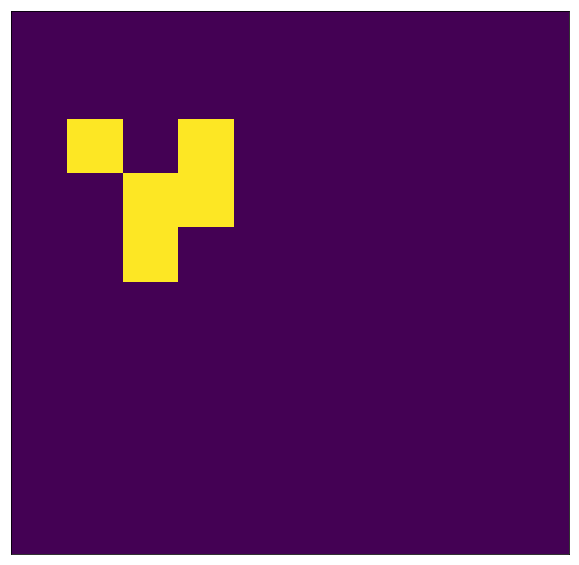

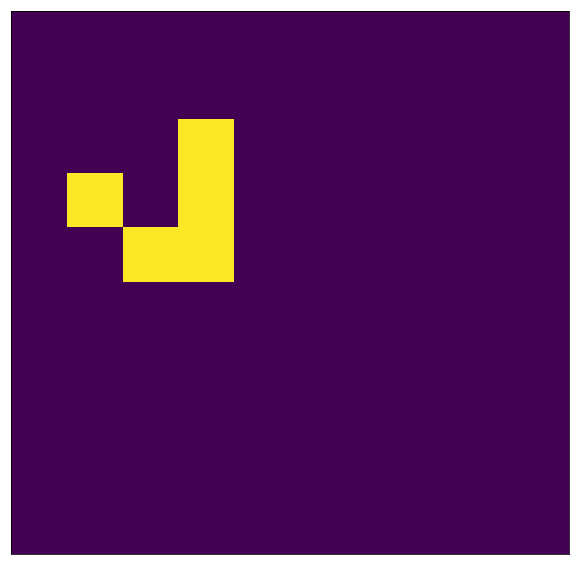

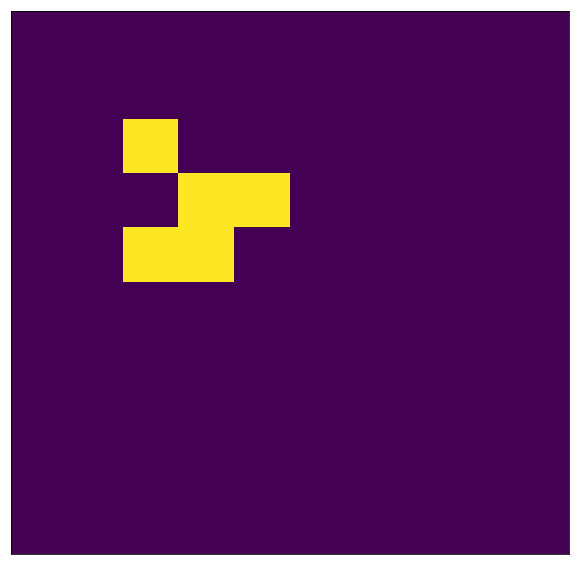

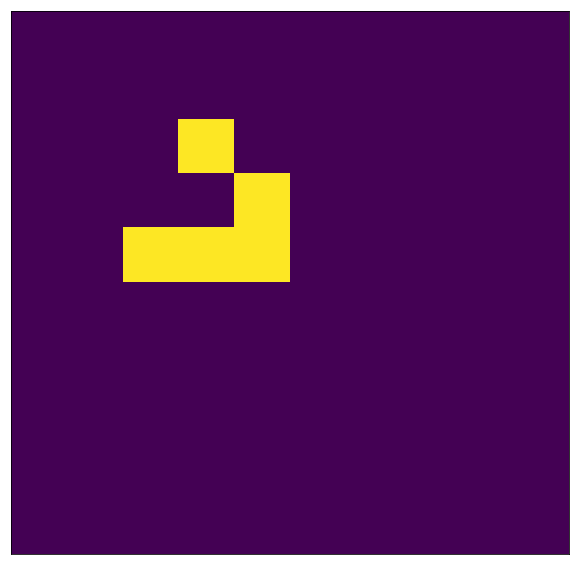

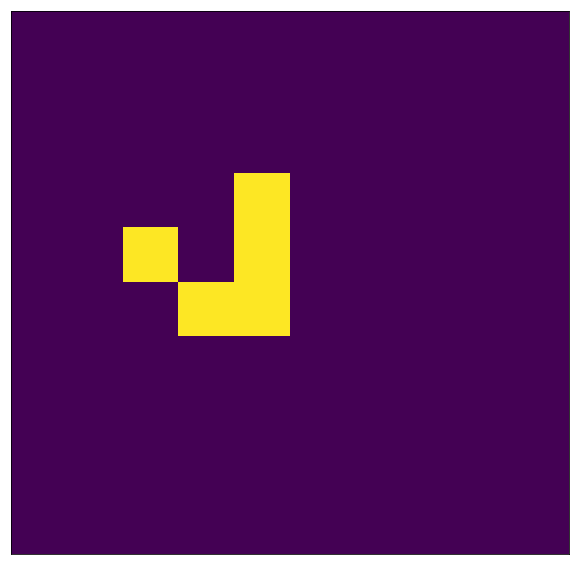

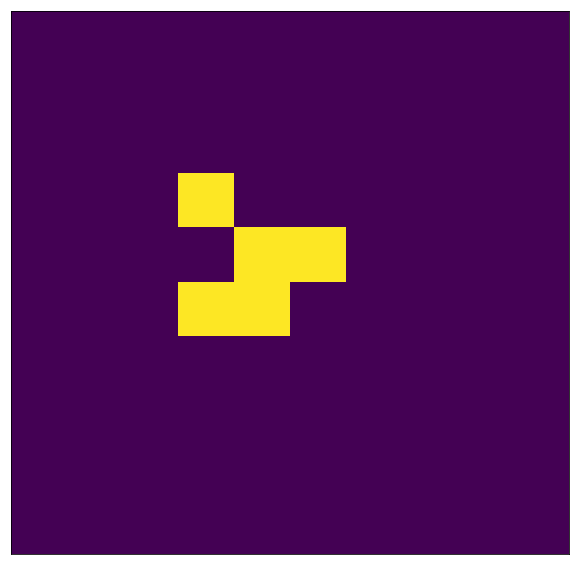

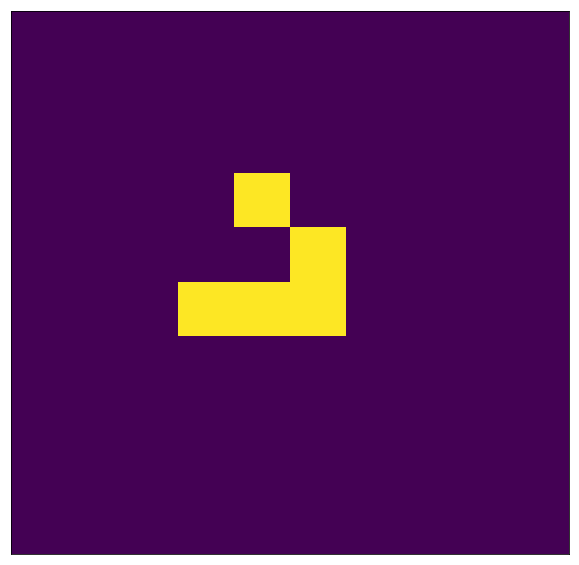

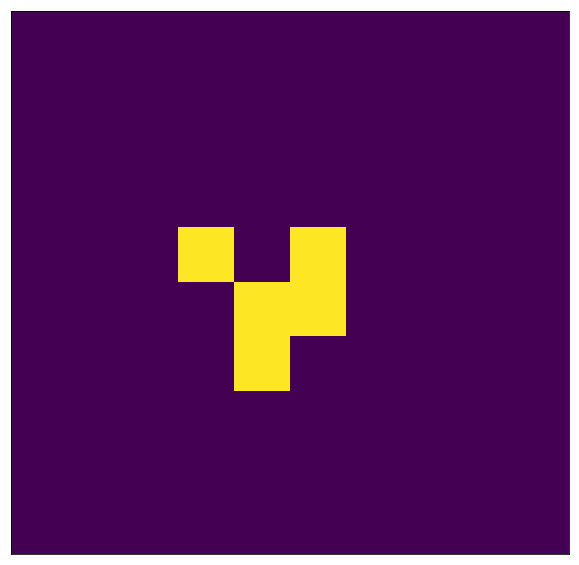

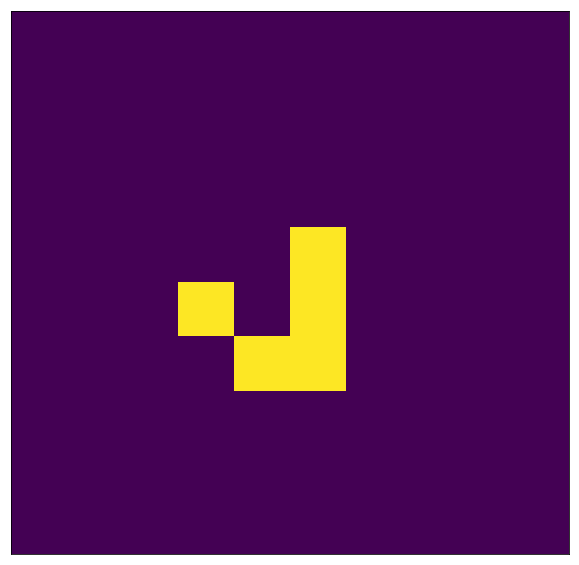

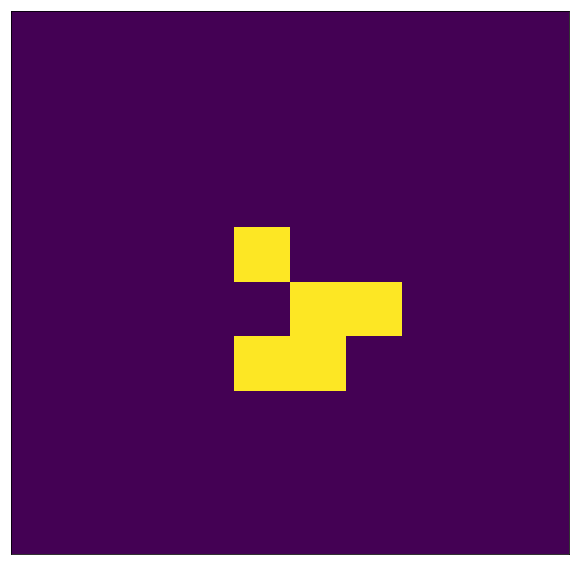

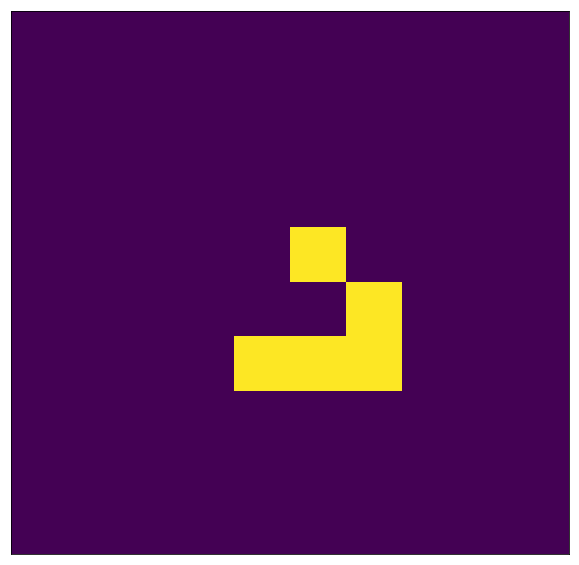

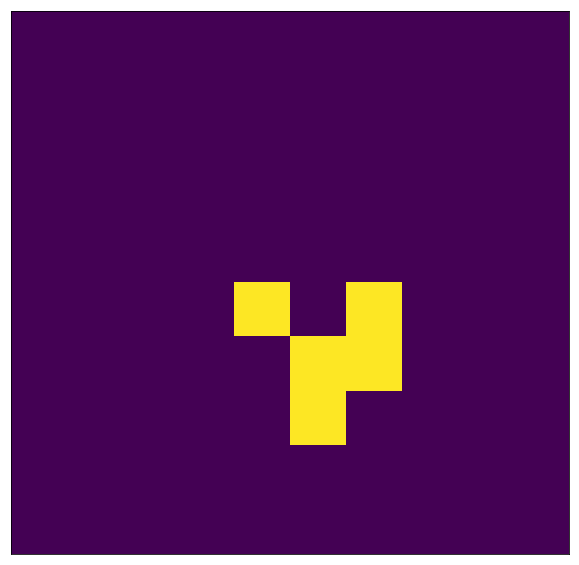

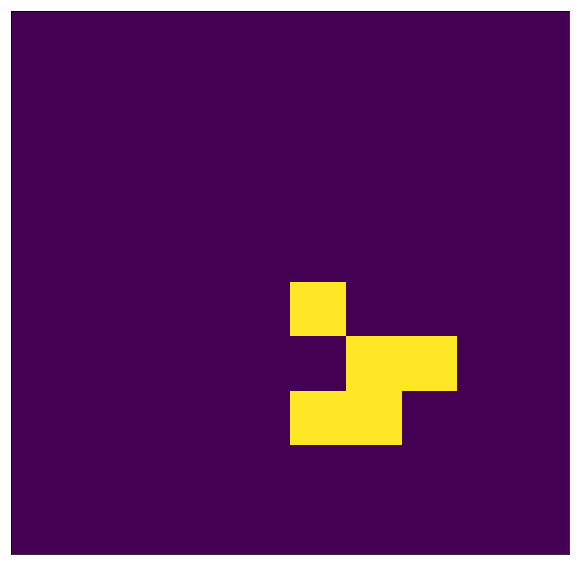

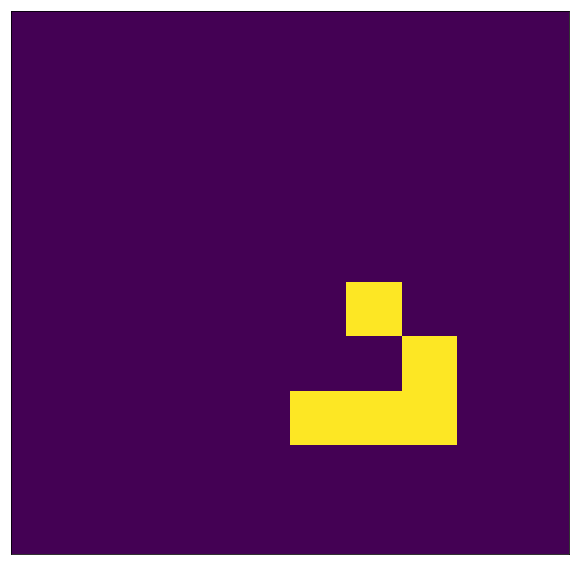

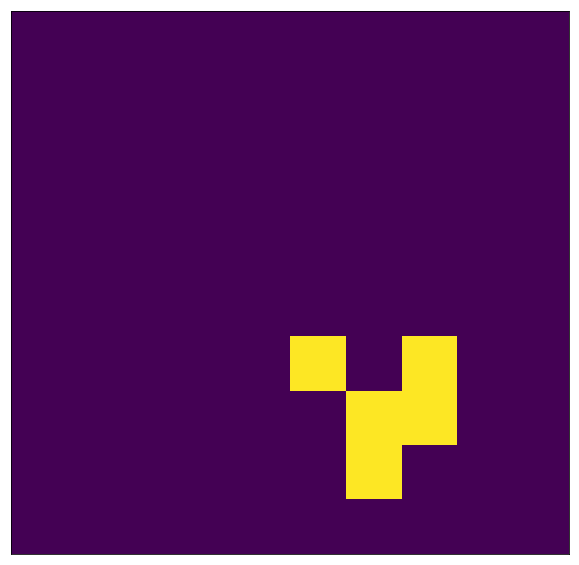

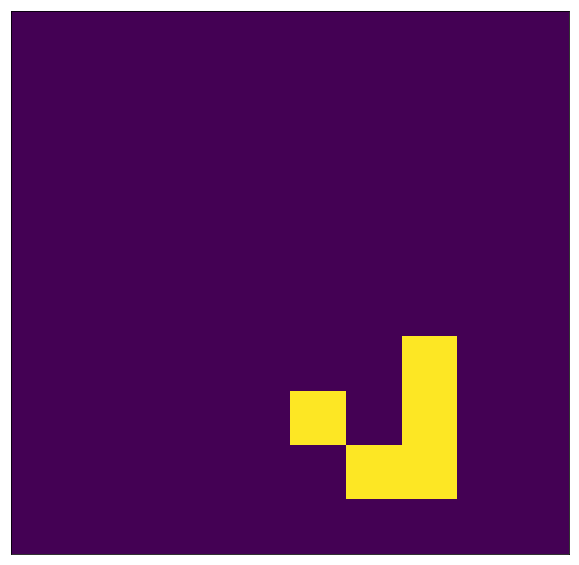

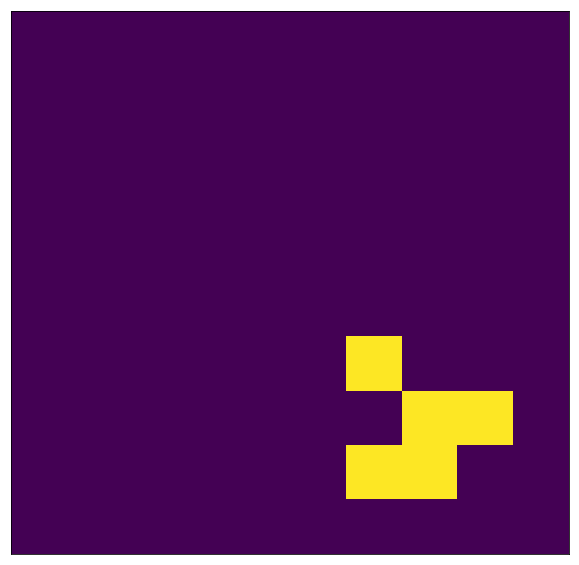

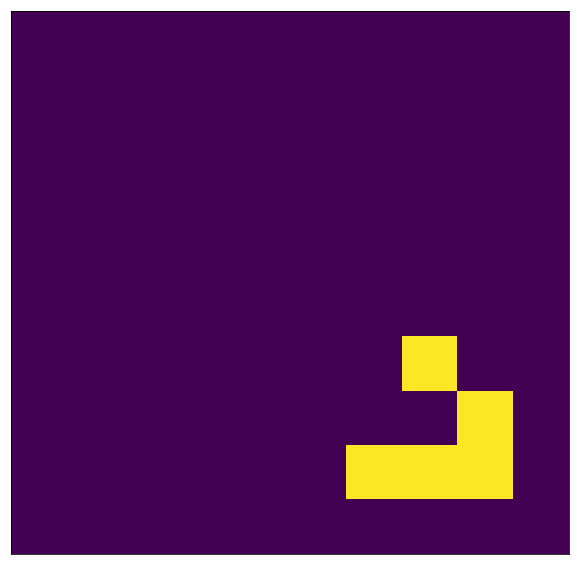

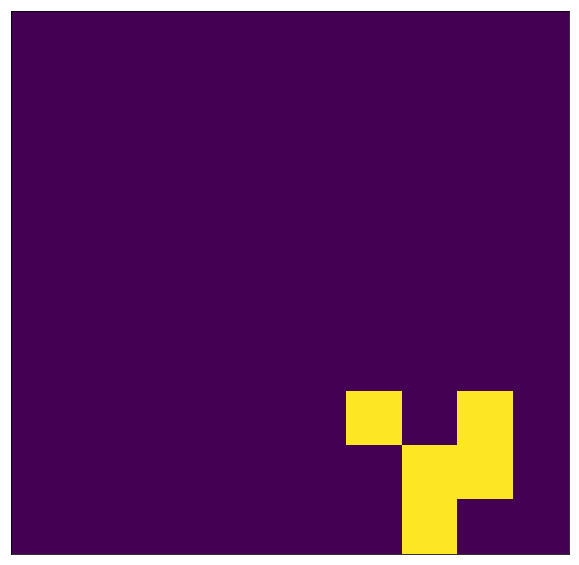

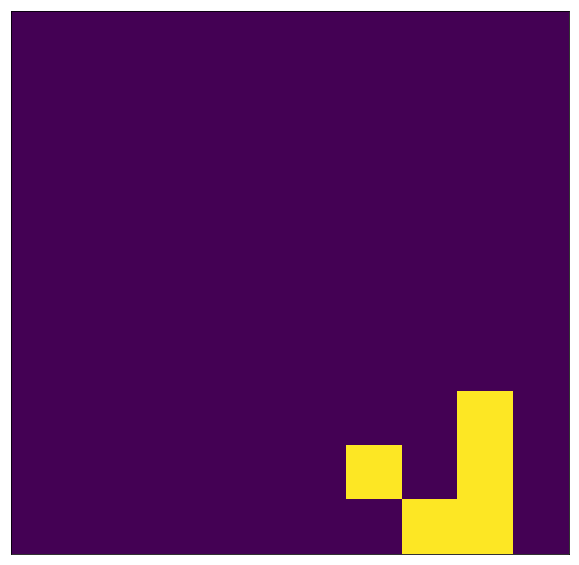

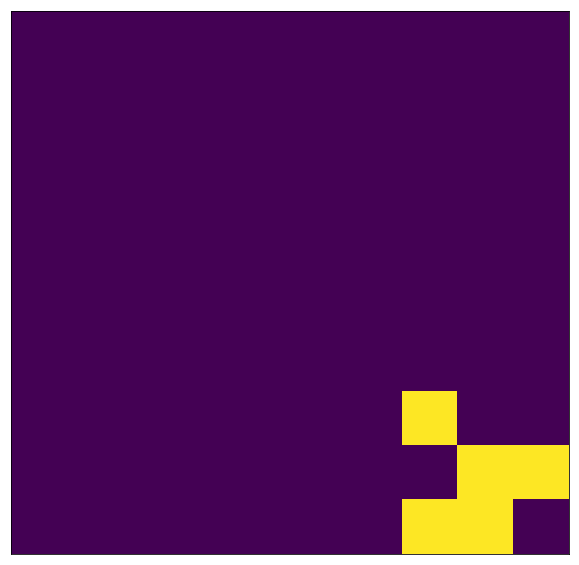

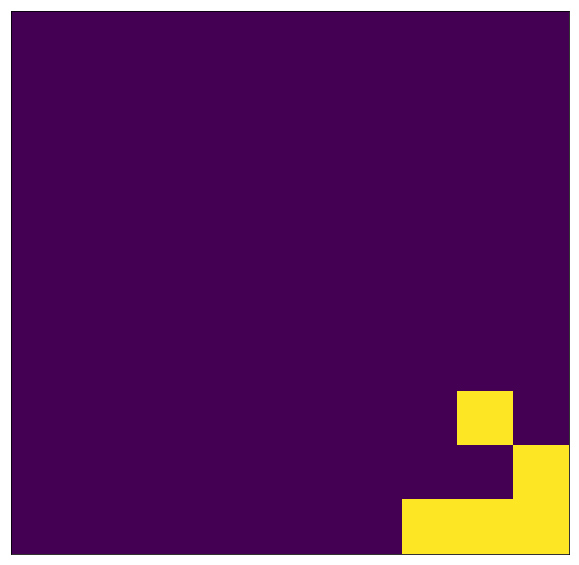

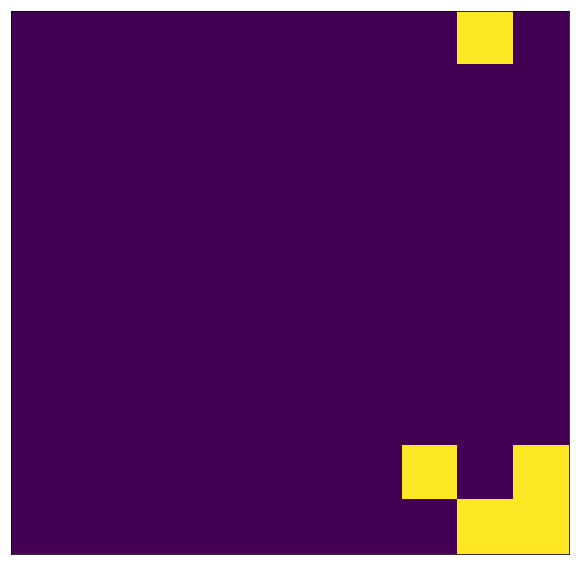

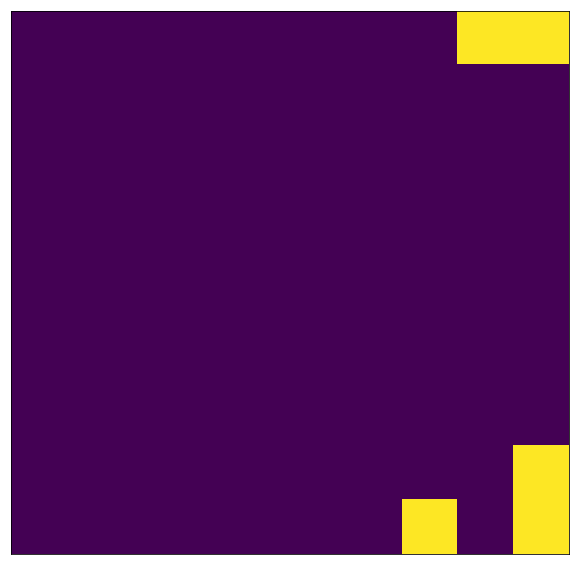

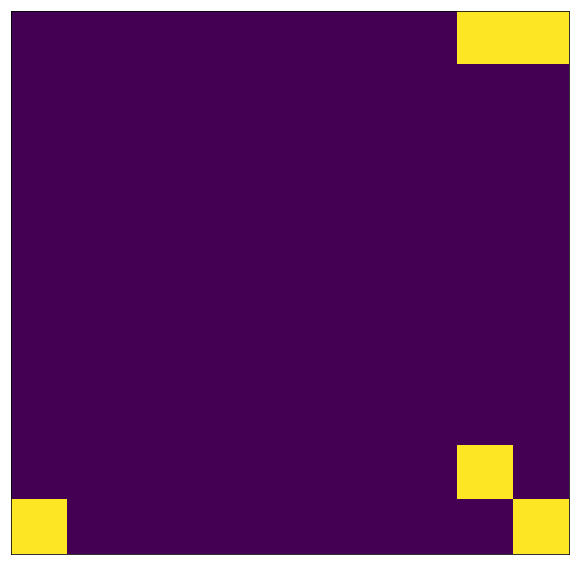

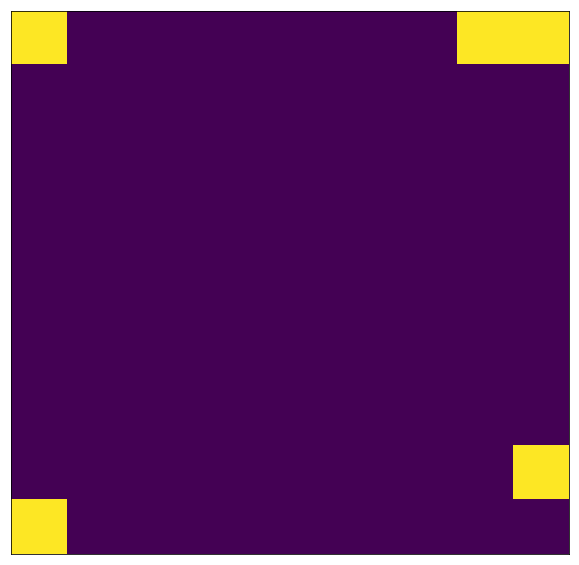

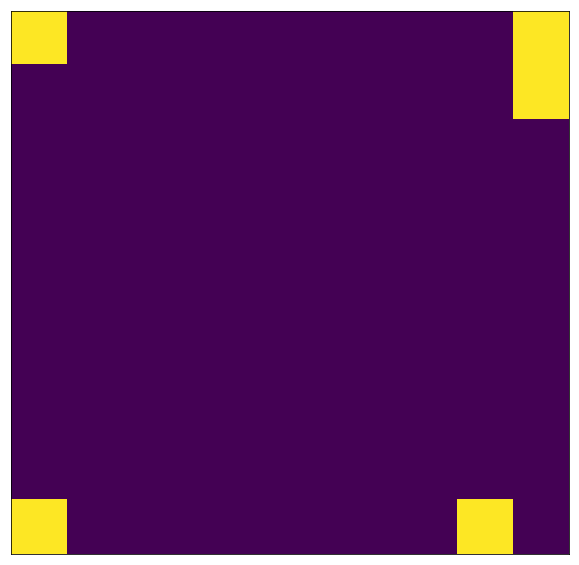

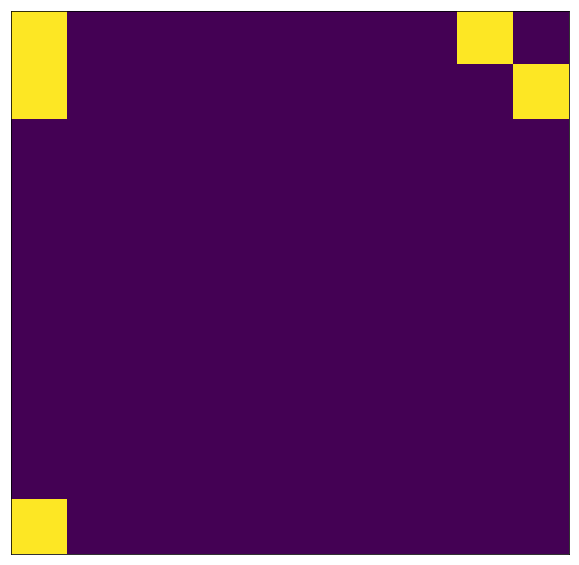

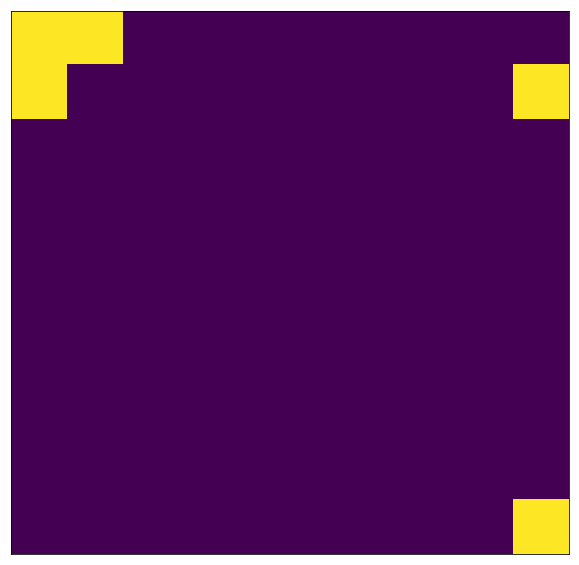

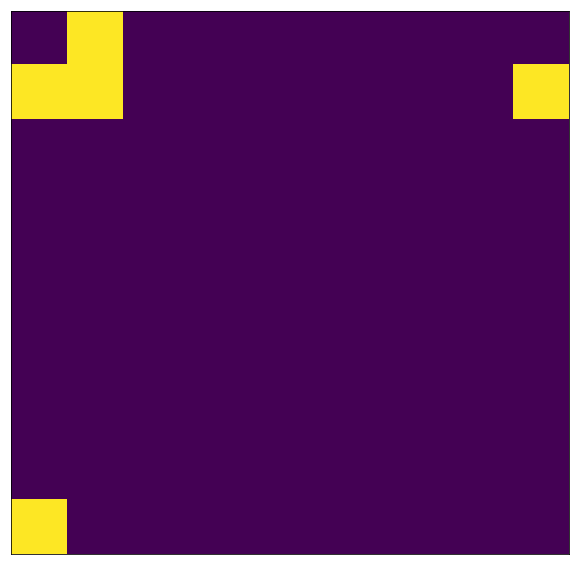

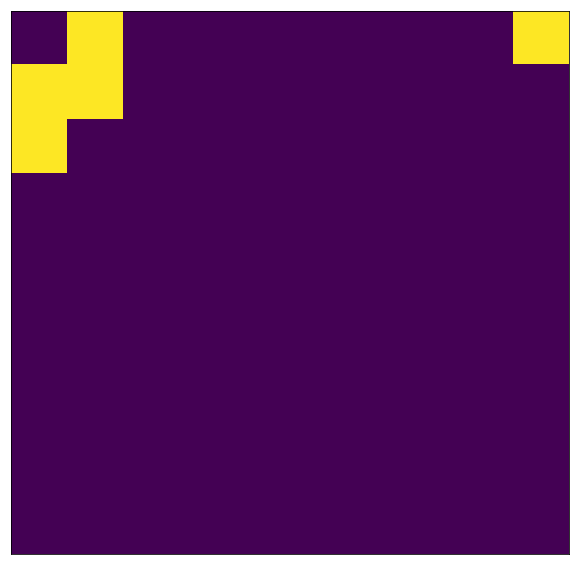

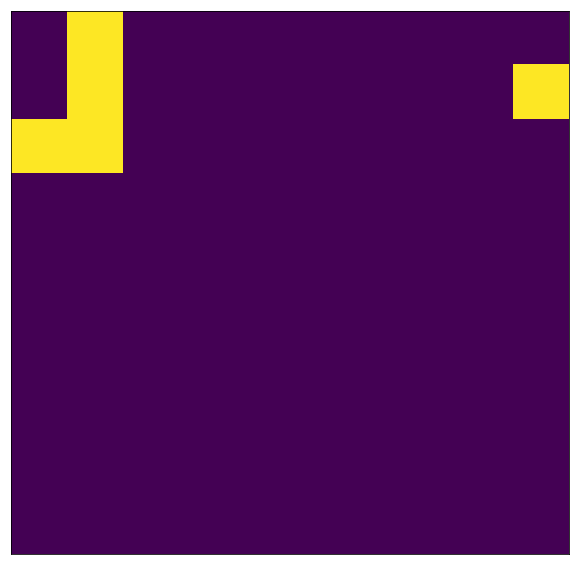

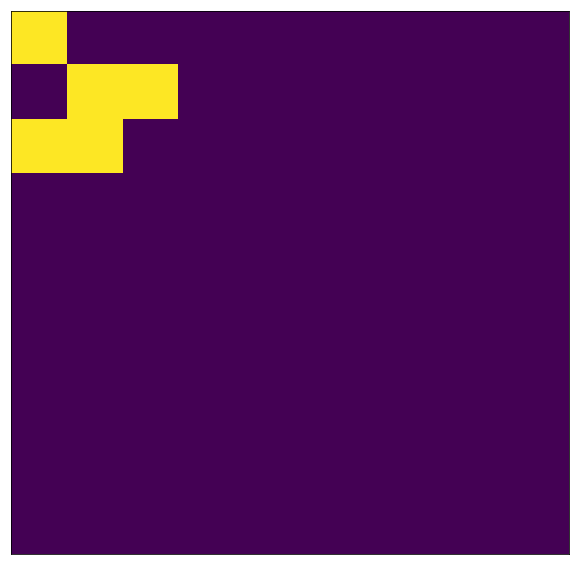

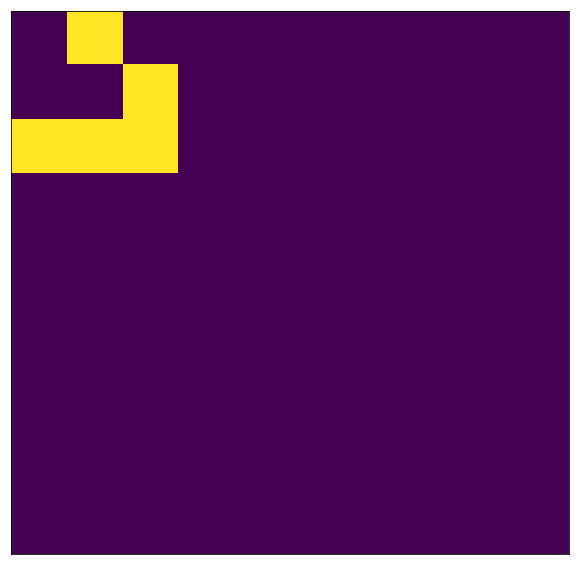

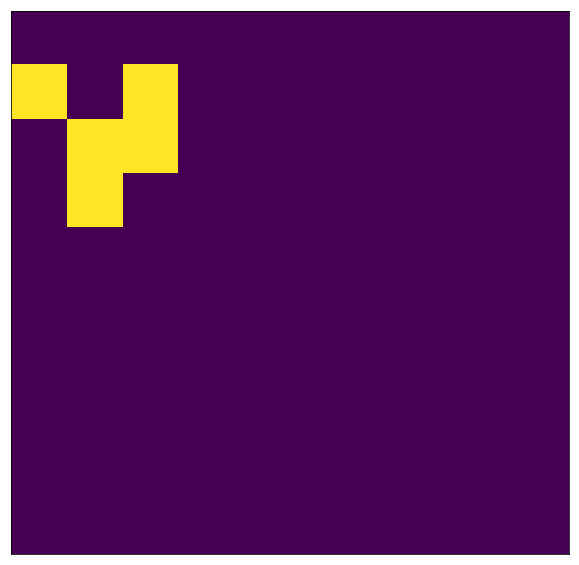

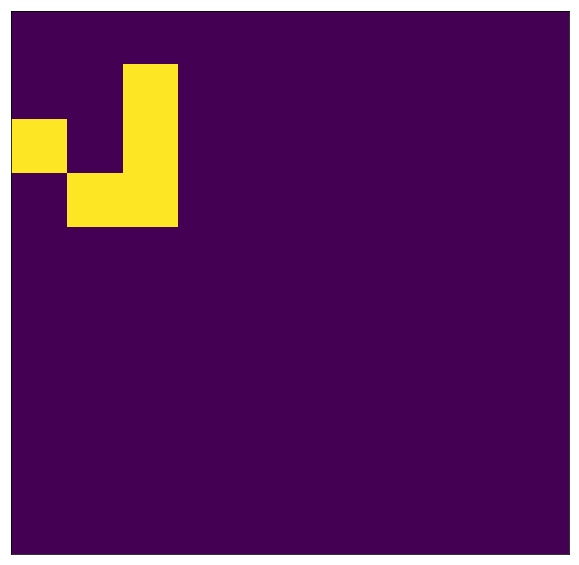

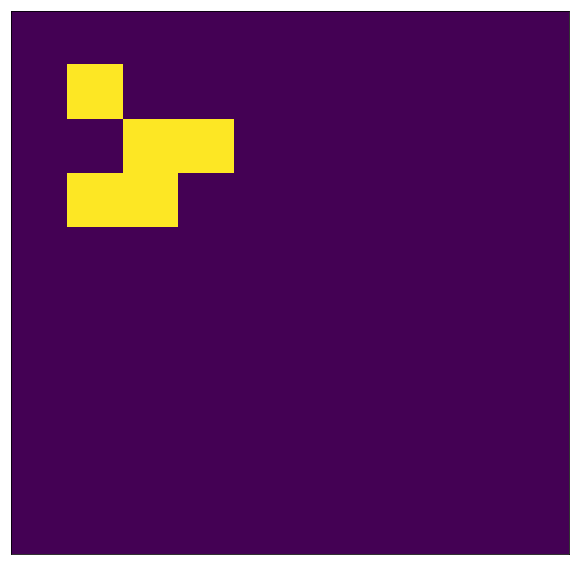

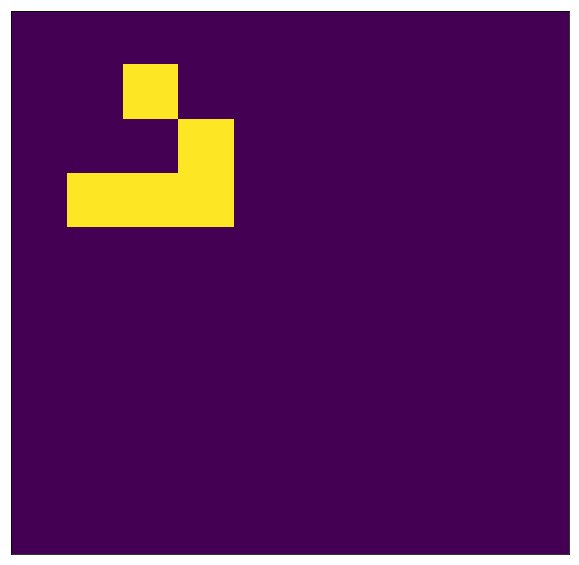

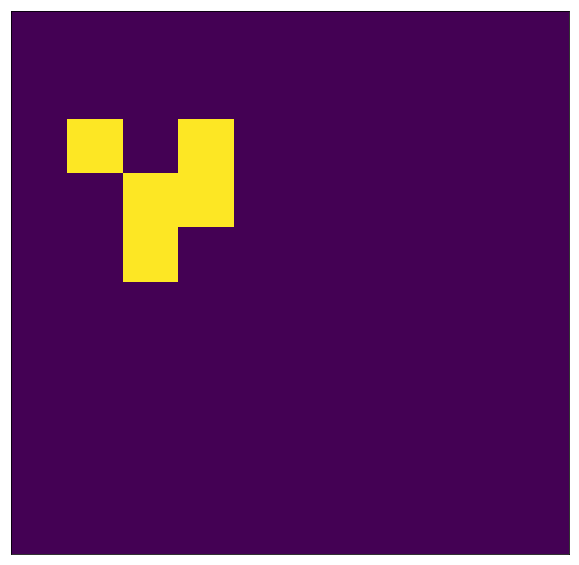

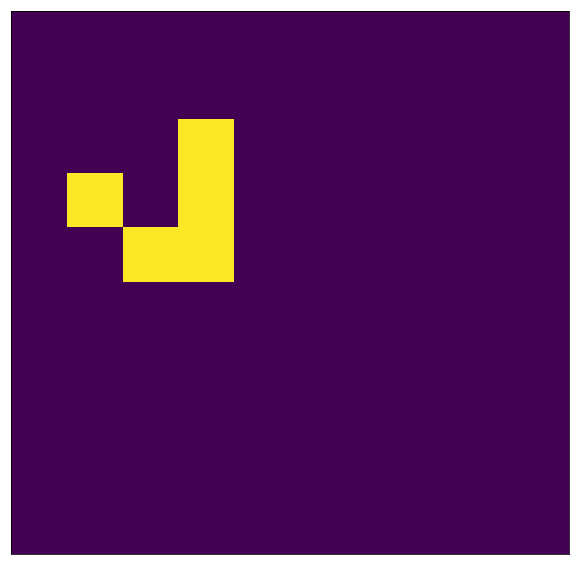

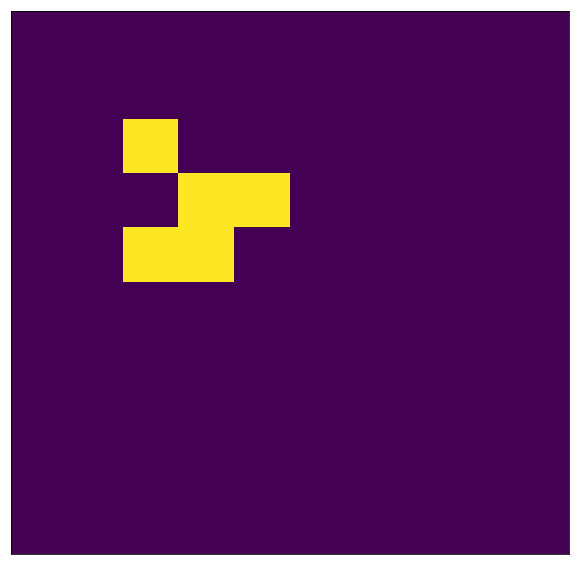

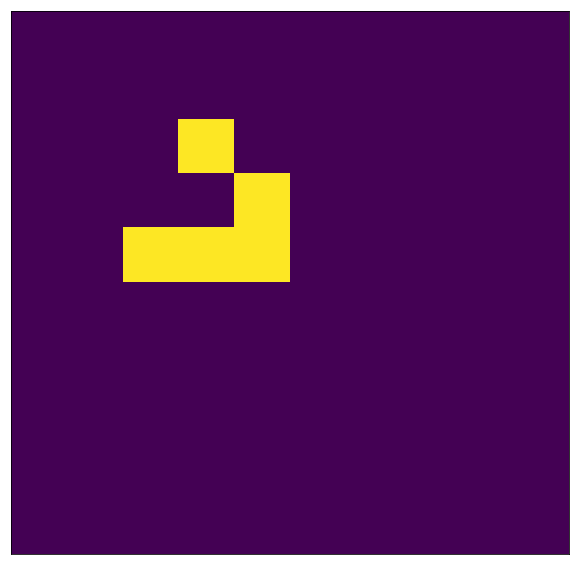

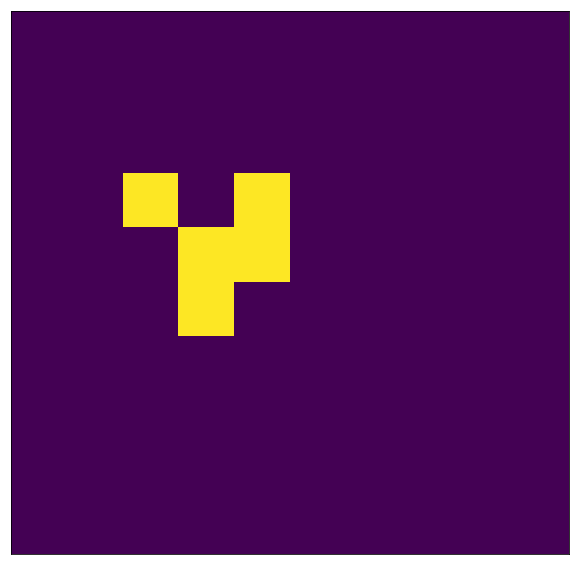

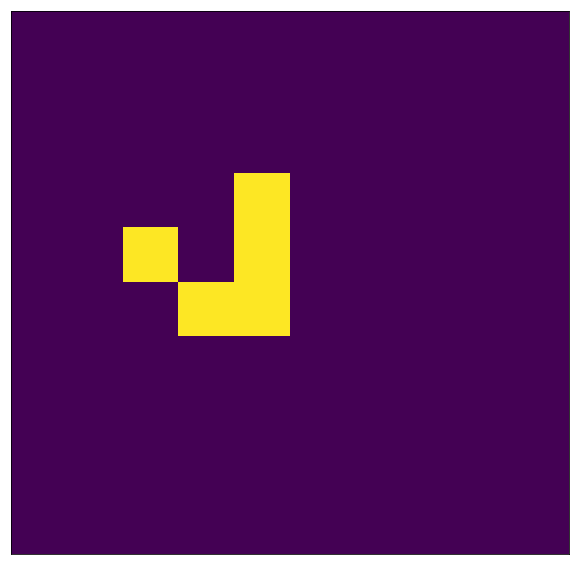

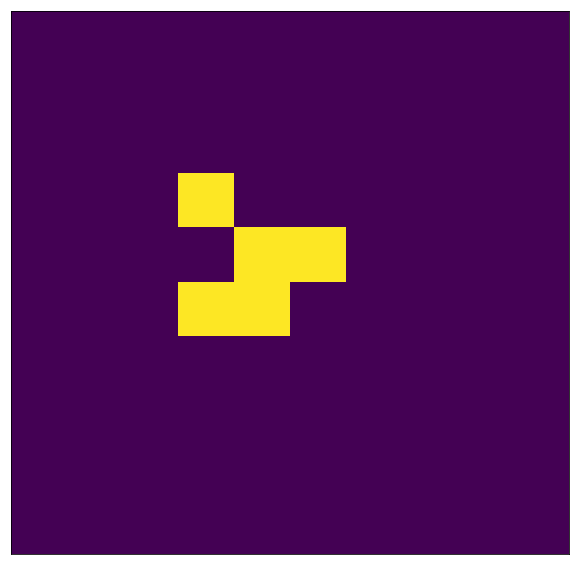

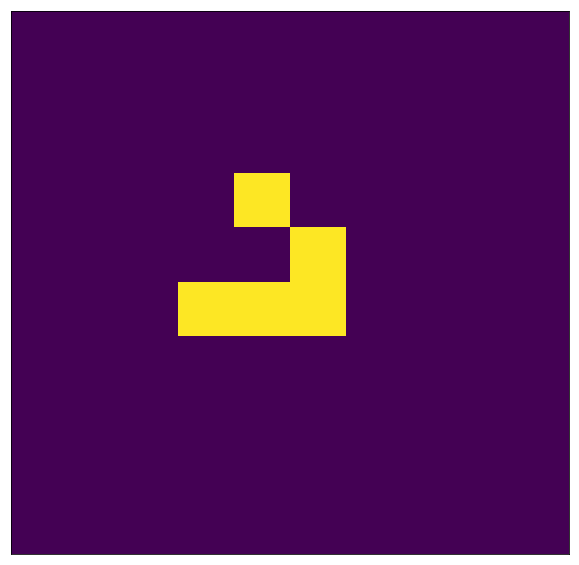

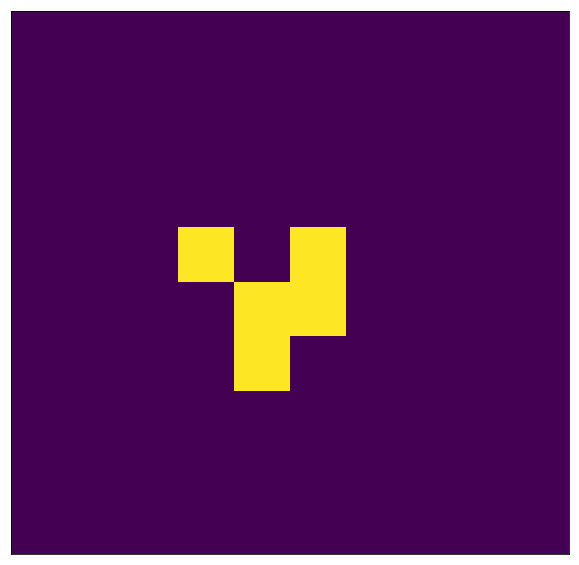

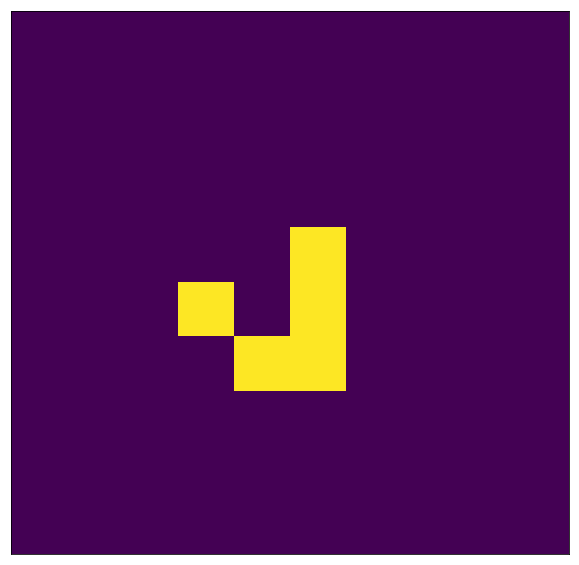

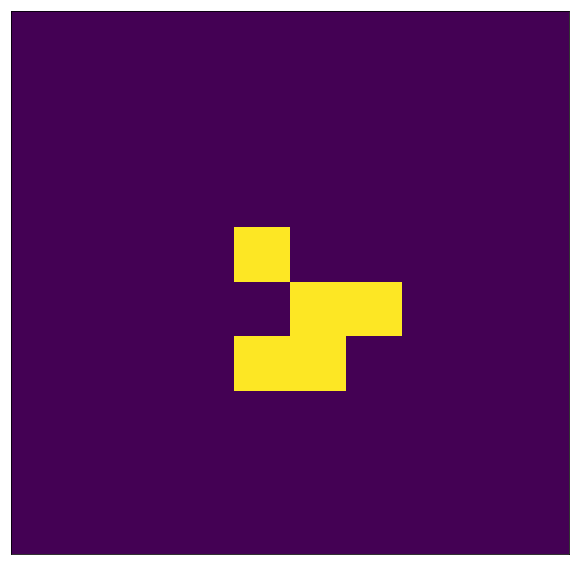

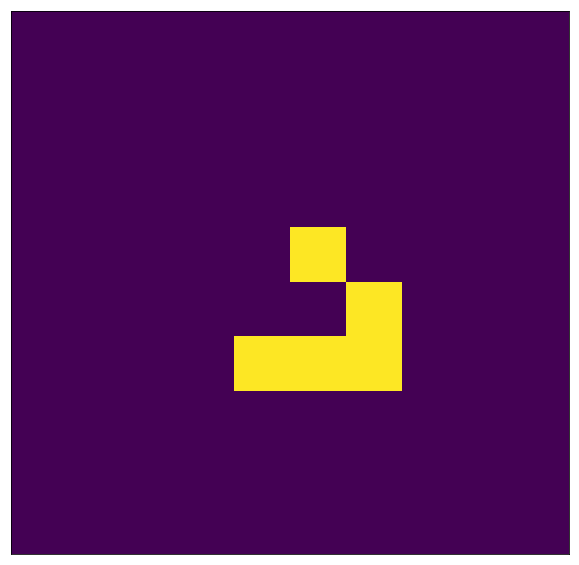

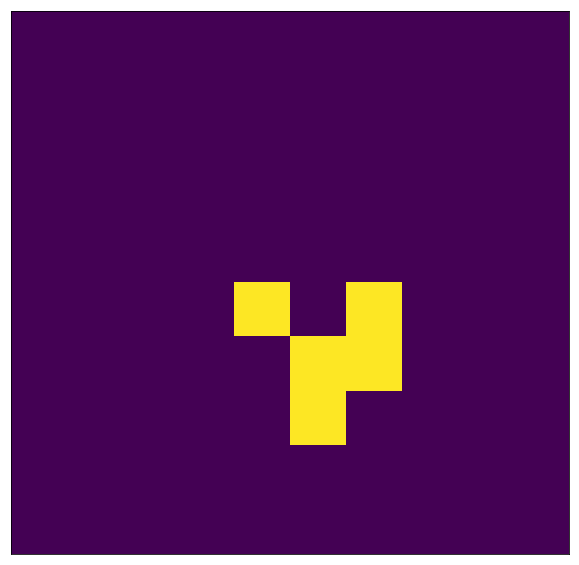

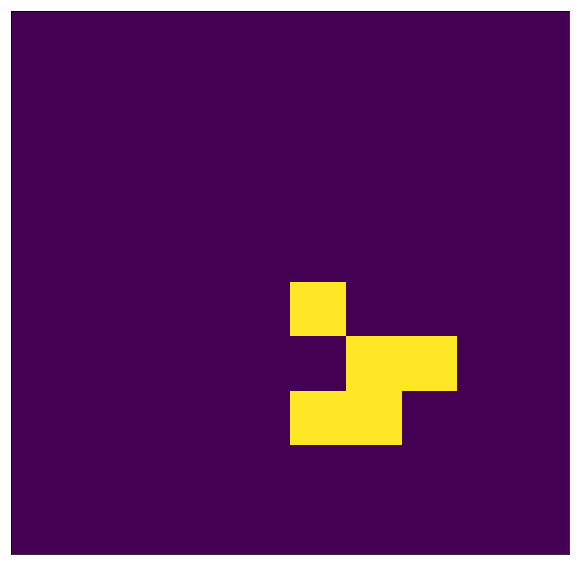

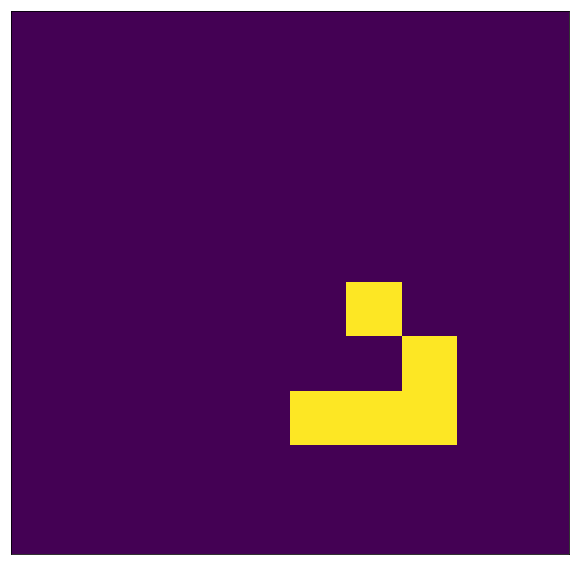

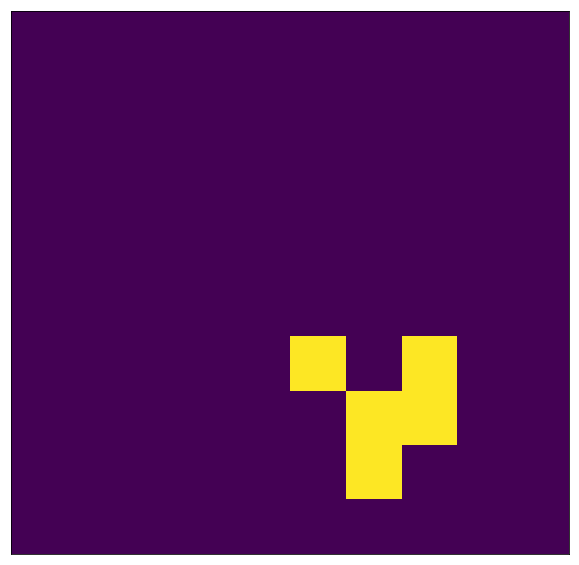

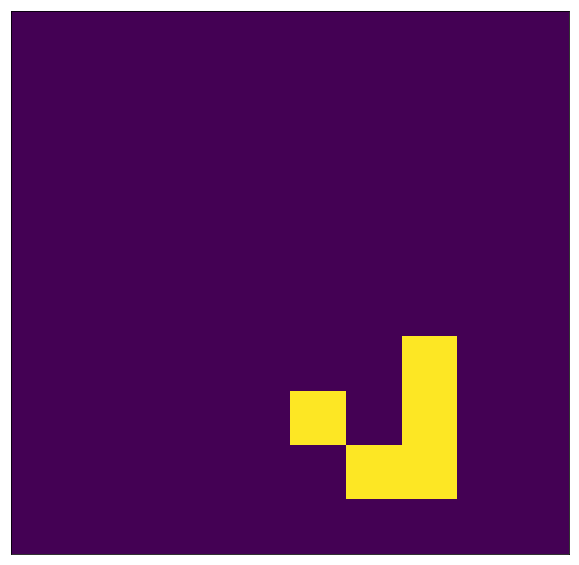

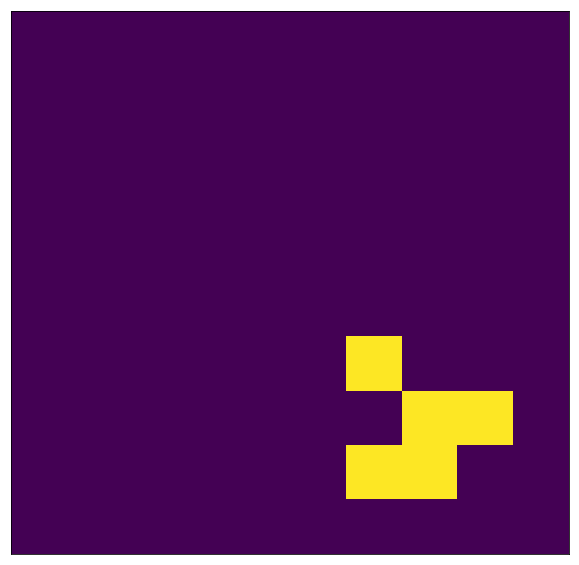

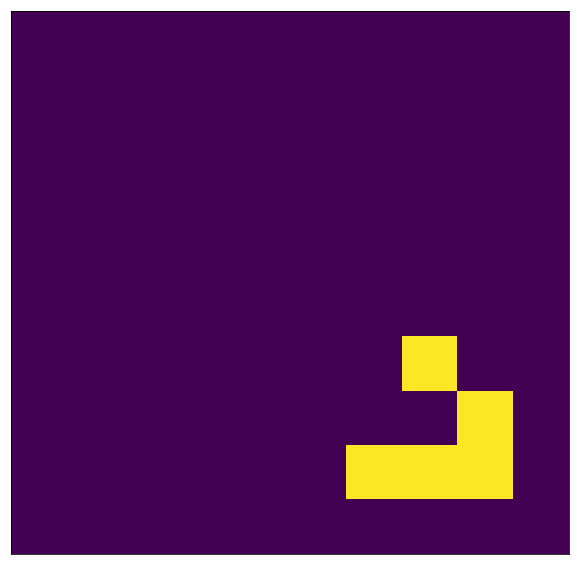

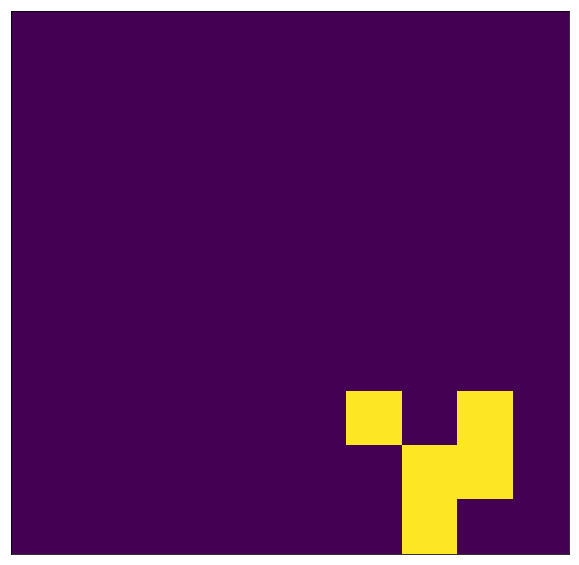

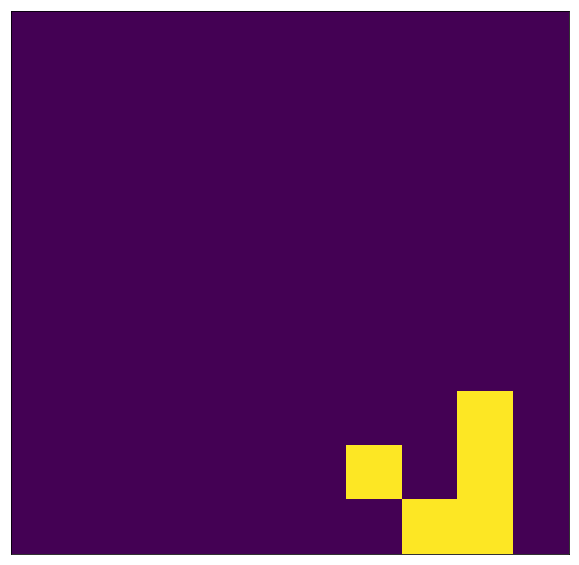

In [50]:
gif_images = []
alive_cells = []

for i in tqdm(range(num_iters)):
    
    grid_glider.plot().savefig(os.path.join(gif_images_path, f'{i}.png'))
    gif_images.append(imageio.imread(os.path.join(gif_images_path, f'{i}.png')))

    alive_cells.append(grid_glider.one_time_step())

imageio.mimsave('single_game_of_life_glider.gif', gif_images, duration=0.15)

![](single_game_of_life_glider.gif)

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(alive_cells)

ax.grid()
ax.set_xlabel('iteration')
ax.set_ylabel('# cells alive')

fig.savefig(f'{exp_name}.png')